# Experiments for asynchronous gate and expert training with different datasets

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import matplotlib.cm as cm  # colormaps

%matplotlib inline

In [2]:
import seaborn as sns
import numpy as np
from statistics import mean
from math import ceil, sin, cos, radians
from collections import OrderedDict
import os
import pandas as pd
from pprint import pprint
from copy import deepcopy

In [3]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset
import torchvision.transforms.functional as TF

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print('device', device)
else:
    device = torch.device("cpu")
    print('device', device)

device cuda:0


In [5]:
# import MoE expectation model. All experiments for this dataset are done with the expectation model as it
# provides the best guarantee of interpretable task decompositions
from moe_models.moe_expectation_model import moe_expectation_model
from helper.moe_models import cross_entropy_loss
from helper.visualise_results import imshow

device cuda:0
device cuda:0
device cuda:0


### NOTE: Pre-trained models are provided to check the results of all the experiments if you do not have the time to train all the models. 

## Load MNIST dataset

In [6]:
# Paths to where the trained models and figures will be stored. You can change this as you see fit.
fig_path = '../figures/test'
model_path = '../models/test'
pre_trained_model_path = '../models/pre_trained'

if not os.path.exists(fig_path):
    os.mkdir(fig_path)
if not os.path.exists(model_path):
    os.mkdir(model_path)

In [7]:
import torchvision.transforms as transforms

# transforms: Convert PIL image to tensors and normalize
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))]) 

In [8]:
trainsize = 10000
testsize = 2000

In [9]:
# Load and split data as train and test
trainset = torchvision.datasets.MNIST('./data',
    download=True,
    train=True,
    transform=transform,
    target_transform = torch.tensor,                                 
    )
testset = torchvision.datasets.MNIST('./data',
    download=True,
    train=False,
    transform=transform,
    target_transform = torch.tensor,)

batch_size = 64
# dataloaders
trainloader = torch.utils.data.DataLoader(torch.utils.data.Subset(trainset, range(trainsize)), 
                                          batch_size=batch_size,
                                          shuffle=True)

testloader = torch.utils.data.DataLoader(torch.utils.data.Subset(testset, range(testsize)),
                                         batch_size=testsize,
                                         shuffle=False)
num_classes = 10

image, label = trainset.__getitem__(0)
print('Image shape', image.shape)
print('Train samples ', len(trainset))
print('Test samples ', len(testset))


Image shape torch.Size([1, 28, 28])
Train samples  60000
Test samples  10000


Data samples


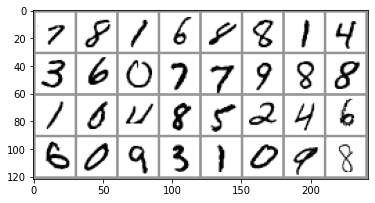

In [10]:
# create grid of images
dataiter = iter(trainloader)
images, labels = dataiter.next()
img_grid = torchvision.utils.make_grid(images[0:32])

print('Data samples')
# show images
imshow(img_grid, one_channel=True)


### Create combined rotated and unrotated MNIST image dataset of the digits 1-5

In [11]:
from PIL import Image
def rotate_dataset(d, rotation):
    result = torch.FloatTensor(d.size(0), 1, 28,28)
    tensor = transforms.ToTensor()
    norm = transforms.Normalize((0.5,), (0.5,))
    
    for i in range(d.size(0)):
        img = Image.fromarray(d[i].numpy(), mode='L')
        result[i] = norm(TF.rotate(tensor(img), rotation))
    return result

In [12]:
rot = 90

rot_train = rotate_dataset(trainset.data, rot)
rot_test= rotate_dataset(testset.data, rot)

In [13]:
# Function to extract subset of classes from the datasets
def filter_classes(classes_sub, classes_full, size, targets):
    print(classes_sub)
    start = 0
    labels = targets
    index = []
    per_class_size = ceil(size/len(classes_sub))
    for t in classes_sub:
        i = classes_full.index(t)
        index += list(np.where(labels == i)[0])[0:per_class_size]
    return index[0:size]

In [14]:
classes_mnist = ['0','1','2','3','4','5','6','7','8','9']

In [15]:
mnist_indices_train = filter_classes(classes_mnist[0:5], classes_mnist, int(trainsize/2), trainset.targets)
mnist_indices_test = filter_classes(classes_mnist[0:5], classes_mnist, int(testsize/2), testset.targets)

['0', '1', '2', '3', '4']
['0', '1', '2', '3', '4']


In [16]:
# shifting the labels by 5 to avoid overlap when selecting digits 1-5
classes_rot_mnist = ['5','6','7','8','9','10','11','12','13','14']

In [17]:
rot_trainset = TensorDataset(rot_train, trainset.targets+5)
rot_testset = TensorDataset(rot_test, testset.targets+5)

In [18]:
rot_trainloader = torch.utils.data.DataLoader(torch.utils.data.Subset(rot_trainset,mnist_indices_train), batch_size=batch_size,
                                          shuffle=True, num_workers=1, pin_memory=True)
rot_testloader = torch.utils.data.DataLoader(torch.utils.data.Subset(rot_trainset,mnist_indices_test), batch_size=len(mnist_indices_test),
                                         shuffle=True, num_workers=1, pin_memory=True)

Data samples


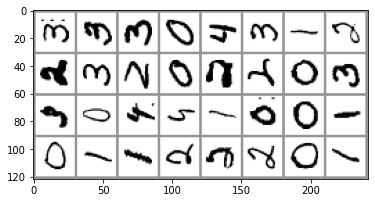

In [19]:
# create grid of images
dataiter = iter(rot_trainloader)
images, labels = dataiter.next()
img_grid = torchvision.utils.make_grid(images[0:32])

print('Data samples')
# show images
imshow(img_grid, one_channel=True)


In [20]:
rot_unrot_trainset = torch.utils.data.ConcatDataset([torch.utils.data.Subset(trainset,mnist_indices_train), 
                                                 torch.utils.data.Subset(rot_trainset,mnist_indices_train)])
rot_unrot_testset = torch.utils.data.ConcatDataset([torch.utils.data.Subset(testset,mnist_indices_test),
                                                torch.utils.data.Subset(rot_testset,mnist_indices_test)])

In [21]:
rot_unrot_trainloader = torch.utils.data.DataLoader(rot_unrot_trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=1, pin_memory=True)
rot_unrot_testloader = torch.utils.data.DataLoader(rot_unrot_testset, batch_size=len(rot_unrot_testset),
                                         shuffle=True, num_workers=1, pin_memory=True)

Data samples


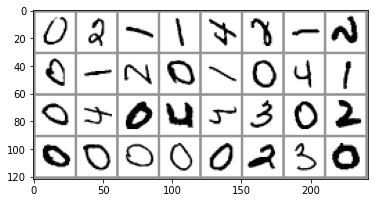

In [22]:
# create grid of images
dataiter = iter(rot_unrot_trainloader)
images, labels = dataiter.next()
img_grid = torchvision.utils.make_grid(images[0:32])

print('Data samples')
# show images
imshow(img_grid, one_channel=True)


## Create combined FMNIST and MNIST dataset

In [23]:
fmnist_trainset = torchvision.datasets.FashionMNIST('data', transform=transform, train=True, download=True)

In [24]:
fmnist_testset = torchvision.datasets.FashionMNIST('data',transform=transform, train=False)

In [25]:
# Since we are combining the fashion mnist and mnist data that have the same numerical labels from 0-9 
# we want to offset the mnist target so there is no overlap of the labels
def target_transform(target):
    return target+2

In [26]:
mnist_trainset = torchvision.datasets.MNIST('data', transform=transform, target_transform=target_transform, train=True, download=True)

In [27]:
mnist_testset = torchvision.datasets.MNIST('data',transform=transform, target_transform=target_transform, train=False)

In [28]:
classes_fmnist = ['t-shirt', 'Trouser', 'Pullover','Dress','Coat','Sandal',
                  'Shirt','Sneaker','Bag','Ankle boot']
classes_mnist = ['0','1','2','3','4','5','6','7','8','9']

# Combined fmnist and mnist classes. 
classes_fmnist_mnist = classes_fmnist[0:6]+[str(n) for n in range(4,10)]
print('classes_fmnist_mnist', classes_fmnist_mnist)

classes_fmnist_mnist ['t-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', '4', '5', '6', '7', '8', '9']


In [29]:
# Function to extract subset of classes from the datasets
def filter_classes(classes_sub, classes_full, size, data):
    print(classes_sub)
    start = 0
    labels = data.targets
    index = []
    per_class_size = ceil(size/len(classes_sub))
    for t in classes_sub:
        i = classes_full.index(t)
        index += list(np.where(labels == i)[0])[0:per_class_size]
    return index[0:size]

In [30]:
# Get the data for first 6 classes of fmnist dataset
fmnist_indices_train = filter_classes(classes_fmnist[0:6], classes_fmnist, int(trainsize/2), fmnist_trainset)
fmnist_indices_test = filter_classes(classes_fmnist[0:6], classes_fmnist, int(testsize/2), fmnist_testset)

['t-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal']
['t-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal']


In [31]:
# Get the data for last 6 classes of fmnist dataset
mnist_indices_train = filter_classes(classes_mnist[4:], classes_mnist, int(trainsize/2), mnist_trainset)
mnist_indices_test = filter_classes(classes_mnist[4:], classes_mnist, int(testsize/2), mnist_testset)

['4', '5', '6', '7', '8', '9']
['4', '5', '6', '7', '8', '9']


In [32]:
# Create the combined dataset with fmnist and mnist classes
fmnist_mnist_trainset = torch.utils.data.ConcatDataset([torch.utils.data.Subset(fmnist_trainset,fmnist_indices_train), 
                         torch.utils.data.Subset(mnist_trainset,mnist_indices_train)])
fmnist_mnist_testset = torch.utils.data.ConcatDataset([torch.utils.data.Subset(fmnist_testset,fmnist_indices_test), 
                        torch.utils.data.Subset(mnist_testset,mnist_indices_test)])
train_size = len(fmnist_indices_train)+len(mnist_indices_train)
test_size = len(fmnist_indices_test)+len(mnist_indices_test)
print("Train size", train_size)
print("Test size", test_size)

Train size 10000
Test size 2000


In [33]:
fmnist_mnist_trainloader = torch.utils.data.DataLoader(fmnist_mnist_trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=1, pin_memory=True)
fmnist_mnist_testloader = torch.utils.data.DataLoader(fmnist_mnist_testset, batch_size=len(fmnist_mnist_testset),
                                         shuffle=True, num_workers=1, pin_memory=True)

In [34]:
num_classes_fmnist_mnist = len(classes_fmnist_mnist)

Data samples


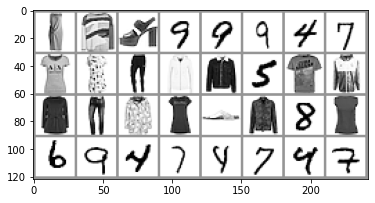

In [35]:
# create grid of images
dataiter = iter(fmnist_mnist_trainloader)
images, labels = dataiter.next()
img_grid = torchvision.utils.make_grid(images[0:32].view(-1, 1, 28, 28).type(torch.float))

print('Data samples')
# show images
imshow(img_grid, one_channel=True)

## Create imbalanced MNIST trainset

In [36]:
def imbalance_dataset(data, labels, fracs, selected_labels, size):
    new_data = []
    new_labels = []
        
    unique_labels = torch.unique(labels)
    per_class_size = ceil(size/len(unique_labels))
    
    for l in unique_labels:
        indices = torch.where(labels == l)[0][0:per_class_size]
        if l in selected_labels:
            frac = fracs[np.random.randint(0,len(fracs),1)[0]]
        else:
            frac = 1.0
        selected_indices = np.random.choice(indices, int(frac*len(indices)))
        n_samples = data[selected_indices]
        n_labels = labels[selected_indices]
        
        new_data.append(n_samples)
        new_labels = new_labels + [l]*len(selected_indices)
        
    return TensorDataset(torch.vstack(new_data).view(-1,1,28,28).type(torch.float), torch.tensor(new_labels))



In [37]:
fracs = [0.25,0.5,0.75, 1.0]
fracs = [0.5]

imbalanced_trainset = imbalance_dataset(trainset.data, trainset.targets, fracs, [0,1,2,3,4,6,7,8,9], trainsize*3) 

torch.save(imbalanced_trainset, open('data/imbalanced_dataset_5.data', 'wb'))

In [38]:
imbalanced_trainset = torch.load(open('data/imbalanced_dataset_5.data', 'rb'))

In [39]:
len(imbalanced_trainset)

16500

(array([1500., 1500., 1500., 1500., 1500., 3000., 1500., 1500., 1500.,
        1500.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

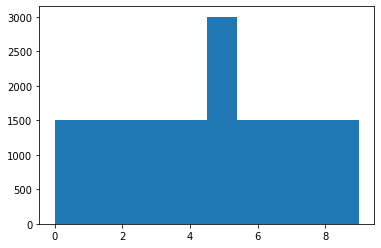

In [40]:
plt.hist(imbalanced_trainset[:][1].numpy(), align='mid')

In [41]:
batch_size

64

In [42]:
imbalanced_trainloader = torch.utils.data.DataLoader(imbalanced_trainset, batch_size=64,
                                          shuffle=True, num_workers=1, pin_memory=True)

Data samples


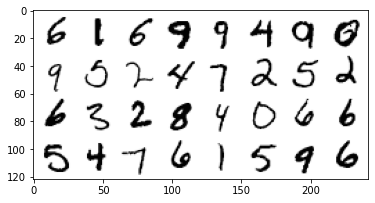

In [43]:
# create grid of images
dataiter = iter(imbalanced_trainloader)
images, labels = dataiter.next()
img_grid = torchvision.utils.make_grid(images[0:32].view(-1, 1, 28, 28).type(torch.float))

print('Data samples')
# show images
imshow(img_grid, one_channel=True)

## Define expert and gate networks

In [44]:
# Convolutional network with one convultional layer and 2 hidden layers with ReLU activation
class expert_layers(nn.Module):
    def __init__(self, num_classes, output):
        super(expert_layers, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=5)
        self.fc1 = nn.Linear(in_features=1*12*12, out_features=5) # this is a pure linear transform
        self.fc2 = nn.Linear(in_features=5, out_features=10) # this is a pure linear transform
        
        self.out = nn.Linear(in_features=10, out_features=num_classes)
        
        self.num_classes = num_classes
        self.output = output
        
    def forward(self, t):
        # conv 1
        t = self.conv1(t)
        
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        # fc1
        t = t.reshape(-1, 1*12*12)
        t = self.fc1(t)
        t = F.relu(t)

        # fc2
        t = self.fc2(t)
        t = F.relu(t)

        # output
        t = F.softmax(self.out(t), dim=1)
                
        return t

In [45]:
# Convolutional network with one convolutional layer and 2 hidden layers with ReLU activation
class gate_layers(nn.Module):
    def __init__(self, num_experts, num_classes):
        super(gate_layers, self).__init__()
        # define layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=5)

        self.fc1 = nn.Linear(in_features=1*12*12, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=64)
        self.out = nn.Linear(in_features=64, out_features=num_experts)
        self.num_experts = num_experts
        self.num_classes = num_classes
        self.count = 0

    def forward(self, t, T=1.0, y=None):
        # conv 1
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        # fc1
        t = t.reshape(-1, 1*12*12)
            
        t = self.fc1(t)
        t = F.relu(t)

        # fc2
        t = self.fc2(t)
        t = F.relu(t)

        # output
        t = self.out(t)
        t = F.softmax(t/T, dim=1)
        return t


In [46]:
# create a set of experts
def experts(num_experts, total_num_classes, num_classes, expert_layers_type=expert_layers):
    models = []
    for i in range(num_experts):
        models.append(expert_layers_type(total_num_classes, num_classes[i]))
    return nn.ModuleList(models)

In [47]:
# Convolutional network with one convultional layer and 2 hidden layers with ReLU activation
class single_model(nn.Module):
    def __init__(self, masks=None, num_classes=10, output=10):
        super(single_model, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=5)
        self.fc1 = nn.Linear(in_features=1*12*12, out_features=5) # this is a pure linear transform
        self.fc2 = nn.Linear(in_features=5, out_features=10) # this is a pure linear transform
        
        self.out = nn.Linear(in_features=10, out_features=num_classes)
        
        self.num_classes = num_classes
        self.masks = masks
        self.output = output
        
    def forward(self, t):
        # conv 1
        t = self.conv1(t)
        
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        # fc1
        t = t.reshape(-1, 1*12*12)
        t = self.fc1(t)
        t = F.relu(t)

        # fc2
        t = self.fc2(t)
        t = F.relu(t)

        # output
        t = F.softmax(self.out(t), dim=1)
        
        if not self.masks is None:
            mask = torch.zeros(t.shape[0],self.num_classes)
            for m, i in zip(self.masks, range(self.output)):
                mask[:,m] = t[:,i] 
            return mask
        
        return t

## Initialize configurations and helper functions

In [48]:
def accuracy(out, yb, mean=True):
    preds = torch.argmax(out, dim=1).to(device, non_blocking=True)
    if mean:
        return (preds == yb).float().mean()
    else:
        return (preds == yb).float()

In [49]:
# gate covariant shift regularization flag 
w_importance = 0.0 
w_ortho = 0.0

def generate_plot_file(dataset, w_importance=0.0, specific=''):
    plot_file = dataset
    if w_importance > 0:
        plot_file += '_importance_'+'{:.1f}'.format(w_importance)
    if w_ortho > 0:
        plot_file += '_ortho_'+str(w_ortho)
    plot_file += '_'+specific
    
    return plot_file

## Asynch dual temp training of experts and gate with different temperatures

In [50]:
def train_dual_temp_model(model_1, trainloader, testloader, runs, temps, num_classes, total_experts, num_epochs):

    for T in temps:
        print('Temperature','{:.1f}'.format(T))

        n_run_models_1 = []
        for run in range(runs):

            print('Run:', run)

            models = {'moe_expectation_model':{'model':moe_expectation_model,'loss':cross_entropy_loss,
                                               'experts':{}},}
            for key, val in models.items():

                expert_models = experts(total_experts, num_classes, 
                                             [num_classes]*total_experts).to(device)

                gate_model = gate_layers(total_experts, num_classes).to(device)

                moe_model = val['model'](total_experts, num_classes, augment=0, attention_flag=0,
                                         experts=expert_models, gate=gate_model).to(device)

                optimizer_experts = optim.Adam(moe_model.parameters(), lr=0.001, amsgrad=False)

                optimizer_gate = optim.Adam(moe_model.parameters(), lr=0.001, amsgrad=False)

                hist = moe_model.train(trainloader, testloader,  val['loss'], optimizer_moe = None,
                                       optimizer_experts = optimizer_experts, optimizer_gate=optimizer_gate, T = T,
                                       accuracy=accuracy, epochs=num_epochs)
                val['experts'][total_experts] = {'model':moe_model, 'history':hist}

            n_run_models_1.append(models)

        # Save all the trained models
        plot_file = generate_plot_file(model_1, 0, 'temp_'+'{:.1f}'.format(T)+'_'+str(num_classes)+'_'+str(total_experts)+'_models.pt')
        torch.save(n_run_models_1,open(os.path.join(model_path, plot_file),'wb'))


## Training with regularization with different importance values

### NOTE: when importance is set to 0 then it is the default training without regularization

In [123]:
def train_with_regularization(model_2, trainloader, testloader, runs, w_importance_range, num_classes, total_experts, num_epochs):
    # Train models model_1, model_2 and model_3 for 10 runs
    for w_importance in w_importance_range:
        print('w_importance', w_importance)
        
        n_run_models_2 = []

        for run in range(runs):
            print('Run:', run)

            models = {
                'moe_expectation_model':{'model':moe_expectation_model,'loss':cross_entropy_loss,
                                         'experts':{}}}

            for key, val in models.items():
                print('Model:', key, total_experts, 'Experts')
                expert_models = experts(total_experts, num_classes, 
                                             [num_classes]*total_experts).to(device)

                gate_model = gate_layers(total_experts, num_classes).to(device)

                moe_model = val['model'](total_experts, num_classes, augment=0, attention_flag=0,
                                         experts=expert_models, gate=gate_model)

                params = [p.numel() for p in moe_model.parameters() if p.requires_grad]
                print('model params:', sum(params))

                optimizer_moe = optim.Adam(moe_model.parameters(),
                                          lr=0.001)
                hist = moe_model.train(trainloader, testloader,  val['loss'], optimizer_moe, 
                                       w_importance=w_importance,
                                       accuracy=accuracy, epochs=num_epochs)
                val['experts'][total_experts] = {'model':moe_model, 'history':hist}

            n_run_models_2.append(models)

        # Save all the trained models
        plot_file = generate_plot_file(model_2, w_importance, str(num_classes)+'_'+str(total_experts)+'_models.pt')
        torch.save(n_run_models_2,open(os.path.join(model_path, plot_file),'wb'))
    w_importance = 0.0

In [79]:
num_epochs = 20

In [80]:
temps = np.concatenate((np.arange(1.1,1.6,0.1), np.arange(0.9,0.4,-0.1)))
temps

array([1.1, 1.2, 1.3, 1.4, 1.5, 0.9, 0.8, 0.7, 0.6, 0.5])

In [81]:
runs = 10

In [82]:
train_dual_temp_model(model_1, trainloader, testloader, runs, temps, num_classes, total_experts, num_epochs)

Temperature 1.1
Run: 0
epoch 0 training loss 1.44 , training accuracy 0.51 , test accuracy 0.75
epoch 1 training loss 0.60 , training accuracy 0.79 , test accuracy 0.81
epoch 2 training loss 0.46 , training accuracy 0.85 , test accuracy 0.83
epoch 3 training loss 0.36 , training accuracy 0.88 , test accuracy 0.86
epoch 4 training loss 0.30 , training accuracy 0.91 , test accuracy 0.87
epoch 5 training loss 0.24 , training accuracy 0.93 , test accuracy 0.88
epoch 6 training loss 0.20 , training accuracy 0.94 , test accuracy 0.91
epoch 7 training loss 0.16 , training accuracy 0.96 , test accuracy 0.91
epoch 8 training loss 0.15 , training accuracy 0.96 , test accuracy 0.91
epoch 9 training loss 0.13 , training accuracy 0.97 , test accuracy 0.92
epoch 10 training loss 0.11 , training accuracy 0.97 , test accuracy 0.91
epoch 11 training loss 0.10 , training accuracy 0.97 , test accuracy 0.91
epoch 12 training loss 0.09 , training accuracy 0.98 , test accuracy 0.93
epoch 13 training loss 0.

### MNIST imbalanced data

In [235]:
# Model with gate and expert parameters initialized to default values
model_1 = 'mnist_imbalanced_5_dual_temp'

In [236]:
total_experts = 5

In [237]:
num_epochs = 20

In [247]:
temps = np.concatenate((np.arange(1.1,1.6,0.1), np.arange(0.9,0.4,-0.1)))
temps = np.arange(0.9,1.6,0.1)
temps = [10.0]
temps

[10.0]

In [248]:
runs = 1

In [249]:
train_dual_temp_model(model_1, imbalanced_trainloader, testloader, runs, temps, num_classes, total_experts, num_epochs)

Temperature 10.0
Run: 0
epoch 0 training loss 0.85 , training accuracy 0.69 , test accuracy 0.15
epoch 1 training loss 0.44 , training accuracy 0.84 , test accuracy 0.12
epoch 2 training loss 0.36 , training accuracy 0.89 , test accuracy 0.10


KeyboardInterrupt: 

tensor([3, 4, 3, 3, 1, 3, 3, 5, 2, 4], device='cuda:0') tensor([3, 4, 3, 3, 1, 3, 3, 5, 2, 4], device='cuda:0')
tensor(0.9844, device='cuda:0')


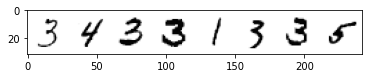

tensor([0, 0, 7, 1, 5, 8, 2, 0, 2, 5], device='cuda:0') tensor([0, 0, 7, 1, 5, 8, 2, 0, 2, 5], device='cuda:0')
tensor(0.9844, device='cuda:0')


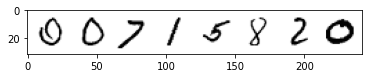

tensor([3, 0, 5, 3, 5, 9, 8, 1, 7, 0], device='cuda:0') tensor([3, 0, 5, 3, 5, 9, 8, 1, 7, 0], device='cuda:0')
tensor(1., device='cuda:0')


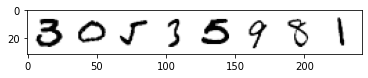

tensor([5, 4, 5, 5, 2, 8, 6, 6, 0, 8], device='cuda:0') tensor([5, 4, 5, 5, 2, 8, 6, 6, 0, 8], device='cuda:0')
tensor(1., device='cuda:0')


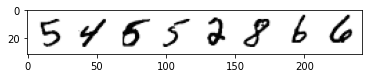

tensor([0, 4, 2, 8, 9, 9, 8, 5, 6, 5], device='cuda:0') tensor([0, 4, 2, 8, 9, 9, 8, 5, 6, 5], device='cuda:0')
tensor(1., device='cuda:0')


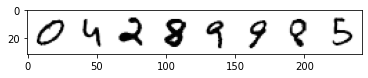

tensor([0, 7, 5, 7, 8, 9, 8, 6, 9, 4], device='cuda:0') tensor([0, 7, 5, 7, 8, 9, 8, 6, 9, 4], device='cuda:0')
tensor(1., device='cuda:0')


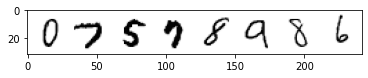

tensor([1, 1, 6, 0, 0, 8, 5, 1, 7, 5], device='cuda:0') tensor([1, 1, 6, 0, 0, 8, 5, 1, 7, 5], device='cuda:0')
tensor(1., device='cuda:0')


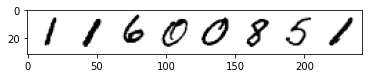

tensor([2, 0, 0, 4, 9, 4, 6, 6, 1, 4], device='cuda:0') tensor([2, 0, 0, 4, 9, 4, 6, 0, 1, 4], device='cuda:0')
tensor(0.9844, device='cuda:0')


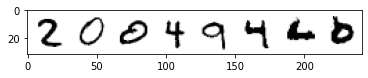

tensor([4, 1, 5, 7, 5, 5, 6, 1, 5, 6], device='cuda:0') tensor([4, 1, 5, 7, 5, 5, 6, 1, 5, 6], device='cuda:0')
tensor(1., device='cuda:0')


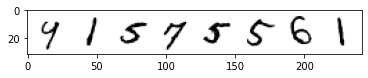

tensor([9, 7, 4, 5, 1, 4, 6, 4, 7, 9], device='cuda:0') tensor([9, 7, 4, 5, 1, 4, 6, 4, 7, 9], device='cuda:0')
tensor(0.9844, device='cuda:0')


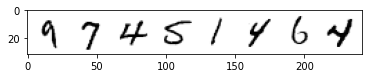

tensor([2, 9, 6, 6, 6, 6, 2, 5, 2, 8], device='cuda:0') tensor([2, 9, 6, 6, 6, 6, 2, 5, 2, 8], device='cuda:0')
tensor(0.9844, device='cuda:0')


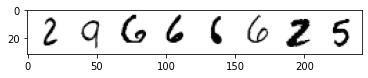

tensor([2, 8, 5, 3, 1, 9, 1, 9, 3, 5], device='cuda:0') tensor([2, 8, 5, 3, 1, 9, 1, 9, 3, 5], device='cuda:0')
tensor(1., device='cuda:0')


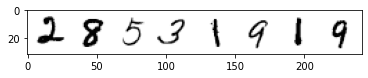

tensor([6, 1, 0, 5, 7, 1, 1, 0, 9, 4], device='cuda:0') tensor([6, 1, 0, 5, 7, 1, 1, 0, 9, 4], device='cuda:0')
tensor(0.9844, device='cuda:0')


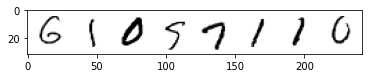

tensor([4, 8, 5, 5, 2, 0, 2, 7, 5, 9], device='cuda:0') tensor([4, 8, 5, 5, 2, 0, 2, 7, 5, 9], device='cuda:0')
tensor(1., device='cuda:0')


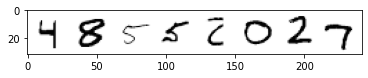

tensor([3, 6, 8, 9, 6, 4, 0, 1, 8, 5], device='cuda:0') tensor([3, 6, 8, 9, 6, 4, 0, 1, 8, 5], device='cuda:0')
tensor(1., device='cuda:0')


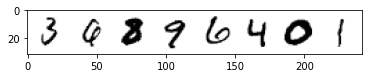

tensor([4, 4, 5, 7, 7, 4, 8, 3, 3, 6], device='cuda:0') tensor([4, 4, 5, 7, 7, 4, 8, 3, 3, 6], device='cuda:0')
tensor(1., device='cuda:0')


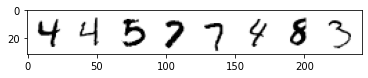

tensor([3, 5, 7, 7, 5, 9, 7, 5, 4, 0], device='cuda:0') tensor([3, 5, 7, 7, 5, 9, 7, 5, 4, 0], device='cuda:0')
tensor(0.9844, device='cuda:0')


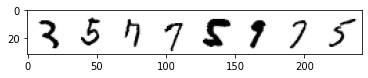

tensor([8, 5, 3, 7, 1, 5, 8, 7, 9, 4], device='cuda:0') tensor([8, 5, 3, 7, 1, 5, 8, 7, 9, 4], device='cuda:0')
tensor(1., device='cuda:0')


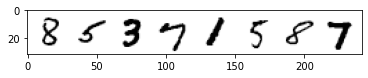

tensor([0, 7, 4, 8, 1, 7, 0, 5, 1, 7], device='cuda:0') tensor([0, 7, 4, 8, 1, 7, 2, 5, 1, 7], device='cuda:0')
tensor(0.9844, device='cuda:0')


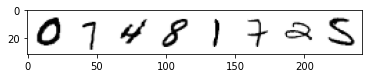

tensor([6, 5, 0, 2, 6, 7, 7, 4, 2, 3], device='cuda:0') tensor([6, 5, 0, 2, 6, 7, 7, 4, 2, 3], device='cuda:0')
tensor(0.9844, device='cuda:0')


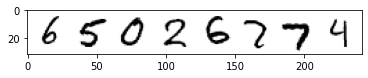

tensor([5, 1, 1, 8, 1, 5, 6, 0, 0, 4], device='cuda:0') tensor([5, 1, 1, 8, 1, 5, 6, 0, 0, 4], device='cuda:0')
tensor(1., device='cuda:0')


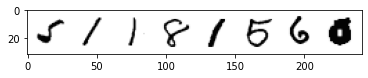

tensor([6, 7, 9, 2, 5, 4, 6, 4, 6, 7], device='cuda:0') tensor([6, 7, 9, 2, 5, 4, 6, 4, 6, 7], device='cuda:0')
tensor(0.9688, device='cuda:0')


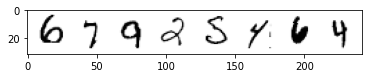

tensor([2, 0, 8, 1, 6, 9, 4, 0, 5, 1], device='cuda:0') tensor([2, 0, 8, 1, 6, 9, 4, 0, 5, 1], device='cuda:0')
tensor(0.9844, device='cuda:0')


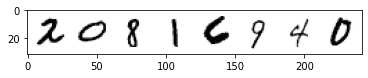

tensor([9, 6, 7, 5, 4, 7, 1, 5, 7, 5], device='cuda:0') tensor([9, 6, 7, 5, 4, 7, 1, 5, 7, 5], device='cuda:0')
tensor(1., device='cuda:0')


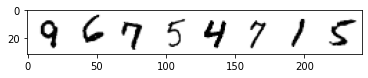

tensor([5, 2, 3, 3, 0, 2, 5, 9, 5, 2], device='cuda:0') tensor([5, 2, 3, 3, 0, 2, 5, 9, 5, 2], device='cuda:0')
tensor(0.9844, device='cuda:0')


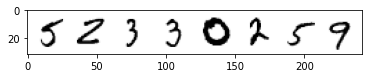

tensor([8, 5, 8, 6, 5, 7, 6, 6, 9, 0], device='cuda:0') tensor([8, 5, 1, 6, 5, 7, 6, 6, 9, 0], device='cuda:0')
tensor(0.9688, device='cuda:0')


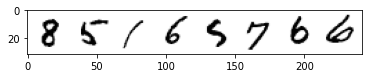

tensor([5, 5, 4, 4, 1, 7, 9, 0, 5, 5], device='cuda:0') tensor([5, 5, 4, 4, 1, 7, 9, 0, 5, 5], device='cuda:0')
tensor(0.9688, device='cuda:0')


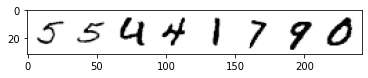

tensor([8, 4, 5, 2, 9, 9, 5, 0, 6, 5], device='cuda:0') tensor([8, 4, 5, 2, 9, 9, 5, 0, 6, 5], device='cuda:0')
tensor(1., device='cuda:0')


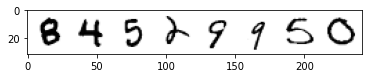

tensor([8, 9, 3, 5, 5, 8, 1, 5, 6, 0], device='cuda:0') tensor([8, 9, 3, 5, 5, 8, 1, 5, 6, 0], device='cuda:0')
tensor(1., device='cuda:0')


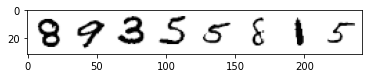

tensor([5, 2, 0, 9, 8, 7, 2, 9, 9, 6], device='cuda:0') tensor([5, 2, 0, 9, 8, 7, 2, 9, 9, 6], device='cuda:0')
tensor(1., device='cuda:0')


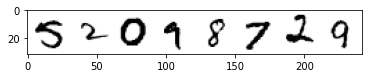

tensor([0, 7, 5, 2, 3, 9, 1, 9, 5, 5], device='cuda:0') tensor([0, 7, 5, 2, 3, 9, 1, 9, 5, 5], device='cuda:0')
tensor(1., device='cuda:0')


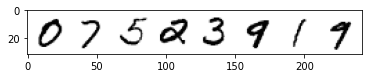

tensor([5, 2, 5, 8, 0, 9, 6, 9, 1, 6], device='cuda:0') tensor([5, 2, 5, 8, 0, 9, 6, 9, 1, 6], device='cuda:0')
tensor(0.9844, device='cuda:0')


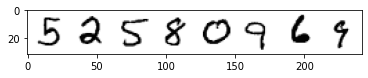

tensor([3, 9, 9, 2, 2, 5, 2, 5, 5, 1], device='cuda:0') tensor([3, 9, 9, 2, 2, 5, 2, 5, 5, 0], device='cuda:0')
tensor(0.9844, device='cuda:0')


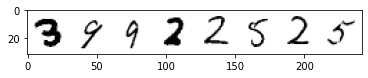

tensor([5, 5, 8, 5, 2, 5, 5, 4, 8, 7], device='cuda:0') tensor([5, 5, 2, 5, 2, 5, 5, 4, 8, 7], device='cuda:0')
tensor(0.9688, device='cuda:0')


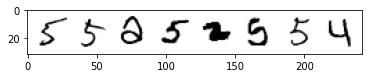

tensor([5, 5, 0, 9, 1, 2, 4, 1, 9, 6], device='cuda:0') tensor([5, 5, 0, 9, 1, 2, 4, 1, 9, 6], device='cuda:0')
tensor(0.9688, device='cuda:0')


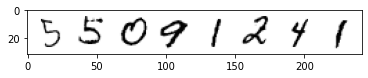

tensor([0, 1, 5, 9, 5, 9, 4, 4, 4, 0], device='cuda:0') tensor([0, 1, 5, 9, 5, 9, 4, 4, 4, 0], device='cuda:0')
tensor(0.9844, device='cuda:0')


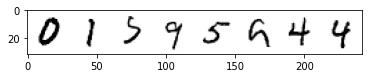

tensor([5, 6, 7, 9, 0, 0, 0, 6, 7, 7], device='cuda:0') tensor([5, 6, 7, 9, 0, 0, 0, 6, 7, 7], device='cuda:0')
tensor(0.9688, device='cuda:0')


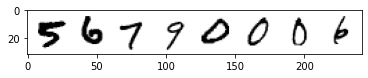

tensor([0, 5, 8, 3, 3, 9, 1, 3, 5, 5], device='cuda:0') tensor([0, 5, 8, 3, 3, 9, 1, 3, 5, 5], device='cuda:0')
tensor(0.9844, device='cuda:0')


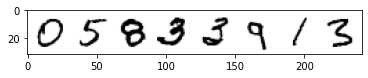

tensor([6, 3, 9, 5, 3, 7, 2, 3, 4, 5], device='cuda:0') tensor([6, 3, 9, 5, 3, 7, 2, 3, 4, 5], device='cuda:0')
tensor(0.9844, device='cuda:0')


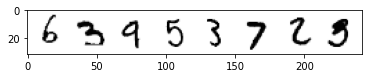

tensor([1, 1, 9, 8, 4, 1, 8, 5, 5, 0], device='cuda:0') tensor([1, 1, 9, 8, 4, 1, 8, 8, 5, 0], device='cuda:0')
tensor(0.9531, device='cuda:0')


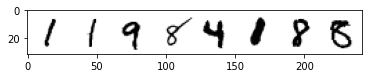

tensor([9, 5, 9, 3, 1, 5, 5, 0, 6, 6], device='cuda:0') tensor([9, 5, 9, 3, 1, 5, 5, 8, 6, 6], device='cuda:0')
tensor(0.9844, device='cuda:0')


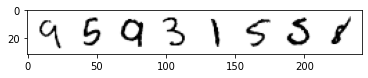

tensor([5, 3, 8, 0, 4, 1, 7, 8, 4, 4], device='cuda:0') tensor([5, 3, 8, 0, 4, 1, 7, 8, 4, 4], device='cuda:0')
tensor(0.9531, device='cuda:0')


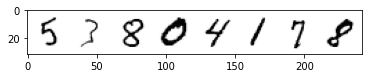

tensor([7, 1, 1, 9, 9, 8, 6, 3, 2, 7], device='cuda:0') tensor([7, 1, 1, 9, 9, 8, 6, 3, 2, 7], device='cuda:0')
tensor(1., device='cuda:0')


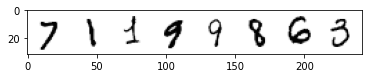

tensor([4, 2, 1, 1, 6, 6, 4, 5, 1, 9], device='cuda:0') tensor([4, 2, 1, 1, 6, 6, 4, 5, 1, 9], device='cuda:0')
tensor(1., device='cuda:0')


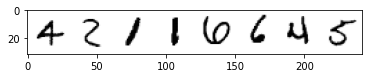

tensor([9, 4, 9, 5, 1, 7, 2, 3, 4, 9], device='cuda:0') tensor([9, 4, 9, 5, 1, 7, 2, 3, 4, 9], device='cuda:0')
tensor(1., device='cuda:0')


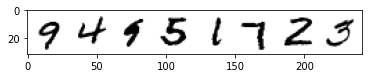

tensor([1, 0, 1, 2, 1, 1, 7, 3, 5, 1], device='cuda:0') tensor([1, 0, 1, 2, 1, 1, 7, 3, 5, 1], device='cuda:0')
tensor(0.9844, device='cuda:0')


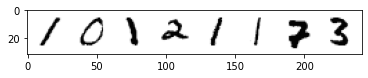

tensor([5, 6, 2, 8, 3, 5, 5, 6, 8, 3], device='cuda:0') tensor([5, 6, 2, 8, 3, 5, 5, 6, 8, 3], device='cuda:0')
tensor(0.9844, device='cuda:0')


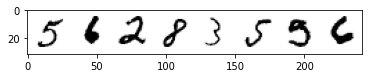

tensor([6, 7, 5, 5, 5, 5, 5, 5, 5, 9], device='cuda:0') tensor([6, 7, 5, 5, 5, 5, 5, 5, 5, 9], device='cuda:0')
tensor(1., device='cuda:0')


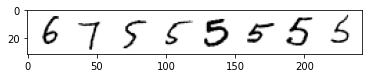

tensor([8, 0, 8, 3, 3, 5, 5, 5, 9, 6], device='cuda:0') tensor([8, 0, 8, 3, 3, 5, 5, 5, 9, 6], device='cuda:0')
tensor(0.9844, device='cuda:0')


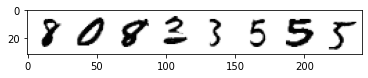

tensor([0, 6, 7, 8, 8, 4, 3, 9, 0, 5], device='cuda:0') tensor([0, 6, 7, 8, 8, 4, 3, 9, 0, 5], device='cuda:0')
tensor(1., device='cuda:0')


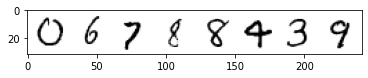

tensor([4, 0, 4, 0, 6, 0, 4, 5, 7, 7], device='cuda:0') tensor([4, 0, 4, 0, 6, 0, 4, 5, 7, 7], device='cuda:0')
tensor(0.9844, device='cuda:0')


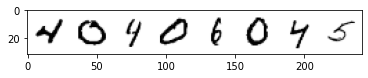

tensor([5, 9, 8, 6, 0, 1, 9, 5, 8, 3], device='cuda:0') tensor([5, 9, 8, 6, 0, 1, 9, 5, 8, 3], device='cuda:0')
tensor(0.9844, device='cuda:0')


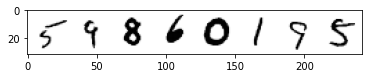

tensor([2, 3, 3, 5, 3, 3, 6, 4, 9, 4], device='cuda:0') tensor([2, 3, 3, 5, 3, 3, 6, 4, 9, 4], device='cuda:0')
tensor(0.9844, device='cuda:0')


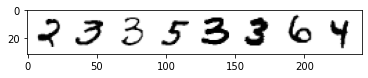

tensor([2, 1, 4, 5, 4, 8, 3, 6, 3, 5], device='cuda:0') tensor([2, 1, 4, 5, 4, 8, 3, 6, 3, 5], device='cuda:0')
tensor(1., device='cuda:0')


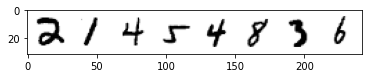

tensor([5, 0, 5, 5, 6, 8, 6, 8, 0, 3], device='cuda:0') tensor([5, 0, 5, 5, 6, 8, 6, 8, 0, 3], device='cuda:0')
tensor(1., device='cuda:0')


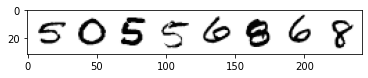

tensor([8, 7, 2, 1, 6, 9, 7, 8, 6, 6], device='cuda:0') tensor([8, 7, 2, 1, 6, 9, 7, 8, 6, 6], device='cuda:0')
tensor(0.9688, device='cuda:0')


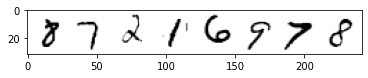

tensor([9, 5, 9, 3, 7, 9, 6, 2, 1, 5], device='cuda:0') tensor([9, 5, 9, 3, 7, 9, 6, 2, 1, 5], device='cuda:0')
tensor(1., device='cuda:0')


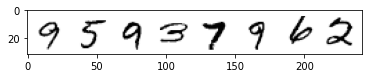

tensor([4, 9, 4, 5, 6, 5, 4, 5, 9, 9], device='cuda:0') tensor([4, 9, 4, 5, 6, 5, 4, 5, 9, 9], device='cuda:0')
tensor(1., device='cuda:0')


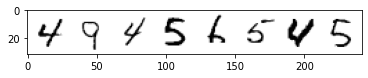

tensor([5, 7, 5, 5, 5, 7, 5, 6, 0, 3], device='cuda:0') tensor([5, 7, 5, 5, 5, 7, 5, 6, 0, 3], device='cuda:0')
tensor(1., device='cuda:0')


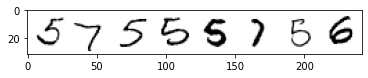

tensor([7, 0, 5, 9, 5, 3, 5, 6, 5, 7], device='cuda:0') tensor([7, 6, 5, 9, 5, 3, 5, 6, 5, 7], device='cuda:0')
tensor(0.9844, device='cuda:0')


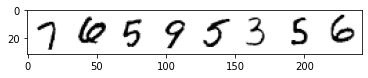

tensor([4, 9, 1, 3, 8, 3, 2, 9, 2, 8], device='cuda:0') tensor([4, 9, 1, 3, 8, 3, 2, 9, 2, 8], device='cuda:0')
tensor(0.9844, device='cuda:0')


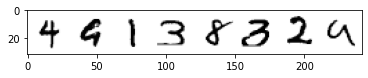

tensor([9, 6, 1, 8, 8, 2, 9, 5, 4, 7], device='cuda:0') tensor([9, 6, 1, 8, 8, 2, 9, 5, 4, 7], device='cuda:0')
tensor(0.9688, device='cuda:0')


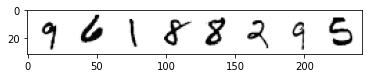

tensor([8, 7, 4, 8, 2, 9, 9, 0, 5, 5], device='cuda:0') tensor([8, 7, 4, 8, 2, 9, 9, 0, 5, 5], device='cuda:0')
tensor(1., device='cuda:0')


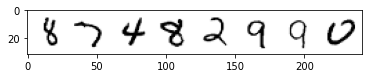

tensor([0, 5, 1, 4, 7, 5, 1, 5, 1, 4], device='cuda:0') tensor([0, 5, 1, 4, 7, 5, 1, 5, 1, 4], device='cuda:0')
tensor(0.9688, device='cuda:0')


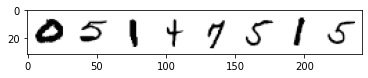

tensor([3, 9, 0, 2, 4, 9, 5, 8, 2, 3], device='cuda:0') tensor([3, 9, 0, 2, 4, 9, 5, 8, 2, 3], device='cuda:0')
tensor(0.9688, device='cuda:0')


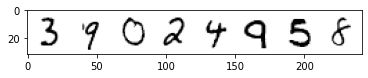

tensor([1, 3, 6, 0, 4, 0, 9, 0, 1, 3], device='cuda:0') tensor([1, 3, 6, 0, 4, 0, 9, 0, 1, 3], device='cuda:0')
tensor(0.9688, device='cuda:0')


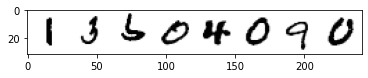

tensor([1, 4, 8, 8, 7, 5, 7, 7, 9, 7], device='cuda:0') tensor([1, 4, 8, 8, 7, 5, 7, 7, 9, 7], device='cuda:0')
tensor(1., device='cuda:0')


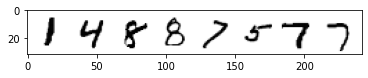

tensor([3, 3, 5, 7, 0, 7, 1, 6, 9, 8], device='cuda:0') tensor([3, 8, 5, 7, 0, 7, 1, 6, 9, 8], device='cuda:0')
tensor(0.9688, device='cuda:0')


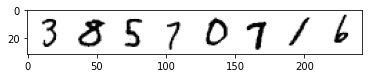

tensor([5, 2, 3, 0, 5, 3, 8, 3, 0, 5], device='cuda:0') tensor([5, 2, 3, 0, 5, 3, 8, 3, 0, 5], device='cuda:0')
tensor(1., device='cuda:0')


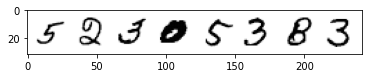

tensor([5, 4, 1, 3, 1, 8, 4, 8, 8, 9], device='cuda:0') tensor([5, 4, 1, 3, 1, 9, 4, 8, 8, 9], device='cuda:0')
tensor(0.9375, device='cuda:0')


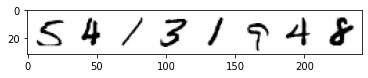

tensor([5, 1, 9, 5, 2, 9, 7, 5, 5, 9], device='cuda:0') tensor([5, 1, 9, 5, 9, 9, 7, 5, 5, 9], device='cuda:0')
tensor(0.9844, device='cuda:0')


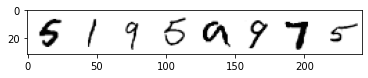

tensor([7, 5, 5, 4, 1, 3, 0, 3, 4, 2], device='cuda:0') tensor([7, 5, 5, 4, 1, 3, 7, 3, 4, 2], device='cuda:0')
tensor(0.9688, device='cuda:0')


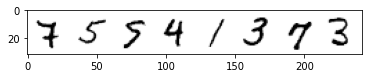

tensor([5, 7, 4, 7, 3, 7, 4, 1, 3, 6], device='cuda:0') tensor([5, 7, 4, 7, 3, 7, 4, 1, 3, 6], device='cuda:0')
tensor(0.9844, device='cuda:0')


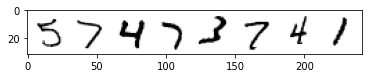

tensor([7, 4, 5, 4, 8, 5, 3, 4, 7, 0], device='cuda:0') tensor([7, 4, 5, 4, 8, 5, 3, 4, 7, 0], device='cuda:0')
tensor(0.9844, device='cuda:0')


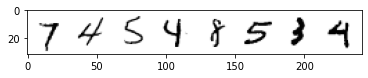

tensor([5, 2, 3, 1, 3, 5, 5, 9, 6, 5], device='cuda:0') tensor([5, 2, 3, 1, 3, 5, 5, 9, 6, 5], device='cuda:0')
tensor(0.9844, device='cuda:0')


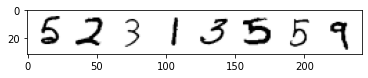

tensor([2, 2, 4, 5, 2, 0, 6, 9, 8, 8], device='cuda:0') tensor([2, 2, 4, 5, 2, 6, 6, 9, 8, 8], device='cuda:0')
tensor(0.9531, device='cuda:0')


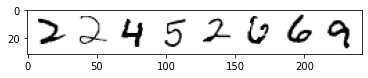

tensor([9, 0, 3, 1, 0, 5, 0, 5, 5, 6], device='cuda:0') tensor([5, 0, 3, 1, 0, 5, 0, 5, 5, 6], device='cuda:0')
tensor(0.9844, device='cuda:0')


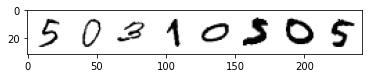

tensor([9, 2, 3, 9, 4, 2, 4, 3, 8, 1], device='cuda:0') tensor([2, 2, 3, 9, 4, 2, 4, 3, 8, 1], device='cuda:0')
tensor(0.9844, device='cuda:0')


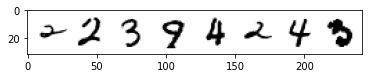

tensor([0, 5, 1, 3, 5, 9, 2, 1, 3, 2], device='cuda:0') tensor([0, 5, 1, 3, 5, 9, 2, 1, 3, 2], device='cuda:0')
tensor(1., device='cuda:0')


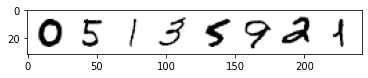

tensor([5, 7, 4, 2, 0, 7, 8, 5, 6, 1], device='cuda:0') tensor([5, 7, 4, 2, 0, 7, 8, 5, 6, 1], device='cuda:0')
tensor(0.9844, device='cuda:0')


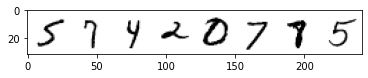

tensor([1, 0, 8, 6, 9, 6, 7, 5, 4, 6], device='cuda:0') tensor([1, 0, 8, 6, 9, 6, 7, 5, 4, 6], device='cuda:0')
tensor(0.9688, device='cuda:0')


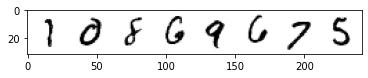

tensor([6, 1, 5, 0, 0, 3, 6, 1, 2, 8], device='cuda:0') tensor([6, 1, 5, 0, 0, 3, 6, 1, 2, 8], device='cuda:0')
tensor(1., device='cuda:0')


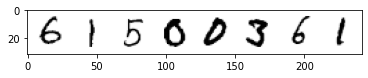

tensor([1, 0, 7, 7, 5, 2, 8, 1, 1, 6], device='cuda:0') tensor([1, 0, 7, 7, 5, 2, 8, 1, 1, 6], device='cuda:0')
tensor(0.9844, device='cuda:0')


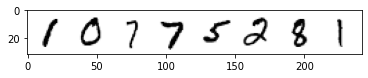

tensor([0, 7, 3, 6, 1, 1, 7, 4, 7, 2], device='cuda:0') tensor([2, 7, 3, 6, 1, 1, 7, 4, 7, 2], device='cuda:0')
tensor(0.9688, device='cuda:0')


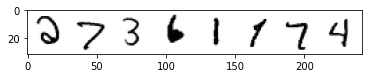

tensor([9, 0, 5, 2, 5, 5, 9, 1, 7, 0], device='cuda:0') tensor([9, 0, 5, 2, 5, 5, 9, 1, 7, 0], device='cuda:0')
tensor(1., device='cuda:0')


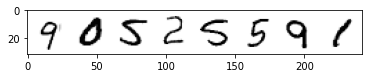

tensor([0, 1, 4, 9, 1, 6, 5, 0, 8, 5], device='cuda:0') tensor([0, 1, 4, 9, 1, 6, 5, 0, 8, 5], device='cuda:0')
tensor(0.9844, device='cuda:0')


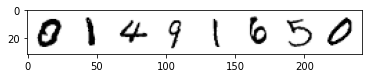

tensor([5, 6, 3, 1, 2, 5, 2, 0, 4, 7], device='cuda:0') tensor([5, 6, 3, 1, 2, 5, 2, 0, 4, 7], device='cuda:0')
tensor(0.9844, device='cuda:0')


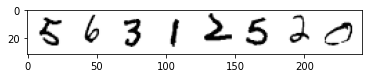

tensor([1, 9, 8, 8, 9, 2, 1, 5, 2, 9], device='cuda:0') tensor([1, 9, 8, 8, 9, 2, 1, 5, 2, 9], device='cuda:0')
tensor(0.9844, device='cuda:0')


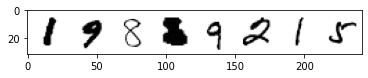

tensor([1, 4, 4, 7, 6, 8, 6, 4, 7, 4], device='cuda:0') tensor([1, 4, 4, 7, 6, 8, 6, 4, 7, 4], device='cuda:0')
tensor(0.9844, device='cuda:0')


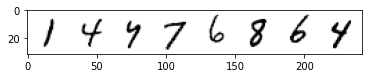

tensor([6, 4, 5, 6, 0, 0, 5, 9, 6, 8], device='cuda:0') tensor([6, 4, 5, 6, 0, 0, 5, 9, 6, 8], device='cuda:0')
tensor(1., device='cuda:0')


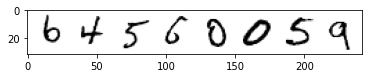

tensor([4, 5, 6, 8, 0, 9, 7, 4, 7, 7], device='cuda:0') tensor([4, 5, 6, 8, 0, 9, 7, 4, 7, 7], device='cuda:0')
tensor(0.9844, device='cuda:0')


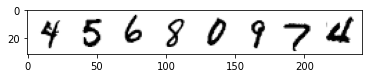

tensor([9, 7, 0, 0, 1, 0, 1, 5, 3, 5], device='cuda:0') tensor([9, 7, 0, 0, 1, 0, 1, 5, 3, 5], device='cuda:0')
tensor(0.9688, device='cuda:0')


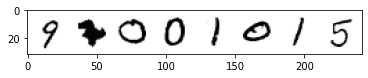

tensor([7, 5, 7, 2, 7, 6, 5, 5, 9, 0], device='cuda:0') tensor([7, 5, 7, 2, 7, 5, 5, 5, 9, 0], device='cuda:0')
tensor(0.9688, device='cuda:0')


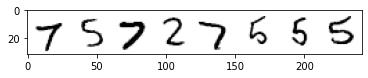

tensor([5, 5, 3, 6, 5, 1, 5, 8, 7, 0], device='cuda:0') tensor([5, 5, 3, 6, 5, 1, 5, 8, 7, 0], device='cuda:0')
tensor(0.9844, device='cuda:0')


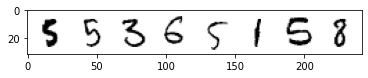

tensor([7, 6, 9, 3, 9, 2, 2, 9, 4, 6], device='cuda:0') tensor([7, 6, 9, 3, 9, 2, 2, 9, 4, 6], device='cuda:0')
tensor(1., device='cuda:0')


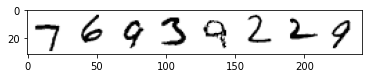

tensor([8, 3, 3, 9, 3, 5, 5, 9, 2, 9], device='cuda:0') tensor([8, 3, 3, 9, 3, 5, 5, 9, 2, 9], device='cuda:0')
tensor(1., device='cuda:0')


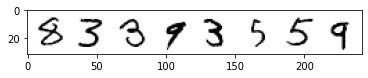

tensor([0, 4, 1, 8, 0, 8, 6, 1, 2, 4], device='cuda:0') tensor([0, 4, 1, 8, 0, 8, 6, 1, 2, 4], device='cuda:0')
tensor(0.9844, device='cuda:0')


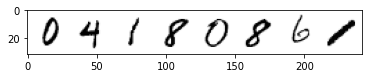

tensor([1, 6, 4, 1, 0, 5, 1, 6, 5, 9], device='cuda:0') tensor([1, 6, 4, 1, 0, 5, 1, 6, 5, 9], device='cuda:0')
tensor(0.9688, device='cuda:0')


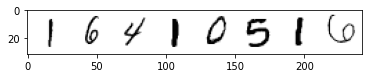

tensor([4, 8, 6, 0, 3, 5, 6, 5, 9, 0], device='cuda:0') tensor([4, 8, 6, 0, 3, 5, 6, 5, 9, 0], device='cuda:0')
tensor(1., device='cuda:0')


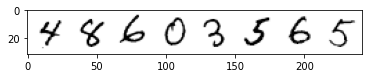

tensor([9, 6, 1, 3, 5, 0, 0, 6, 8, 4], device='cuda:0') tensor([9, 6, 1, 3, 5, 0, 0, 6, 8, 4], device='cuda:0')
tensor(0.9844, device='cuda:0')


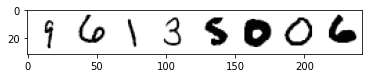

tensor([3, 9, 1, 5, 4, 1, 9, 3, 8, 1], device='cuda:0') tensor([3, 9, 1, 5, 4, 1, 9, 3, 8, 1], device='cuda:0')
tensor(1., device='cuda:0')


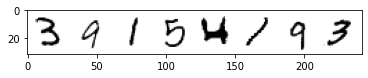

tensor([1, 8, 4, 9, 0, 4, 7, 2, 1, 5], device='cuda:0') tensor([1, 8, 4, 9, 0, 4, 7, 2, 1, 5], device='cuda:0')
tensor(0.9688, device='cuda:0')


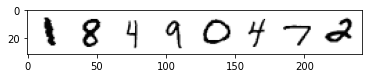

tensor([0, 5, 2, 1, 9, 2, 9, 4, 2, 1], device='cuda:0') tensor([0, 5, 2, 1, 9, 2, 9, 4, 2, 1], device='cuda:0')
tensor(1., device='cuda:0')


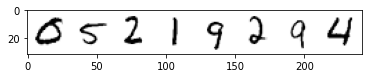

tensor([2, 1, 2, 5, 1, 5, 0, 6, 2, 5], device='cuda:0') tensor([2, 1, 2, 5, 1, 5, 0, 6, 2, 5], device='cuda:0')
tensor(0.9844, device='cuda:0')


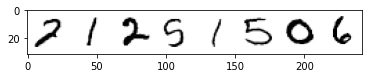

tensor([5, 7, 6, 7, 9, 7, 0, 9, 3, 6], device='cuda:0') tensor([5, 7, 6, 7, 9, 7, 0, 8, 3, 6], device='cuda:0')
tensor(0.9688, device='cuda:0')


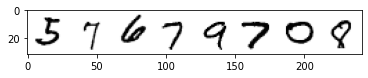

tensor([3, 6, 3, 3, 7, 4, 5, 9, 8, 6], device='cuda:0') tensor([3, 6, 3, 3, 7, 4, 5, 9, 8, 6], device='cuda:0')
tensor(1., device='cuda:0')


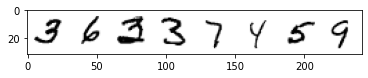

tensor([5, 7, 3, 2, 2, 4, 3, 8, 9, 5], device='cuda:0') tensor([5, 7, 3, 2, 2, 4, 3, 8, 9, 5], device='cuda:0')
tensor(1., device='cuda:0')


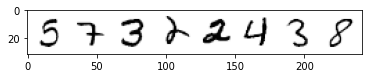

tensor([0, 8, 6, 7, 3, 5, 0, 6, 8, 8], device='cuda:0') tensor([0, 8, 6, 7, 3, 5, 0, 6, 8, 8], device='cuda:0')
tensor(0.9844, device='cuda:0')


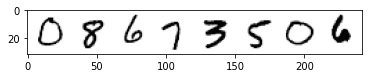

tensor([3, 2, 0, 5, 3, 3, 2, 0, 5, 4], device='cuda:0') tensor([3, 2, 0, 5, 3, 3, 2, 0, 5, 4], device='cuda:0')
tensor(1., device='cuda:0')


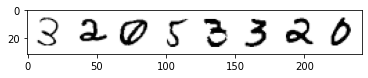

tensor([5, 9, 4, 5, 4, 3, 3, 3, 9, 4], device='cuda:0') tensor([5, 5, 4, 5, 4, 3, 3, 3, 9, 4], device='cuda:0')
tensor(0.9844, device='cuda:0')


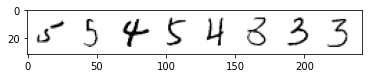

tensor([5, 8, 1, 7, 0, 9, 2, 7, 2, 5], device='cuda:0') tensor([5, 8, 1, 7, 0, 9, 2, 7, 2, 8], device='cuda:0')
tensor(0.9688, device='cuda:0')


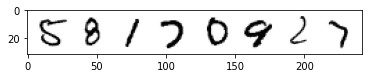

tensor([6, 0, 8, 3, 4, 8, 7, 6, 3, 6], device='cuda:0') tensor([6, 0, 8, 3, 4, 8, 7, 6, 3, 6], device='cuda:0')
tensor(0.9688, device='cuda:0')


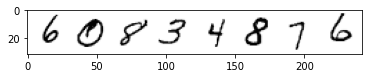

tensor([1, 7, 7, 9, 5, 2, 5, 5, 3, 6], device='cuda:0') tensor([1, 7, 7, 9, 5, 2, 5, 5, 3, 6], device='cuda:0')
tensor(0.9531, device='cuda:0')


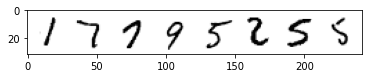

tensor([1, 9, 5, 6, 0, 1, 3, 5, 1, 6], device='cuda:0') tensor([1, 9, 5, 6, 0, 1, 3, 5, 1, 6], device='cuda:0')
tensor(0.9688, device='cuda:0')


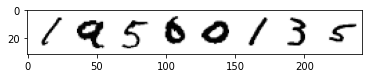

tensor([8, 4, 1, 9, 7, 6, 9, 3, 7, 8], device='cuda:0') tensor([8, 4, 1, 9, 7, 6, 9, 3, 7, 8], device='cuda:0')
tensor(1., device='cuda:0')


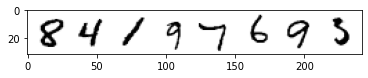

tensor([5, 3, 3, 7, 8, 0, 6, 6, 5, 3], device='cuda:0') tensor([5, 3, 3, 7, 8, 0, 6, 6, 5, 3], device='cuda:0')
tensor(0.9844, device='cuda:0')


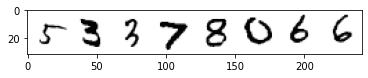

tensor([9, 7, 4, 5, 5, 9, 6, 2, 4, 6], device='cuda:0') tensor([9, 7, 4, 5, 5, 9, 6, 2, 4, 6], device='cuda:0')
tensor(0.9844, device='cuda:0')


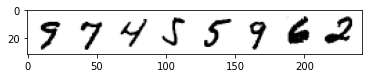

tensor([1, 9, 2, 5, 5, 9, 7, 8, 7, 0], device='cuda:0') tensor([1, 9, 2, 5, 5, 9, 7, 8, 7, 0], device='cuda:0')
tensor(1., device='cuda:0')


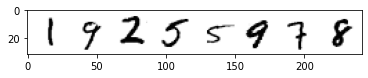

tensor([5, 7, 6, 7, 7, 6, 4, 5, 9, 4], device='cuda:0') tensor([5, 7, 6, 7, 7, 6, 4, 5, 9, 4], device='cuda:0')
tensor(1., device='cuda:0')


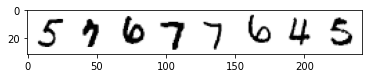

tensor([6, 0, 9, 3, 7, 8, 8, 5, 7, 2], device='cuda:0') tensor([6, 0, 9, 3, 7, 8, 8, 5, 7, 2], device='cuda:0')
tensor(0.9844, device='cuda:0')


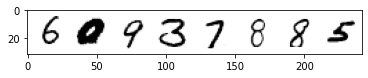

tensor([7, 5, 7, 6, 3, 0, 8, 1, 6, 9], device='cuda:0') tensor([7, 5, 7, 6, 3, 0, 8, 1, 6, 9], device='cuda:0')
tensor(0.9844, device='cuda:0')


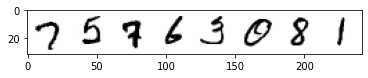

tensor([4, 4, 8, 3, 2, 6, 3, 0, 6, 0], device='cuda:0') tensor([4, 4, 8, 3, 2, 6, 3, 0, 6, 0], device='cuda:0')
tensor(1., device='cuda:0')


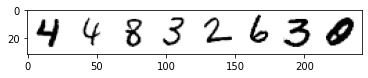

tensor([9, 4, 5, 2, 5, 2, 2, 4, 3, 7], device='cuda:0') tensor([9, 4, 5, 2, 5, 2, 2, 4, 3, 7], device='cuda:0')
tensor(0.9688, device='cuda:0')


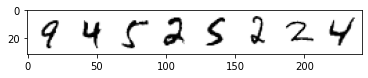

tensor([8, 6, 9, 6, 4, 7, 2, 8, 5, 2], device='cuda:0') tensor([8, 6, 9, 6, 8, 7, 2, 8, 5, 2], device='cuda:0')
tensor(0.9844, device='cuda:0')


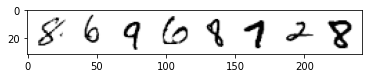

tensor([3, 0, 0, 7, 2, 0, 6, 9, 2, 3], device='cuda:0') tensor([3, 0, 0, 7, 2, 0, 6, 9, 2, 3], device='cuda:0')
tensor(0.9844, device='cuda:0')


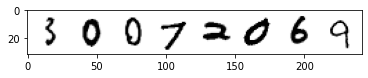

tensor([5, 3, 7, 7, 6, 0, 1, 1, 7, 8], device='cuda:0') tensor([5, 3, 7, 7, 6, 0, 1, 1, 7, 5], device='cuda:0')
tensor(0.9531, device='cuda:0')


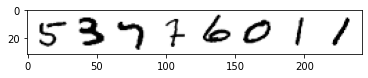

tensor([3, 0, 5, 6, 1, 4, 5, 0, 2, 7], device='cuda:0') tensor([3, 0, 5, 6, 1, 4, 5, 0, 2, 7], device='cuda:0')
tensor(0.9844, device='cuda:0')


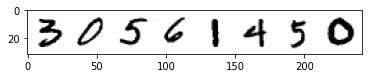

tensor([9, 2, 8, 5, 6, 0, 9, 5, 7, 9], device='cuda:0') tensor([9, 2, 8, 5, 6, 0, 9, 5, 7, 9], device='cuda:0')
tensor(0.9375, device='cuda:0')


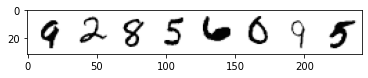

tensor([2, 6, 7, 3, 8, 3, 3, 8, 5, 5], device='cuda:0') tensor([2, 6, 7, 3, 8, 3, 3, 8, 5, 5], device='cuda:0')
tensor(0.9844, device='cuda:0')


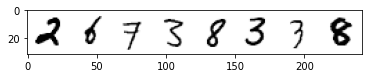

tensor([9, 7, 7, 4, 8, 6, 0, 7, 6, 5], device='cuda:0') tensor([9, 7, 7, 4, 8, 6, 0, 7, 0, 5], device='cuda:0')
tensor(0.9844, device='cuda:0')


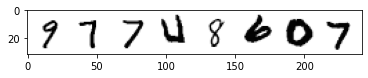

tensor([9, 3, 8, 2, 6, 0, 9, 4, 1, 8], device='cuda:0') tensor([9, 3, 1, 2, 6, 0, 9, 4, 1, 8], device='cuda:0')
tensor(0.9844, device='cuda:0')


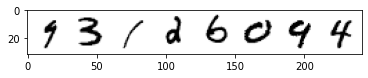

tensor([3, 9, 6, 9, 4, 0, 3, 9, 5, 9], device='cuda:0') tensor([3, 9, 6, 9, 4, 0, 3, 9, 5, 9], device='cuda:0')
tensor(1., device='cuda:0')


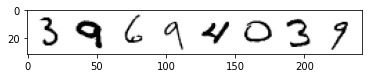

tensor([3, 3, 3, 3, 1, 4, 4, 4, 2, 3], device='cuda:0') tensor([3, 3, 3, 3, 1, 4, 4, 4, 2, 3], device='cuda:0')
tensor(1., device='cuda:0')


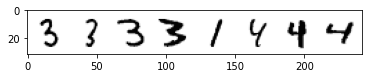

tensor([1, 7, 4, 4, 4, 4, 8, 5, 4, 7], device='cuda:0') tensor([1, 7, 4, 4, 4, 4, 8, 5, 4, 7], device='cuda:0')
tensor(0.9688, device='cuda:0')


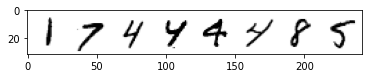

tensor([3, 7, 9, 7, 7, 1, 4, 2, 0, 0], device='cuda:0') tensor([3, 7, 9, 7, 7, 1, 4, 2, 0, 0], device='cuda:0')
tensor(0.9688, device='cuda:0')


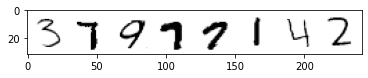

tensor([0, 3, 5, 9, 0, 2, 3, 9, 6, 6], device='cuda:0') tensor([0, 3, 5, 9, 0, 2, 3, 9, 6, 6], device='cuda:0')
tensor(1., device='cuda:0')


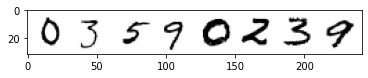

tensor([1, 8, 6, 1, 1, 0, 5, 5, 1, 8], device='cuda:0') tensor([1, 8, 6, 1, 1, 0, 5, 5, 1, 8], device='cuda:0')
tensor(1., device='cuda:0')


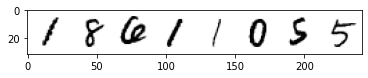

tensor([5, 5, 1, 5, 8, 8, 9, 4, 9, 2], device='cuda:0') tensor([5, 5, 1, 5, 8, 8, 9, 4, 9, 2], device='cuda:0')
tensor(1., device='cuda:0')


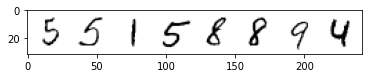

tensor([6, 7, 7, 9, 5, 5, 9, 2, 1, 9], device='cuda:0') tensor([6, 7, 7, 9, 5, 5, 9, 2, 1, 9], device='cuda:0')
tensor(0.9844, device='cuda:0')


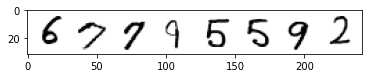

tensor([1, 5, 5, 7, 9, 1, 0, 8, 1, 5], device='cuda:0') tensor([1, 5, 5, 7, 9, 1, 0, 8, 1, 5], device='cuda:0')
tensor(0.9844, device='cuda:0')


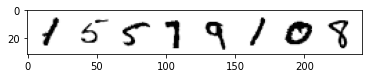

tensor([3, 7, 5, 4, 9, 5, 2, 8, 3, 5], device='cuda:0') tensor([3, 7, 8, 4, 9, 5, 2, 8, 3, 5], device='cuda:0')
tensor(0.9844, device='cuda:0')


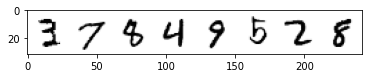

tensor([2, 5, 2, 2, 9, 6, 1, 4, 6, 2], device='cuda:0') tensor([2, 5, 2, 2, 9, 6, 1, 4, 6, 2], device='cuda:0')
tensor(1., device='cuda:0')


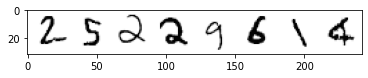

tensor([2, 0, 6, 5, 8, 5, 8, 4, 6, 4], device='cuda:0') tensor([2, 0, 6, 5, 8, 5, 8, 4, 6, 4], device='cuda:0')
tensor(0.9375, device='cuda:0')


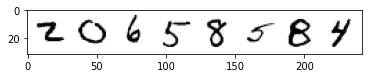

tensor([9, 3, 9, 8, 7, 2, 5, 5, 0, 5], device='cuda:0') tensor([9, 3, 9, 8, 7, 2, 5, 5, 0, 5], device='cuda:0')
tensor(1., device='cuda:0')


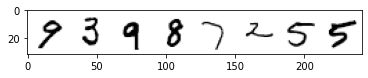

tensor([8, 1, 5, 5, 9, 1, 2, 1, 4, 8], device='cuda:0') tensor([8, 1, 5, 5, 9, 1, 2, 1, 4, 8], device='cuda:0')
tensor(0.9688, device='cuda:0')


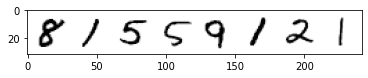

tensor([6, 5, 0, 2, 8, 6, 3, 3, 6, 3], device='cuda:0') tensor([6, 5, 0, 2, 8, 6, 3, 3, 6, 3], device='cuda:0')
tensor(0.9844, device='cuda:0')


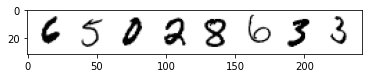

tensor([1, 0, 5, 2, 2, 2, 1, 3, 0, 2], device='cuda:0') tensor([1, 0, 5, 2, 2, 2, 1, 3, 0, 2], device='cuda:0')
tensor(1., device='cuda:0')


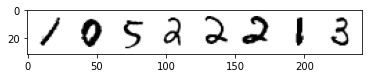

tensor([5, 9, 8, 7, 5, 5, 3, 4, 6, 5], device='cuda:0') tensor([5, 9, 8, 7, 5, 5, 3, 4, 6, 5], device='cuda:0')
tensor(1., device='cuda:0')


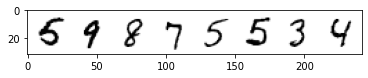

tensor([0, 0, 5, 2, 3, 5, 0, 2, 5, 1], device='cuda:0') tensor([0, 0, 5, 2, 3, 8, 0, 2, 5, 1], device='cuda:0')
tensor(0.9844, device='cuda:0')


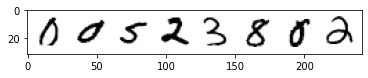

tensor([9, 5, 5, 1, 4, 8, 1, 4, 2, 7], device='cuda:0') tensor([9, 5, 5, 1, 4, 8, 1, 4, 2, 7], device='cuda:0')
tensor(1., device='cuda:0')


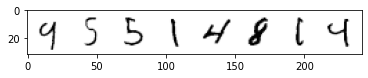

tensor([6, 2, 1, 3, 2, 8, 9, 5, 1, 6], device='cuda:0') tensor([6, 2, 1, 3, 2, 8, 9, 5, 1, 6], device='cuda:0')
tensor(1., device='cuda:0')


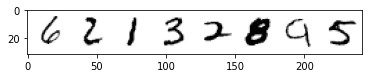

tensor([0, 0, 1, 3, 5, 7, 2, 3, 5, 3], device='cuda:0') tensor([0, 0, 1, 3, 5, 7, 2, 3, 5, 3], device='cuda:0')
tensor(0.9844, device='cuda:0')


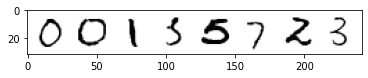

tensor([4, 3, 2, 0, 7, 5, 0, 1, 7, 3], device='cuda:0') tensor([4, 3, 2, 0, 7, 5, 0, 1, 7, 3], device='cuda:0')
tensor(0.9688, device='cuda:0')


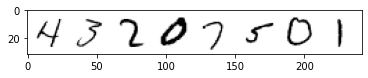

tensor([9, 8, 2, 5, 2, 6, 0, 8, 0, 6], device='cuda:0') tensor([9, 8, 2, 5, 2, 6, 0, 8, 0, 6], device='cuda:0')
tensor(1., device='cuda:0')


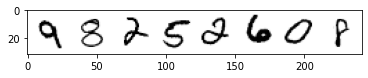

tensor([8, 6, 5, 2, 7, 4, 1, 8, 0, 2], device='cuda:0') tensor([8, 6, 5, 2, 7, 4, 1, 8, 0, 2], device='cuda:0')
tensor(0.9844, device='cuda:0')


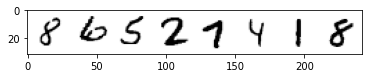

tensor([4, 7, 6, 4, 4, 1, 7, 3, 4, 9], device='cuda:0') tensor([4, 7, 6, 4, 8, 8, 7, 3, 4, 9], device='cuda:0')
tensor(0.9531, device='cuda:0')


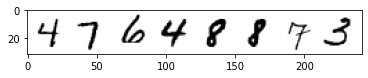

tensor([6, 5, 2, 9, 5, 5, 7, 7, 7, 1], device='cuda:0') tensor([8, 5, 2, 9, 5, 5, 7, 7, 7, 1], device='cuda:0')
tensor(0.9844, device='cuda:0')


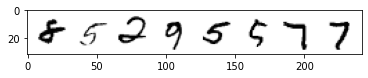

tensor([6, 5, 3, 9, 4, 5, 9, 3, 8, 2], device='cuda:0') tensor([6, 5, 3, 9, 4, 5, 9, 3, 8, 2], device='cuda:0')
tensor(1., device='cuda:0')


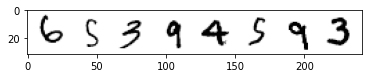

tensor([2, 6, 6, 1, 1, 3, 5, 5, 0, 4], device='cuda:0') tensor([2, 6, 6, 1, 1, 3, 5, 5, 0, 4], device='cuda:0')
tensor(1., device='cuda:0')


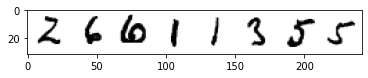

tensor([4, 3, 3, 1, 6, 6, 9, 5, 6, 8], device='cuda:0') tensor([4, 3, 3, 1, 6, 6, 9, 5, 6, 8], device='cuda:0')
tensor(0.9844, device='cuda:0')


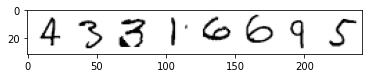

tensor([5, 4, 0, 4, 5, 5, 4, 4, 5, 0], device='cuda:0') tensor([5, 4, 0, 4, 5, 5, 4, 4, 5, 0], device='cuda:0')
tensor(0.9688, device='cuda:0')


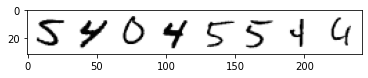

tensor([3, 2, 4, 7, 5, 7, 1, 1, 7, 7], device='cuda:0') tensor([3, 2, 4, 1, 5, 7, 1, 1, 7, 7], device='cuda:0')
tensor(0.9844, device='cuda:0')


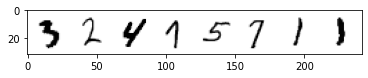

tensor([3, 2, 1, 5, 9, 3, 8, 4, 2, 5], device='cuda:0') tensor([3, 2, 1, 5, 9, 3, 8, 4, 2, 5], device='cuda:0')
tensor(0.9688, device='cuda:0')


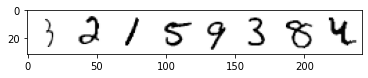

tensor([4, 5, 8, 0, 0, 1, 8, 5, 5, 3], device='cuda:0') tensor([4, 5, 8, 0, 0, 1, 8, 5, 5, 3], device='cuda:0')
tensor(1., device='cuda:0')


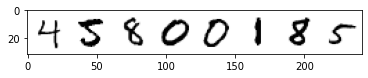

tensor([2, 2, 5, 0, 0, 9, 7, 9, 5, 1], device='cuda:0') tensor([2, 2, 5, 0, 0, 9, 7, 9, 5, 1], device='cuda:0')
tensor(1., device='cuda:0')


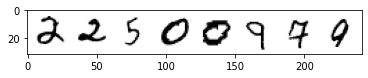

tensor([1, 4, 5, 1, 6, 8, 5, 3, 7, 8], device='cuda:0') tensor([1, 4, 5, 1, 6, 8, 5, 3, 7, 8], device='cuda:0')
tensor(0.9688, device='cuda:0')


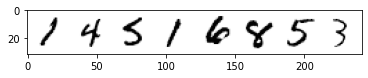

tensor([7, 2, 8, 5, 5, 5, 0, 6, 4, 6], device='cuda:0') tensor([7, 2, 8, 5, 5, 5, 0, 6, 4, 6], device='cuda:0')
tensor(0.9844, device='cuda:0')


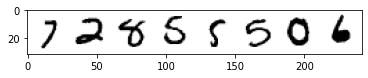

tensor([3, 9, 9, 2, 5, 2, 7, 8, 9, 1], device='cuda:0') tensor([3, 9, 9, 2, 8, 2, 7, 8, 9, 1], device='cuda:0')
tensor(0.9844, device='cuda:0')


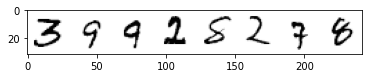

tensor([3, 9, 5, 2, 7, 5, 0, 2, 9, 6], device='cuda:0') tensor([3, 9, 5, 2, 7, 5, 0, 2, 9, 6], device='cuda:0')
tensor(1., device='cuda:0')


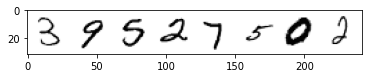

tensor([9, 5, 8, 5, 1, 5, 3, 8, 7, 0], device='cuda:0') tensor([9, 5, 8, 5, 1, 5, 3, 8, 7, 0], device='cuda:0')
tensor(0.9688, device='cuda:0')


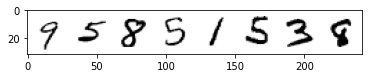

tensor([9, 7, 1, 5, 2, 8, 8, 6, 8, 6], device='cuda:0') tensor([9, 7, 1, 5, 2, 8, 8, 6, 8, 6], device='cuda:0')
tensor(0.9844, device='cuda:0')


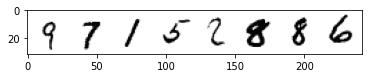

tensor([7, 7, 4, 8, 8, 4, 5, 0, 6, 4], device='cuda:0') tensor([7, 7, 4, 8, 8, 4, 5, 0, 6, 4], device='cuda:0')
tensor(0.9688, device='cuda:0')


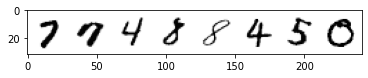

tensor([9, 0, 2, 2, 0, 9, 1, 0, 1, 0], device='cuda:0') tensor([9, 0, 2, 2, 0, 9, 1, 0, 1, 0], device='cuda:0')
tensor(0.9844, device='cuda:0')


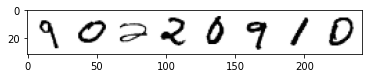

tensor([1, 2, 0, 3, 5, 9, 2, 8, 5, 0], device='cuda:0') tensor([1, 2, 0, 3, 5, 9, 2, 8, 5, 0], device='cuda:0')
tensor(1., device='cuda:0')


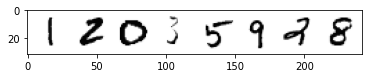

tensor([0, 0, 3, 7, 0, 5, 3, 4, 7, 5], device='cuda:0') tensor([0, 0, 3, 7, 0, 5, 3, 4, 7, 5], device='cuda:0')
tensor(0.9844, device='cuda:0')


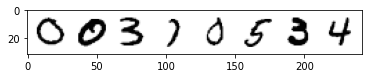

tensor([9, 3, 0, 8, 9, 9, 4, 0, 8, 8], device='cuda:0') tensor([9, 3, 0, 8, 9, 9, 4, 0, 8, 8], device='cuda:0')
tensor(0.9688, device='cuda:0')


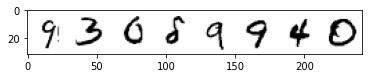

tensor([7, 0, 0, 5, 8, 4, 1, 7, 5, 1], device='cuda:0') tensor([7, 0, 0, 5, 8, 4, 1, 7, 5, 1], device='cuda:0')
tensor(0.9844, device='cuda:0')


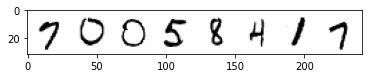

tensor([8, 2, 5, 0, 1, 5, 5, 5, 5, 9], device='cuda:0') tensor([8, 2, 8, 0, 1, 5, 5, 5, 5, 9], device='cuda:0')
tensor(0.9844, device='cuda:0')


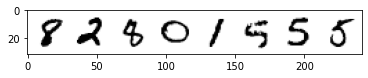

tensor([0, 3, 1, 9, 5, 4, 8, 8, 0, 7], device='cuda:0') tensor([0, 3, 1, 9, 5, 4, 8, 8, 0, 7], device='cuda:0')
tensor(0.9844, device='cuda:0')


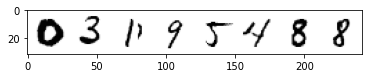

tensor([8, 2, 3, 8, 3, 6, 5, 5, 7, 5], device='cuda:0') tensor([8, 2, 3, 8, 3, 6, 5, 5, 7, 5], device='cuda:0')
tensor(1., device='cuda:0')


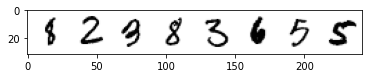

tensor([1, 3, 6, 2, 3, 5, 9, 0, 0, 9], device='cuda:0') tensor([1, 3, 6, 2, 3, 5, 9, 0, 0, 9], device='cuda:0')
tensor(0.9844, device='cuda:0')


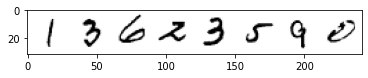

tensor([2, 1, 8, 8, 0, 4, 8, 4, 3, 5], device='cuda:0') tensor([2, 1, 8, 8, 0, 4, 8, 4, 3, 5], device='cuda:0')
tensor(1., device='cuda:0')


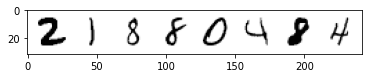

tensor([5, 2, 9, 4, 8, 1, 1, 5, 8, 0], device='cuda:0') tensor([5, 2, 9, 4, 8, 1, 1, 5, 8, 0], device='cuda:0')
tensor(1., device='cuda:0')


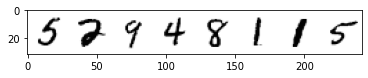

tensor([1, 3, 2, 3, 5, 5, 9, 7, 0, 5], device='cuda:0') tensor([1, 3, 2, 3, 5, 5, 9, 7, 0, 5], device='cuda:0')
tensor(0.9844, device='cuda:0')


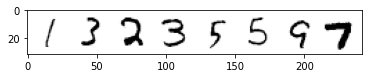

tensor([6, 2, 5, 4, 5, 8, 5, 3, 7, 4], device='cuda:0') tensor([6, 2, 5, 4, 5, 8, 5, 3, 7, 4], device='cuda:0')
tensor(0.9844, device='cuda:0')


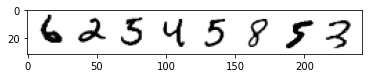

tensor([9, 7, 5, 6, 4, 4, 9, 0, 4, 3], device='cuda:0') tensor([9, 7, 5, 6, 4, 4, 5, 0, 4, 3], device='cuda:0')
tensor(0.9844, device='cuda:0')


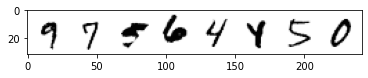

tensor([6, 1, 2, 0, 0, 0, 6, 5, 5, 3], device='cuda:0') tensor([6, 1, 2, 0, 0, 8, 6, 5, 5, 3], device='cuda:0')
tensor(0.9844, device='cuda:0')


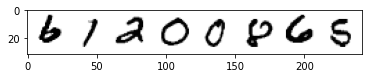

tensor([8, 6, 4, 7, 8, 7, 9, 5, 9, 3], device='cuda:0') tensor([8, 6, 4, 7, 8, 7, 9, 5, 9, 3], device='cuda:0')
tensor(1., device='cuda:0')


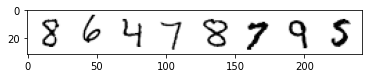

tensor([5, 5, 0, 4, 1, 0, 5, 1, 4, 6], device='cuda:0') tensor([5, 5, 0, 4, 1, 0, 5, 1, 4, 6], device='cuda:0')
tensor(0.9531, device='cuda:0')


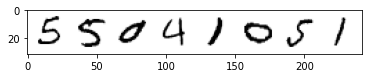

tensor([6, 7, 5, 1, 6, 9, 1, 4, 5, 5], device='cuda:0') tensor([6, 7, 5, 1, 6, 9, 1, 4, 5, 5], device='cuda:0')
tensor(0.9844, device='cuda:0')


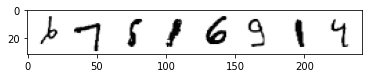

tensor([5, 1, 5, 5, 5, 4, 6, 8, 1, 1], device='cuda:0') tensor([5, 1, 5, 5, 5, 4, 6, 8, 1, 1], device='cuda:0')
tensor(0.9844, device='cuda:0')


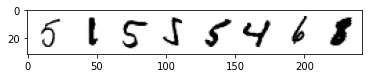

tensor([6, 8, 9, 7, 6, 3, 3, 1, 3, 5], device='cuda:0') tensor([6, 8, 9, 7, 6, 3, 3, 1, 3, 5], device='cuda:0')
tensor(0.9844, device='cuda:0')


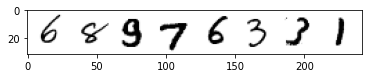

tensor([5, 0, 7, 9, 7, 1, 5, 0, 9, 8], device='cuda:0') tensor([5, 0, 7, 9, 7, 1, 5, 0, 9, 8], device='cuda:0')
tensor(0.9844, device='cuda:0')


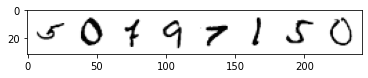

tensor([4, 8, 7, 4, 5, 1, 5, 5, 8, 8], device='cuda:0') tensor([4, 8, 7, 4, 5, 1, 5, 5, 8, 8], device='cuda:0')
tensor(1., device='cuda:0')


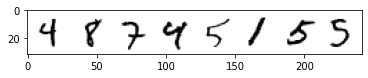

tensor([7, 9, 9, 1, 1, 5, 8, 5, 3, 8], device='cuda:0') tensor([7, 9, 9, 1, 1, 5, 8, 5, 3, 8], device='cuda:0')
tensor(0.9844, device='cuda:0')


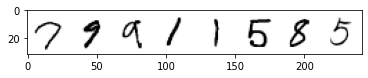

tensor([8, 5, 0, 7, 5, 8, 2, 0, 9, 1], device='cuda:0') tensor([8, 5, 0, 7, 5, 8, 2, 0, 9, 1], device='cuda:0')
tensor(0.9844, device='cuda:0')


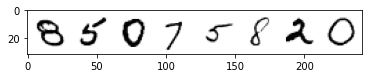

tensor([0, 4, 5, 5, 8, 4, 9, 6, 5, 4], device='cuda:0') tensor([0, 4, 5, 5, 8, 4, 9, 6, 5, 4], device='cuda:0')
tensor(1., device='cuda:0')


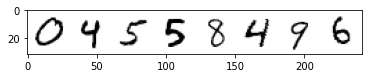

tensor([2, 5, 2, 4, 6, 8, 2, 8, 8, 0], device='cuda:0') tensor([8, 5, 2, 4, 6, 8, 2, 8, 8, 0], device='cuda:0')
tensor(0.9844, device='cuda:0')


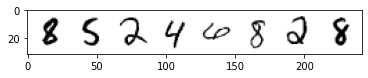

tensor([9, 9, 0, 2, 2, 4, 8, 7, 9, 3], device='cuda:0') tensor([9, 9, 0, 2, 2, 4, 8, 7, 9, 3], device='cuda:0')
tensor(1., device='cuda:0')


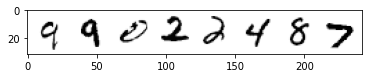

tensor([1, 2, 1, 7, 9, 7, 2, 1, 7, 4], device='cuda:0') tensor([1, 2, 1, 7, 9, 7, 2, 1, 7, 4], device='cuda:0')
tensor(1., device='cuda:0')


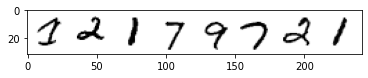

tensor([7, 8, 5, 4, 4, 7, 9, 5, 1, 3], device='cuda:0') tensor([7, 8, 5, 4, 4, 7, 9, 5, 1, 3], device='cuda:0')
tensor(1., device='cuda:0')


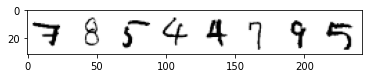

tensor([9, 1, 5, 5, 6, 7, 9, 9, 0, 9], device='cuda:0') tensor([9, 1, 5, 5, 6, 7, 5, 9, 0, 9], device='cuda:0')
tensor(0.9531, device='cuda:0')


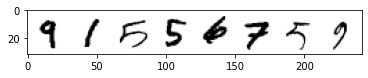

tensor([6, 7, 0, 5, 3, 4, 8, 1, 5, 4], device='cuda:0') tensor([6, 7, 2, 5, 3, 4, 8, 1, 5, 4], device='cuda:0')
tensor(0.9844, device='cuda:0')


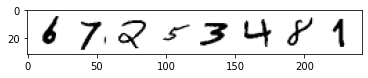

tensor([9, 2, 3, 2, 8, 7, 5, 4, 2, 2], device='cuda:0') tensor([9, 2, 3, 2, 8, 7, 5, 4, 2, 2], device='cuda:0')
tensor(0.9844, device='cuda:0')


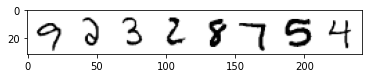

tensor([2, 0, 7, 0, 8, 1, 7, 7, 9, 0], device='cuda:0') tensor([2, 0, 7, 0, 8, 1, 7, 7, 9, 2], device='cuda:0')
tensor(0.9844, device='cuda:0')


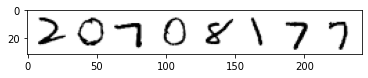

tensor([4, 3, 9, 0, 5, 5, 0, 9, 1, 7], device='cuda:0') tensor([4, 3, 9, 0, 5, 5, 0, 9, 1, 7], device='cuda:0')
tensor(0.9688, device='cuda:0')


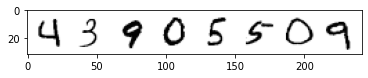

tensor([5, 7, 5, 1, 1, 5, 7, 4, 7, 9], device='cuda:0') tensor([5, 7, 5, 1, 1, 5, 7, 4, 7, 9], device='cuda:0')
tensor(1., device='cuda:0')


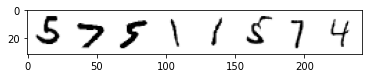

tensor([3, 5, 6, 5, 7, 6, 0, 1, 2, 1], device='cuda:0') tensor([3, 5, 6, 5, 7, 6, 0, 1, 2, 1], device='cuda:0')
tensor(1., device='cuda:0')


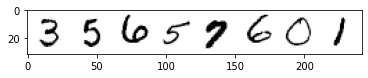

tensor([6, 5, 6, 5, 7, 6, 8, 0, 8, 4], device='cuda:0') tensor([6, 5, 6, 5, 7, 6, 8, 0, 8, 4], device='cuda:0')
tensor(1., device='cuda:0')


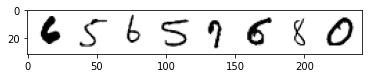

tensor([1, 6, 7, 8, 0, 6, 3, 8, 6, 8], device='cuda:0') tensor([1, 6, 7, 8, 0, 6, 3, 8, 6, 8], device='cuda:0')
tensor(0.9844, device='cuda:0')


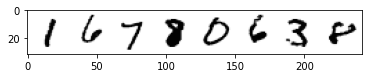

tensor([3, 4, 2, 5, 1, 5, 3, 5, 3, 7], device='cuda:0') tensor([3, 4, 2, 5, 1, 5, 3, 5, 3, 7], device='cuda:0')
tensor(1., device='cuda:0')


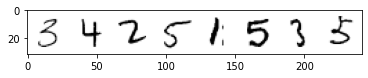

tensor([8, 1, 6, 5, 4, 5, 2, 5, 5, 9], device='cuda:0') tensor([8, 1, 6, 5, 4, 5, 5, 5, 5, 9], device='cuda:0')
tensor(0.9531, device='cuda:0')


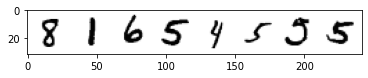

tensor([5, 0, 5, 9, 2, 3, 9, 5, 2, 9], device='cuda:0') tensor([5, 0, 5, 9, 2, 3, 9, 5, 2, 9], device='cuda:0')
tensor(0.9844, device='cuda:0')


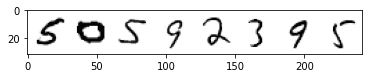

tensor([5, 0, 4, 4, 8, 3, 8, 5, 8, 1], device='cuda:0') tensor([5, 0, 4, 4, 8, 3, 8, 5, 8, 1], device='cuda:0')
tensor(1., device='cuda:0')


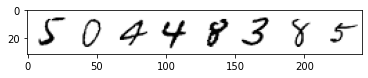

tensor([5, 6, 4, 2, 6, 6, 2, 0, 0, 5], device='cuda:0') tensor([5, 5, 4, 2, 8, 6, 2, 0, 0, 5], device='cuda:0')
tensor(0.9531, device='cuda:0')


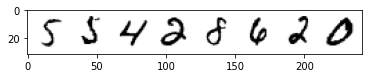

tensor([3, 6, 5, 6, 5, 9, 5, 5, 3, 2], device='cuda:0') tensor([3, 6, 5, 6, 5, 9, 5, 5, 3, 2], device='cuda:0')
tensor(0.9844, device='cuda:0')


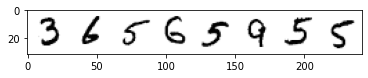

tensor([4, 1, 7, 9, 8, 7, 5, 5, 1, 7], device='cuda:0') tensor([4, 1, 7, 9, 8, 7, 5, 5, 1, 7], device='cuda:0')
tensor(0.9844, device='cuda:0')


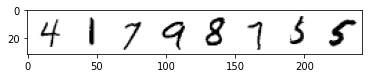

tensor([1, 5, 6, 5, 8, 4, 4, 5, 0, 2], device='cuda:0') tensor([1, 5, 6, 5, 8, 4, 4, 5, 0, 2], device='cuda:0')
tensor(0.9688, device='cuda:0')


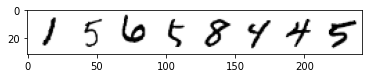

tensor([4, 1, 9, 1, 4, 9, 5, 0, 0, 7], device='cuda:0') tensor([4, 1, 9, 1, 4, 9, 5, 0, 0, 7], device='cuda:0')
tensor(1., device='cuda:0')


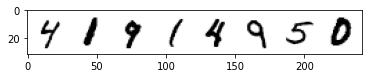

tensor([3, 3, 5, 0, 4, 6, 5, 5, 5, 2], device='cuda:0') tensor([3, 3, 5, 0, 4, 6, 5, 5, 5, 2], device='cuda:0')
tensor(1., device='cuda:0')


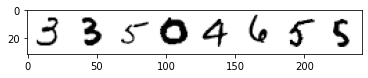

tensor([2, 0, 4, 1, 4, 7, 0, 3, 5, 7], device='cuda:0') tensor([2, 0, 4, 1, 4, 7, 0, 3, 5, 7], device='cuda:0')
tensor(1., device='cuda:0')


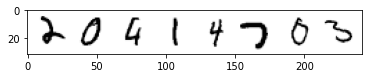

tensor([6, 0, 7, 5, 4, 5, 5, 9, 0, 4], device='cuda:0') tensor([6, 0, 7, 5, 4, 5, 5, 9, 0, 4], device='cuda:0')
tensor(0.9844, device='cuda:0')


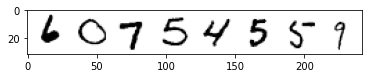

tensor([4, 5, 7, 2, 3, 3, 5, 6, 8, 5], device='cuda:0') tensor([4, 5, 7, 2, 3, 3, 5, 6, 8, 5], device='cuda:0')
tensor(0.9844, device='cuda:0')


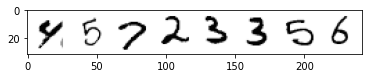

tensor([8, 0, 6, 1, 3, 0, 7, 9, 8, 8], device='cuda:0') tensor([8, 0, 6, 1, 3, 0, 7, 9, 8, 8], device='cuda:0')
tensor(1., device='cuda:0')


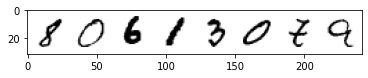

tensor([9, 5, 3, 4, 1, 5, 1, 6, 7, 3], device='cuda:0') tensor([9, 5, 3, 4, 1, 5, 1, 6, 7, 3], device='cuda:0')
tensor(0.9688, device='cuda:0')


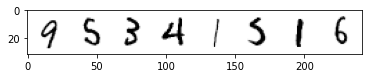

tensor([5, 0, 1, 0, 2, 0, 5, 2, 4, 8], device='cuda:0') tensor([5, 0, 1, 0, 2, 0, 5, 2, 4, 8], device='cuda:0')
tensor(1., device='cuda:0')


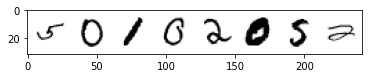

tensor([6, 5, 9, 3, 9, 1, 5, 4, 8, 6], device='cuda:0') tensor([6, 5, 9, 3, 9, 1, 5, 4, 8, 6], device='cuda:0')
tensor(1., device='cuda:0')


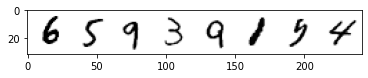

tensor([0, 9, 4, 6, 3, 6, 5, 5, 8, 5], device='cuda:0') tensor([0, 9, 4, 6, 3, 6, 5, 5, 8, 5], device='cuda:0')
tensor(1., device='cuda:0')


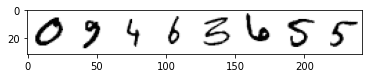

tensor([6, 1, 3, 6, 5, 5, 7, 3, 4, 5], device='cuda:0') tensor([6, 1, 3, 6, 5, 5, 7, 3, 4, 5], device='cuda:0')
tensor(1., device='cuda:0')


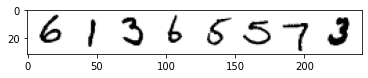

tensor([3, 7, 8, 0, 3, 2, 7, 5, 2, 5], device='cuda:0') tensor([3, 7, 8, 0, 3, 2, 7, 5, 2, 5], device='cuda:0')
tensor(1., device='cuda:0')


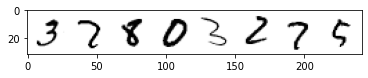

tensor([6, 7, 0, 0, 8, 3, 5, 3, 5, 3], device='cuda:0') tensor([6, 7, 0, 0, 8, 3, 5, 3, 5, 3], device='cuda:0')
tensor(0.9688, device='cuda:0')


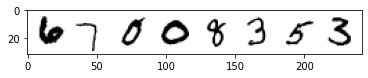

tensor([4, 9, 9, 2, 1, 3, 7, 5, 8, 0], device='cuda:0') tensor([4, 9, 9, 2, 1, 3, 7, 5, 8, 0], device='cuda:0')
tensor(1., device='cuda:0')


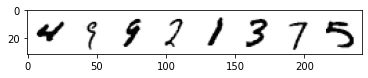

tensor([7, 2, 9, 6, 8, 7, 7, 2, 6, 4], device='cuda:0') tensor([7, 2, 9, 6, 8, 7, 7, 2, 6, 4], device='cuda:0')
tensor(0.9844, device='cuda:0')


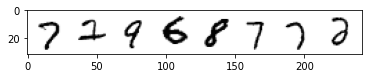

tensor([0, 8, 2, 1, 9, 5, 5, 9, 1, 8], device='cuda:0') tensor([0, 8, 2, 1, 9, 5, 5, 9, 1, 8], device='cuda:0')
tensor(0.9844, device='cuda:0')


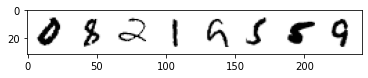

tensor([5, 8, 3, 4, 2, 5, 5, 3, 2, 7], device='cuda:0') tensor([5, 8, 3, 4, 2, 5, 5, 3, 2, 7], device='cuda:0')
tensor(0.9688, device='cuda:0')


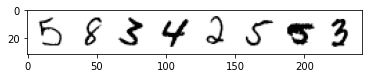

tensor([8, 0, 7, 3, 5, 4, 3, 4, 3, 0], device='cuda:0') tensor([8, 0, 7, 3, 5, 4, 3, 4, 3, 0], device='cuda:0')
tensor(0.9688, device='cuda:0')


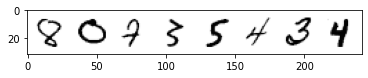

tensor([1, 9, 0, 0, 6, 6, 9, 1, 4, 5], device='cuda:0') tensor([1, 9, 0, 0, 6, 6, 9, 1, 4, 5], device='cuda:0')
tensor(1., device='cuda:0')


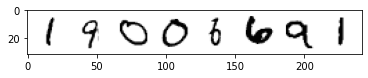

tensor([9, 4, 9, 6, 2, 5, 8, 4, 3, 1], device='cuda:0') tensor([9, 4, 9, 6, 2, 5, 8, 4, 3, 1], device='cuda:0')
tensor(1., device='cuda:0')


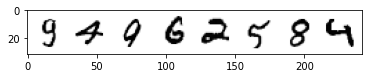

tensor([4, 0, 1, 7, 7, 4, 2, 4, 6, 0], device='cuda:0') tensor([4, 0, 1, 7, 7, 4, 2, 4, 6, 0], device='cuda:0')
tensor(0.9688, device='cuda:0')


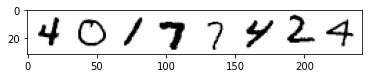

tensor([0, 8, 1, 0, 0, 0, 7, 2, 5, 1], device='cuda:0') tensor([0, 8, 1, 0, 0, 0, 7, 2, 5, 1], device='cuda:0')
tensor(1., device='cuda:0')


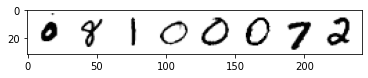

tensor([7, 7, 2, 2, 2, 2, 9, 5, 0, 5], device='cuda:0') tensor([7, 7, 2, 2, 2, 2, 9, 5, 0, 5], device='cuda:0')
tensor(1., device='cuda:0')


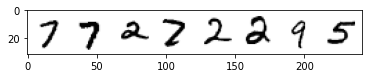

tensor([2, 1, 4, 8, 7, 7, 8, 1, 8, 5], device='cuda:0') tensor([2, 1, 4, 8, 7, 7, 8, 1, 8, 5], device='cuda:0')
tensor(1., device='cuda:0')


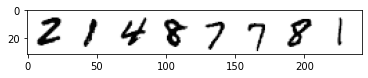

tensor([5, 6, 6, 7, 0, 8, 5, 6, 4, 1], device='cuda:0') tensor([5, 6, 6, 7, 0, 8, 5, 6, 4, 1], device='cuda:0')
tensor(0.9844, device='cuda:0')


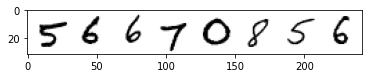

tensor([7, 3, 1, 5, 0, 3, 5, 6, 0, 9], device='cuda:0') tensor([7, 3, 1, 5, 0, 3, 5, 6, 0, 9], device='cuda:0')
tensor(1., device='cuda:0')


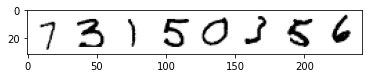

tensor([8, 2, 7, 3, 9, 3, 4, 3, 8, 3], device='cuda:0') tensor([8, 2, 7, 3, 9, 3, 4, 3, 8, 3], device='cuda:0')
tensor(1., device='cuda:0')


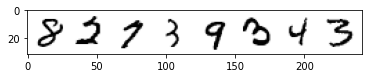

tensor([8, 3, 4, 5, 4, 0, 5, 6, 4, 7], device='cuda:0') tensor([8, 3, 4, 5, 4, 0, 5, 6, 4, 7], device='cuda:0')
tensor(1., device='cuda:0')


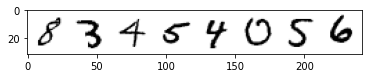

tensor([9, 8, 5, 8, 1, 8, 4, 3, 1, 2], device='cuda:0') tensor([9, 8, 5, 8, 1, 8, 4, 3, 1, 2], device='cuda:0')
tensor(0.9844, device='cuda:0')


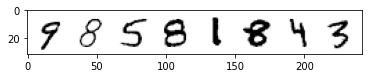

tensor([0, 5, 5, 6, 8, 6, 9, 5, 2, 0], device='cuda:0') tensor([0, 5, 5, 6, 8, 6, 9, 5, 2, 0], device='cuda:0')
tensor(0.9844, device='cuda:0')


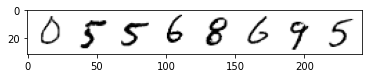

tensor([9, 0, 2, 8, 0, 4, 5, 2, 5, 2], device='cuda:0') tensor([9, 0, 2, 8, 0, 4, 5, 2, 5, 2], device='cuda:0')
tensor(0.9844, device='cuda:0')


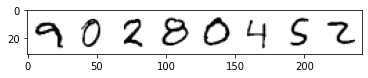

tensor([1, 1, 8, 3, 8, 3, 5, 7, 3, 7], device='cuda:0') tensor([1, 1, 8, 3, 8, 3, 5, 7, 3, 7], device='cuda:0')
tensor(0.9844, device='cuda:0')


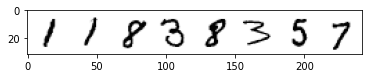

tensor([3, 4, 0, 2, 2, 5, 0, 5, 6, 0], device='cuda:0') tensor([3, 4, 0, 2, 2, 5, 0, 5, 6, 0], device='cuda:0')
tensor(0.9844, device='cuda:0')


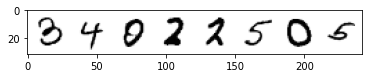

tensor([5, 0, 9, 6, 1, 8, 7, 7, 7, 3], device='cuda:0') tensor([5, 8, 9, 6, 1, 8, 7, 7, 7, 3], device='cuda:0')
tensor(0.9531, device='cuda:0')


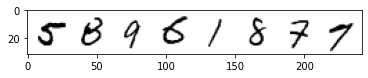

tensor([7, 4, 0, 3, 2, 6, 0, 6, 4, 9], device='cuda:0') tensor([7, 4, 0, 3, 2, 6, 0, 6, 4, 9], device='cuda:0')
tensor(0.9844, device='cuda:0')


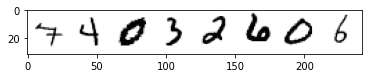

tensor([5, 9, 2, 6, 4, 2, 3, 8, 7, 6], device='cuda:0') tensor([5, 9, 2, 6, 4, 2, 3, 8, 7, 6], device='cuda:0')
tensor(0.9688, device='cuda:0')


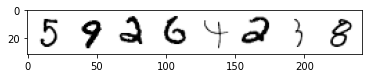

tensor([3, 1, 6, 4, 1, 8, 1, 8, 4, 0], device='cuda:0') tensor([3, 1, 6, 4, 1, 8, 1, 8, 4, 0], device='cuda:0')
tensor(0.9844, device='cuda:0')


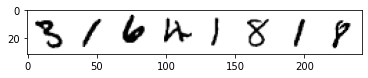

tensor([0, 6, 3, 5, 7, 7, 0, 2, 9, 6], device='cuda:0') tensor([0, 6, 3, 5, 7, 7, 0, 2, 9, 6], device='cuda:0')
tensor(0.9844, device='cuda:0')


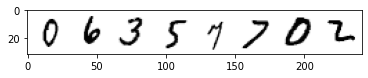

tensor([8, 4, 5, 0, 4, 6, 4, 0, 9, 8], device='cuda:0') tensor([8, 4, 5, 0, 4, 6, 4, 2, 9, 8], device='cuda:0')
tensor(0.9688, device='cuda:0')


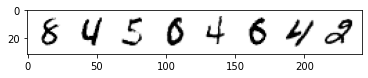

tensor([9, 8, 0, 5, 6, 1, 1, 5, 3, 1], device='cuda:0') tensor([9, 8, 0, 5, 6, 1, 8, 5, 3, 1], device='cuda:0')
tensor(0.9423, device='cuda:0')


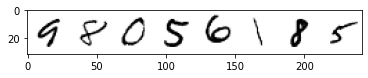

In [250]:
w_importance = 0 
T = 1.1
plot_file = generate_plot_file(model_1, w_importance,'temp_'+"{:.1f}".format(T)+'_'+str(num_classes)+'_'+str(total_experts)+'_models.pt')

model = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)[0]

for images, labels in imbalanced_trainloader:
    images, labels = images.to(device), labels.to(device)
    for e_key, e_val in model.items():
        moe_model = e_val['experts'][total_experts]['model']
        pred_probs = moe_model(images)
        pred_labels = torch.argmax(pred_probs, dim=1)
        print(pred_labels[0:10], labels[0:10])
        print(accuracy(pred_probs, labels))

        img_grid = torchvision.utils.make_grid(images[0:8].view(-1, 1, 28, 28).type(torch.float))
        imshow(img_grid, one_channel=True)
        plt.show()
# for images, labels in trainloader:
#     images, labels = images.to(device), labels.to(device)
#     pred_probs = moe_model(images)
#     pred_labels = torch.argmax(pred_probs, dim=1)
#     print(pred_labels[0:10], labels[0:10])
#     print(accuracy(pred_probs, labels))

#     img_grid = torchvision.utils.make_grid(images[0:8].view(-1, 1, 28, 28).type(torch.float))
#     imshow(img_grid, one_channel=True)
#     plt.show()
#     break

### Combined rotated and unrotated MNIST data

In [95]:
# Model with gate and expert parameters initialized to default values
model_1 = 'rot_mnist_dual_temp'

In [96]:
total_experts = 5

In [97]:
num_epochs = 20

In [98]:
temps = np.concatenate((np.arange(1.1,1.6,0.1), np.arange(0.9,0.4,-0.1)))
temps

array([1.1, 1.2, 1.3, 1.4, 1.5, 0.9, 0.8, 0.7, 0.6, 0.5])

In [99]:
runs = 10

In [100]:
train_dual_temp_model(model_1, rot_unrot_trainloader, rot_unrot_testloader, runs, temps, num_classes, total_experts, num_epochs)

Temperature 1.1
Run: 0
epoch 0 training loss 1.22 , training accuracy 0.60 , test accuracy 0.85
epoch 1 training loss 0.29 , training accuracy 0.92 , test accuracy 0.92
epoch 2 training loss 0.19 , training accuracy 0.95 , test accuracy 0.94
epoch 3 training loss 0.15 , training accuracy 0.96 , test accuracy 0.95
epoch 4 training loss 0.12 , training accuracy 0.96 , test accuracy 0.95
epoch 5 training loss 0.11 , training accuracy 0.97 , test accuracy 0.95
epoch 6 training loss 0.10 , training accuracy 0.97 , test accuracy 0.95
epoch 7 training loss 0.09 , training accuracy 0.97 , test accuracy 0.95
epoch 8 training loss 0.08 , training accuracy 0.98 , test accuracy 0.96
epoch 9 training loss 0.08 , training accuracy 0.98 , test accuracy 0.95
epoch 10 training loss 0.07 , training accuracy 0.98 , test accuracy 0.96
epoch 11 training loss 0.07 , training accuracy 0.98 , test accuracy 0.95
epoch 12 training loss 0.06 , training accuracy 0.98 , test accuracy 0.96
epoch 13 training loss 0.

### Combined FMNIST MNIST data

In [48]:
# Model with gate and expert parameters initialized to default values
model_1 = 'fmnist_mnist_dual_temp'

In [49]:
total_experts = 6

In [50]:
num_epochs = 20

In [51]:
temps = np.concatenate((np.arange(1.2,1.6,0.1), np.arange(0.9,0.4,-0.1)))
temps

array([1.2, 1.3, 1.4, 1.5, 1.6, 0.9, 0.8, 0.7, 0.6, 0.5])

In [52]:
runs = 10

In [53]:
train_dual_temp_model(model_1, fmnist_mnist_trainloader, fmnist_mnist_testloader, runs, temps, num_classes_fmnist_mnist, total_experts, num_epochs)

Temperature 1.2
Run: 0
epoch 0 training loss 1.35 , training accuracy 0.52 , test accuracy 0.72
epoch 1 training loss 0.54 , training accuracy 0.81 , test accuracy 0.78
epoch 2 training loss 0.41 , training accuracy 0.85 , test accuracy 0.84
epoch 3 training loss 0.37 , training accuracy 0.87 , test accuracy 0.85
epoch 4 training loss 0.33 , training accuracy 0.89 , test accuracy 0.87
epoch 5 training loss 0.32 , training accuracy 0.90 , test accuracy 0.87
epoch 6 training loss 0.29 , training accuracy 0.90 , test accuracy 0.87
epoch 7 training loss 0.29 , training accuracy 0.91 , test accuracy 0.86
epoch 8 training loss 0.28 , training accuracy 0.91 , test accuracy 0.88
epoch 9 training loss 0.26 , training accuracy 0.92 , test accuracy 0.88
epoch 10 training loss 0.25 , training accuracy 0.92 , test accuracy 0.89
epoch 11 training loss 0.25 , training accuracy 0.92 , test accuracy 0.89
epoch 12 training loss 0.23 , training accuracy 0.92 , test accuracy 0.88
epoch 13 training loss 0.

## Experiment 2: MoE model training with gate regularization

### MNIST data

In [54]:
# Model with gate and expert parameters initialized to default values
model_2 = 'mnist_with_regularization'

In [55]:
total_experts = 5

In [56]:
num_epochs = 20

In [57]:
w_importance_range = [i * 0.2 for i in range(1, 6)]
w_importance_range

[0.2, 0.4, 0.6000000000000001, 0.8, 1.0]

In [58]:
runs = 10

In [59]:
train_with_regularization(model_2, trainloader, testloader, runs, w_importance_range, num_classes, total_experts, num_epochs)

w_importance 0.2
Run: 0
Model: moe_expectation_model 5 Experts
model params: 31772
epoch 0 training loss 1.55 , training accuracy 0.52 , test accuracy 0.76
epoch 1 training loss 0.54 , training accuracy 0.87 , test accuracy 0.84
epoch 2 training loss 0.41 , training accuracy 0.91 , test accuracy 0.86
epoch 3 training loss 0.34 , training accuracy 0.93 , test accuracy 0.90
epoch 4 training loss 0.29 , training accuracy 0.94 , test accuracy 0.90
epoch 5 training loss 0.25 , training accuracy 0.95 , test accuracy 0.91
epoch 6 training loss 0.22 , training accuracy 0.96 , test accuracy 0.91
epoch 7 training loss 0.20 , training accuracy 0.96 , test accuracy 0.93
epoch 8 training loss 0.19 , training accuracy 0.97 , test accuracy 0.92
epoch 9 training loss 0.17 , training accuracy 0.97 , test accuracy 0.93
epoch 10 training loss 0.16 , training accuracy 0.97 , test accuracy 0.93
epoch 11 training loss 0.15 , training accuracy 0.98 , test accuracy 0.92
epoch 12 training loss 0.14 , training 

### MNIST imbalanced data

In [60]:
# Model with gate and expert parameters initialized to default values
model_2 = 'mnist_imbalanced_5_with_regularization'

In [61]:
total_experts = 5

In [62]:
num_epochs = 20

In [63]:
w_importance_range = [i * 0.2 for i in range(1, 6)]
w_importance_range 

[0.2, 0.4, 0.6000000000000001, 0.8, 1.0]

In [64]:
runs = 10

In [65]:
train_with_regularization(model_2, imbalanced_trainloader, testloader, runs, w_importance_range, num_classes, total_experts, num_epochs)

w_importance 0.2
Run: 0
Model: moe_expectation_model 5 Experts
model params: 31772
epoch 0 training loss 0.53 , training accuracy 0.87 , test accuracy 0.11
epoch 1 training loss 0.20 , training accuracy 0.96 , test accuracy 0.11
epoch 2 training loss 0.15 , training accuracy 0.97 , test accuracy 0.11
epoch 3 training loss 0.13 , training accuracy 0.98 , test accuracy 0.11
epoch 4 training loss 0.12 , training accuracy 0.98 , test accuracy 0.11
epoch 5 training loss 0.11 , training accuracy 0.99 , test accuracy 0.11
epoch 6 training loss 0.11 , training accuracy 0.99 , test accuracy 0.11
epoch 7 training loss 0.10 , training accuracy 0.99 , test accuracy 0.11
epoch 8 training loss 0.09 , training accuracy 0.99 , test accuracy 0.11
epoch 9 training loss 0.10 , training accuracy 0.99 , test accuracy 0.11
epoch 10 training loss 0.09 , training accuracy 0.99 , test accuracy 0.11
epoch 11 training loss 0.09 , training accuracy 0.99 , test accuracy 0.11
epoch 12 training loss 0.09 , training 

### Combined rotated and unrotated MNIST data

In [66]:
# Model with gate and expert parameters initialized to default values
model_2 = 'rot_mnist_with_regularization'

In [67]:
total_experts = 5

In [68]:
num_epochs = 20

In [69]:
w_importance_range = [i * 0.2 for i in range(1, 6)]
w_importance_range

[0.2, 0.4, 0.6000000000000001, 0.8, 1.0]

In [70]:
runs = 10

In [71]:
train_with_regularization(model_2, rot_unrot_trainloader, rot_unrot_testloader, runs, w_importance_range, num_classes, total_experts, num_epochs)

w_importance 0.2
Run: 0
Model: moe_expectation_model 5 Experts
model params: 31772
epoch 0 training loss 1.56 , training accuracy 0.52 , test accuracy 0.73
epoch 1 training loss 0.53 , training accuracy 0.86 , test accuracy 0.86
epoch 2 training loss 0.36 , training accuracy 0.91 , test accuracy 0.91
epoch 3 training loss 0.28 , training accuracy 0.93 , test accuracy 0.91
epoch 4 training loss 0.24 , training accuracy 0.94 , test accuracy 0.93
epoch 5 training loss 0.20 , training accuracy 0.95 , test accuracy 0.89
epoch 6 training loss 0.18 , training accuracy 0.95 , test accuracy 0.94
epoch 7 training loss 0.17 , training accuracy 0.96 , test accuracy 0.93
epoch 8 training loss 0.16 , training accuracy 0.96 , test accuracy 0.94
epoch 9 training loss 0.14 , training accuracy 0.96 , test accuracy 0.95
epoch 10 training loss 0.13 , training accuracy 0.97 , test accuracy 0.95
epoch 11 training loss 0.12 , training accuracy 0.97 , test accuracy 0.95
epoch 12 training loss 0.12 , training 

### Combined FMNIST MNIST data

In [48]:
# Model with gate and expert parameters initialized to default values
model_2 = 'fmnist_mnist_with_regularization'

In [49]:
total_experts = 6

In [50]:
num_epochs = 20

In [51]:
w_importance_range = [i * 0.2 for i in range(1, 6)]
w_importance_range = [1.0]
w_importance_range

[1.0]

In [52]:
runs = 10

In [53]:
train_with_regularization(model_2, fmnist_mnist_trainloader, fmnist_mnist_testloader, runs, w_importance_range, num_classes_fmnist_mnist, total_experts, num_epochs)

w_importance 1.0
Run: 0
Model: moe_expectation_model 6 Experts
model params: 32890
epoch 0 training loss 1.85 , training accuracy 0.47 , test accuracy 0.71
epoch 1 training loss 0.71 , training accuracy 0.80 , test accuracy 0.81
epoch 2 training loss 0.54 , training accuracy 0.85 , test accuracy 0.83
epoch 3 training loss 0.47 , training accuracy 0.88 , test accuracy 0.85
epoch 4 training loss 0.44 , training accuracy 0.89 , test accuracy 0.87
epoch 5 training loss 0.40 , training accuracy 0.90 , test accuracy 0.88
epoch 6 training loss 0.38 , training accuracy 0.91 , test accuracy 0.87
epoch 7 training loss 0.35 , training accuracy 0.91 , test accuracy 0.88
epoch 8 training loss 0.35 , training accuracy 0.91 , test accuracy 0.89
epoch 9 training loss 0.33 , training accuracy 0.92 , test accuracy 0.89
epoch 10 training loss 0.32 , training accuracy 0.92 , test accuracy 0.89
epoch 11 training loss 0.32 , training accuracy 0.92 , test accuracy 0.90
epoch 12 training loss 0.30 , training 

## Experiment 3: MoE model training without gate regularization

### MNIST data

In [54]:
# Model with gate and expert parameters initialized to default values
model_3 = 'mnist_without_regularization'

In [55]:
total_experts = 5

In [56]:
num_epochs = 20

In [57]:
w_importance_range = [0]
w_importance_range

[0]

In [58]:
runs = 10

In [59]:
train_with_regularization(model_3, trainloader, testloader, runs, w_importance_range, num_classes, total_experts, num_epochs)

w_importance 0
Run: 0
Model: moe_expectation_model 5 Experts
model params: 31772
epoch 0 training loss 1.63 , training accuracy 0.46 , test accuracy 0.69
epoch 1 training loss 0.63 , training accuracy 0.82 , test accuracy 0.82
epoch 2 training loss 0.41 , training accuracy 0.89 , test accuracy 0.86
epoch 3 training loss 0.31 , training accuracy 0.91 , test accuracy 0.89
epoch 4 training loss 0.25 , training accuracy 0.94 , test accuracy 0.90
epoch 5 training loss 0.21 , training accuracy 0.94 , test accuracy 0.90
epoch 6 training loss 0.19 , training accuracy 0.95 , test accuracy 0.91
epoch 7 training loss 0.17 , training accuracy 0.95 , test accuracy 0.91
epoch 8 training loss 0.15 , training accuracy 0.96 , test accuracy 0.91
epoch 9 training loss 0.14 , training accuracy 0.96 , test accuracy 0.91
epoch 10 training loss 0.13 , training accuracy 0.96 , test accuracy 0.92
epoch 11 training loss 0.12 , training accuracy 0.97 , test accuracy 0.91
epoch 12 training loss 0.11 , training ac

### MNIST imbalanced data

In [60]:
# Model with gate and expert parameters initialized to default values
model_3 = 'mnist_imbalanced_without_regularization'

In [61]:
total_experts = 5

In [62]:
num_epochs = 20

In [63]:
w_importance_range = [0]
w_importance_range

[0]

In [64]:
runs = 10

In [65]:
train_with_regularization(model_3, imbalanced_trainloader, testloader, runs, w_importance_range, num_classes, total_experts, num_epochs)

w_importance 0
Run: 0
Model: moe_expectation_model 5 Experts
model params: 31772
epoch 0 training loss 0.60 , training accuracy 0.81 , test accuracy 0.11
epoch 1 training loss 0.27 , training accuracy 0.91 , test accuracy 0.13
epoch 2 training loss 0.20 , training accuracy 0.94 , test accuracy 0.13
epoch 3 training loss 0.15 , training accuracy 0.96 , test accuracy 0.17
epoch 4 training loss 0.13 , training accuracy 0.97 , test accuracy 0.11
epoch 5 training loss 0.12 , training accuracy 0.97 , test accuracy 0.16
epoch 6 training loss 0.10 , training accuracy 0.97 , test accuracy 0.12
epoch 7 training loss 0.09 , training accuracy 0.98 , test accuracy 0.12
epoch 8 training loss 0.09 , training accuracy 0.98 , test accuracy 0.14
epoch 9 training loss 0.08 , training accuracy 0.98 , test accuracy 0.13
epoch 10 training loss 0.08 , training accuracy 0.98 , test accuracy 0.19
epoch 11 training loss 0.07 , training accuracy 0.98 , test accuracy 0.17
epoch 12 training loss 0.06 , training ac

### Combined rotated and unrotated MNIST data

In [66]:
# Model with gate and expert parameters initialized to default values
model_3 = 'rot_mnist_without_regularization'

In [67]:
total_experts = 5

In [68]:
num_epochs = 20

In [69]:
w_importance_range = [0]
w_importance_range

[0]

In [70]:
runs = 10

In [71]:
train_with_regularization(model_3, rot_unrot_trainloader, rot_unrot_testloader, runs, w_importance_range, num_classes, total_experts, num_epochs)

w_importance 0
Run: 0
Model: moe_expectation_model 5 Experts
model params: 31772
epoch 0 training loss 1.55 , training accuracy 0.50 , test accuracy 0.78
epoch 1 training loss 0.43 , training accuracy 0.88 , test accuracy 0.89
epoch 2 training loss 0.27 , training accuracy 0.92 , test accuracy 0.92
epoch 3 training loss 0.22 , training accuracy 0.94 , test accuracy 0.93
epoch 4 training loss 0.20 , training accuracy 0.95 , test accuracy 0.93
epoch 5 training loss 0.17 , training accuracy 0.95 , test accuracy 0.95
epoch 6 training loss 0.16 , training accuracy 0.96 , test accuracy 0.95
epoch 7 training loss 0.14 , training accuracy 0.96 , test accuracy 0.94
epoch 8 training loss 0.13 , training accuracy 0.96 , test accuracy 0.96
epoch 9 training loss 0.12 , training accuracy 0.97 , test accuracy 0.96
epoch 10 training loss 0.12 , training accuracy 0.97 , test accuracy 0.94
epoch 11 training loss 0.11 , training accuracy 0.97 , test accuracy 0.96
epoch 12 training loss 0.11 , training ac

### Combined FMNIST MNIST data

In [72]:
# Model with gate and expert parameters initialized to default values
model_3 = 'fmnist_mnist_without_regularization'

In [73]:
total_experts = 6

In [74]:
num_epochs = 20

In [75]:
w_importance_range = [0]
w_importance_range

[0]

In [76]:
runs = 10

In [77]:
train_with_regularization(model_3, fmnist_mnist_trainloader, fmnist_mnist_testloader, runs, w_importance_range, num_classes_fmnist_mnist, total_experts, num_epochs)

w_importance 0
Run: 0
Model: moe_expectation_model 6 Experts
model params: 32890
epoch 0 training loss 1.68 , training accuracy 0.44 , test accuracy 0.68
epoch 1 training loss 0.70 , training accuracy 0.74 , test accuracy 0.77
epoch 2 training loss 0.53 , training accuracy 0.80 , test accuracy 0.82
epoch 3 training loss 0.45 , training accuracy 0.82 , test accuracy 0.80
epoch 4 training loss 0.39 , training accuracy 0.86 , test accuracy 0.84
epoch 5 training loss 0.36 , training accuracy 0.88 , test accuracy 0.85
epoch 6 training loss 0.32 , training accuracy 0.90 , test accuracy 0.87
epoch 7 training loss 0.29 , training accuracy 0.91 , test accuracy 0.87
epoch 8 training loss 0.27 , training accuracy 0.92 , test accuracy 0.87
epoch 9 training loss 0.25 , training accuracy 0.92 , test accuracy 0.89
epoch 10 training loss 0.23 , training accuracy 0.93 , test accuracy 0.89
epoch 11 training loss 0.22 , training accuracy 0.93 , test accuracy 0.89
epoch 12 training loss 0.21 , training ac

## Experiment 4: MoE model training with dual and gate regularization

### MNIST data

In [83]:
# Model with gate and expert parameters initialized to default values
model_4 = 'mnist_dual_temp_with_regularization'

In [84]:
total_experts = 5

In [85]:
num_epochs = 20

In [86]:
temps = [0.7, 0.9, 1.1]
temps

[0.9]

In [87]:
w_importance_range = [0.2, 0.4, 0.6]
w_importance_range

[0.4]

In [88]:
runs = 10

In [89]:
train_with_regularization(model_4, trainloader, testloader, runs, w_importance_range, num_classes, total_experts, num_epochs)

w_importance 0.4
Run: 0
Model: moe_expectation_model 5 Experts
model params: 31772
epoch 0 training loss 1.61 , training accuracy 0.48 , test accuracy 0.70
epoch 1 training loss 0.60 , training accuracy 0.82 , test accuracy 0.83
epoch 2 training loss 0.40 , training accuracy 0.90 , test accuracy 0.87
epoch 3 training loss 0.31 , training accuracy 0.93 , test accuracy 0.90
epoch 4 training loss 0.27 , training accuracy 0.94 , test accuracy 0.90
epoch 5 training loss 0.24 , training accuracy 0.95 , test accuracy 0.92
epoch 6 training loss 0.22 , training accuracy 0.95 , test accuracy 0.91
epoch 7 training loss 0.21 , training accuracy 0.96 , test accuracy 0.90
epoch 8 training loss 0.20 , training accuracy 0.96 , test accuracy 0.92
epoch 9 training loss 0.18 , training accuracy 0.97 , test accuracy 0.92
epoch 10 training loss 0.17 , training accuracy 0.97 , test accuracy 0.92
epoch 11 training loss 0.17 , training accuracy 0.98 , test accuracy 0.92
epoch 12 training loss 0.15 , training 

KeyboardInterrupt: 

## Results

In [78]:
def boxplot(model_with_temp, model_with_reg, model_without_reg, temps, w_importance_range,
                 total_experts, num_classes, classes, testloader):

    x = []
    x_temp = []
    y_error = []
    y_val_error = []
    y_mi = []
    y_H_EY = []
    y_sample_H = []
    y_sample_H_T = []
    y_sample_hue = []

    w_importance = 0.0
    
    for T in temps:    

        m = model_with_temp

        plot_file = generate_plot_file(m, w_importance,'temp_'+"{:.1f}".format(T)+'_'+str(num_classes)+'_'+str(total_experts)+'_models.pt')


        # Note: Here we are loading the pre-trained model from 'pre_trained_model_path. Change this to 'model_path' to load the 
        # model you build above
        model_1 = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)

        for model in model_1:
            for e_key, e_val in model.items():
                history = model[e_key]['experts'][total_experts]['history']
                error = 1-np.asarray(history['accuracy'])
                val_error = 1-np.asarray(history['val_accuracy'])
                y_error.append(error[-1])
                y_val_error.append(val_error[-1])
                y_mi.append(history['mutual_EY'][-1])
                y_H_EY.append(history['H_EY'][-1])
                y_sample_H.append(history['sample_entropy'][-1])
                y_sample_H_T.append(history['sample_entropy'][-1])
                y_sample_H_T.append(history['sample_entropy_T'][-1])
                x.append('T '+"{:.1f}".format(T))
                x_temp.append('T '+"{:.1f}".format(T))
                x_temp.append('T '+"{:.1f}".format(T))
                y_sample_hue.append('Low Temp')
                y_sample_hue.append('High Temp')
                
    

    for w_importance in w_importance_range:

        m = model_with_reg

        plot_file = generate_plot_file(m, w_importance, str(num_classes)+'_'+str(total_experts)+'_models.pt')


        # Note: Here we are loading the pre-trained model from 'pre_trained_model_path. Change this to 'model_path' to load the 
        # model you build above
        model_2 = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)
#         print('Model:', plot_file)

        error_values = []
        for model in model_2:
            for e_key, e_val in model.items():
                history = model[e_key]['experts'][total_experts]['history']
                error = 1-np.asarray(history['accuracy'])
                val_error = 1-np.asarray(history['val_accuracy'])
                y_error.append(error[-1])
                y_val_error.append(val_error[-1])
                y_mi.append(history['mutual_EY'][-1])
                y_H_EY.append(history['H_EY'][-1])
                y_sample_H.append(history['sample_entropy'][-1])
                x.append('I '+"{:.1f}".format(w_importance))
                
    
    m = model_without_reg

    plot_file = generate_plot_file(m, 0.0, str(num_classes)+'_'+str(total_experts)+'_models.pt')


    # Note: Here we are loading the pre-trained model from 'pre_trained_model_path. Change this to 'model_path' to load the 
    # model you build above
    model_3 = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)
#     print('Model:', plot_file)

    error_values = []
    for model in model_3:
        history = model[e_key]['experts'][total_experts]['history']
        for e_key, e_val in model.items():
            error = 1-np.asarray(history['accuracy'])
            val_error = 1-np.asarray(history['val_accuracy'])
            y_error.append(error[-1])
            y_val_error.append(val_error[-1])
            y_mi.append(history['mutual_EY'][-1])
            y_H_EY.append(history['H_EY'][-1])
            y_sample_H.append(history['sample_entropy'][-1])
            x.append('I 0.0')
    
    fig,ax = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(12, 8))
    sns.boxplot(x=x, y=y_error, ax=ax)
    ax.set_ylabel('training error')
    ax.set_title('Training error')
    plt.show()
    
    fig,ax = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(12, 8))
    sns.boxplot(x=x, y=y_val_error, ax=ax)
    ax.set_ylabel('validation error')
    ax.set_title('Validation error')
    plt.show()
    
    fig,ax = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(12, 8))
    sns.boxplot(x=x, y=y_mi, ax=ax)
    ax.set_ylabel('EY mutual information')
    ax.set_title('EY mutual information')
    plt.show
    
    fig,ax = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(12, 8))
    sns.boxplot(x=x, y=y_H_EY, ax=ax)
    ax.set_ylabel('EY entropy')
    ax.set_title('EY entropy')
    plt.show
    
    fig,ax = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(12, 8))
    sns.boxplot(x=x, y=y_sample_H, ax=ax)
    ax.set_ylabel('Per sample entropy')
    ax.set_title('per sample entropy')
    plt.show
    
    fig,ax = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(12, 8))
    sns.boxplot(x=x_temp, y=y_sample_H_T, hue=y_sample_hue, ax=ax)
    ax.set_ylabel('Per sample entropy')
    ax.set_title('per sample entropy for high T')
    plt.show



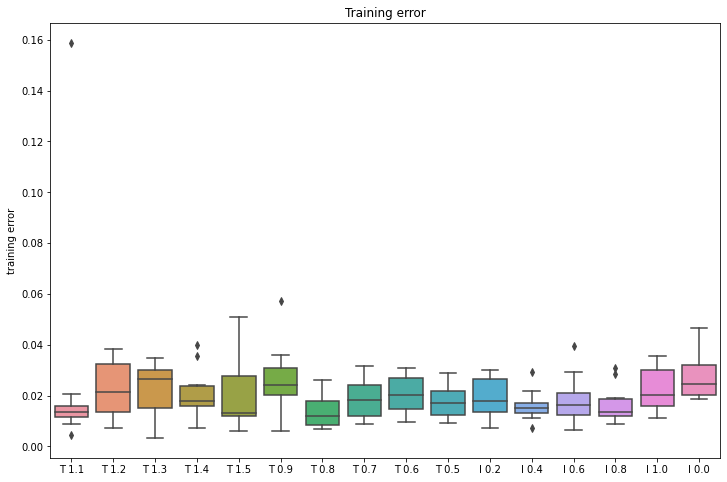

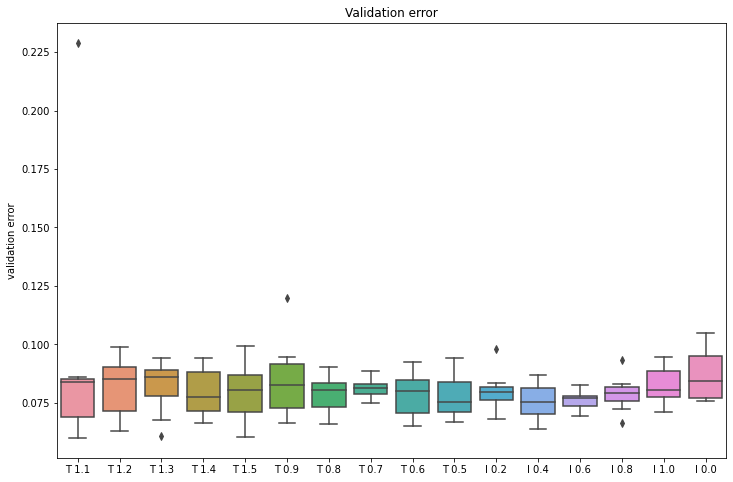

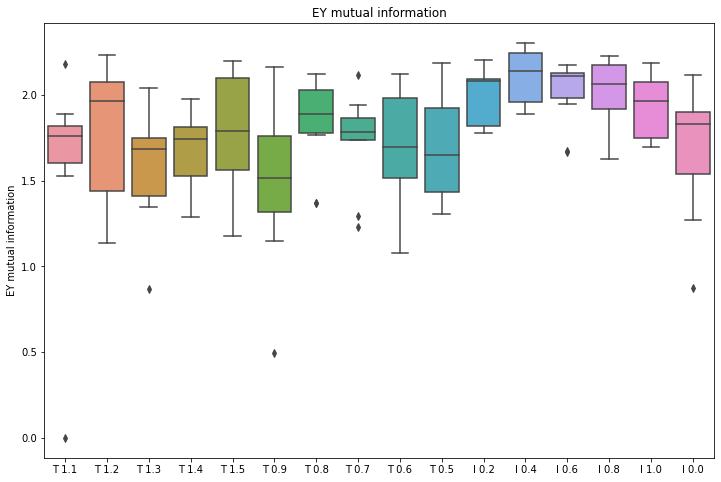

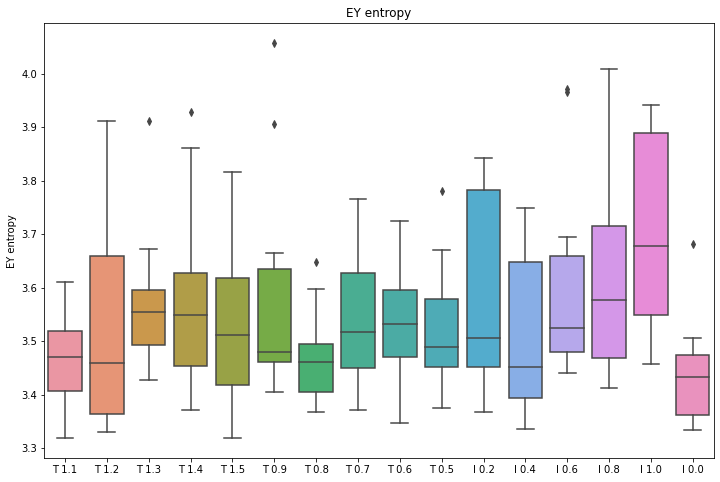

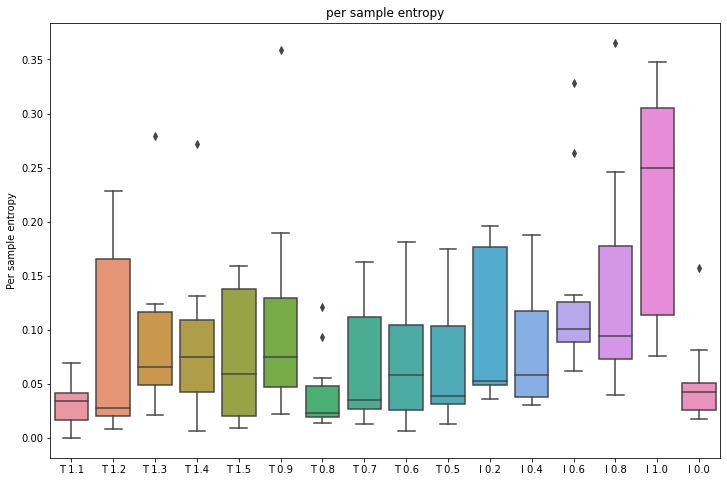

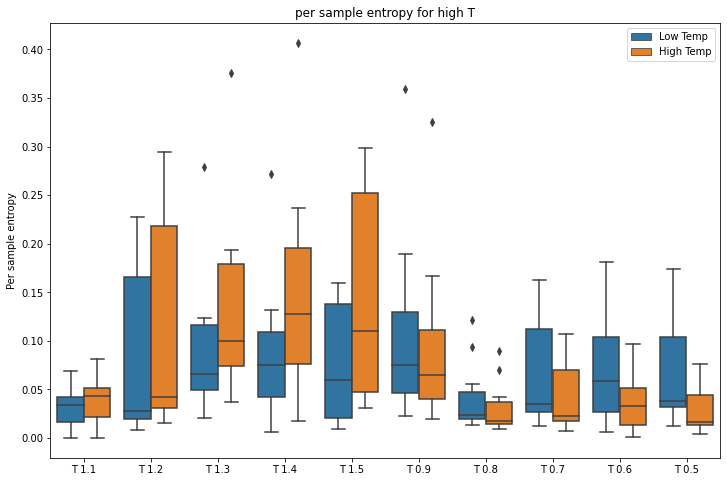

In [79]:
model_with_temp = 'mnist_dual_temp'
model_with_reg = 'mnist_with_regularization'
model_without_reg = 'mnist_without_regularization'
total_experts = 5
num_classes = 10

temps = np.concatenate((np.arange(1.1,1.6,0.1), np.arange(0.9,0.4,-0.1)))
w_importance_range = [i * 0.2 for i in range(1, 6)]

boxplot(model_with_temp, model_with_reg, model_without_reg, temps,w_importance_range,
             total_experts, num_classes, range(num_classes), testloader)

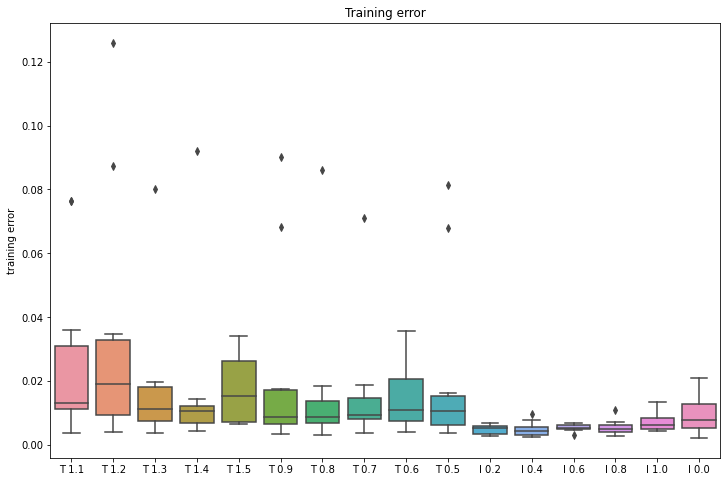

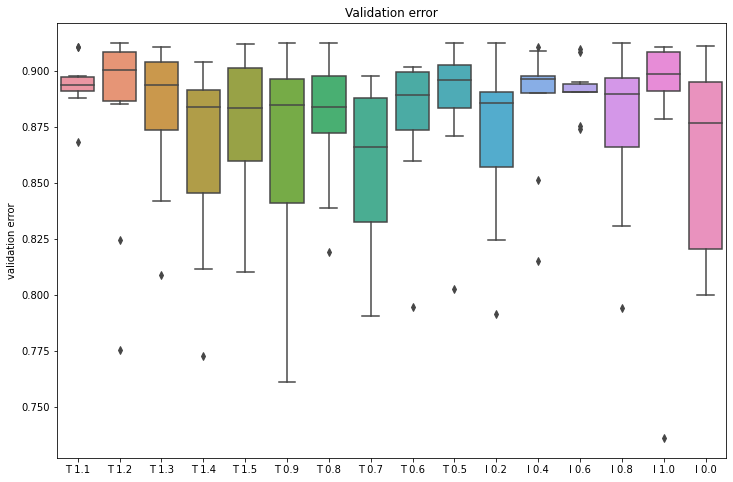

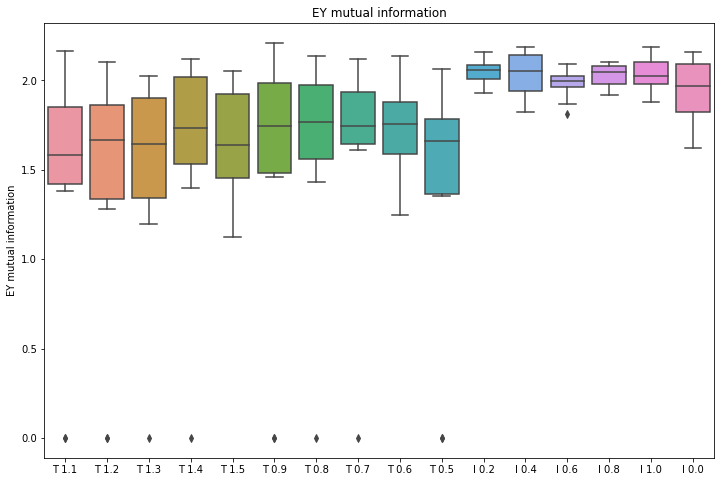

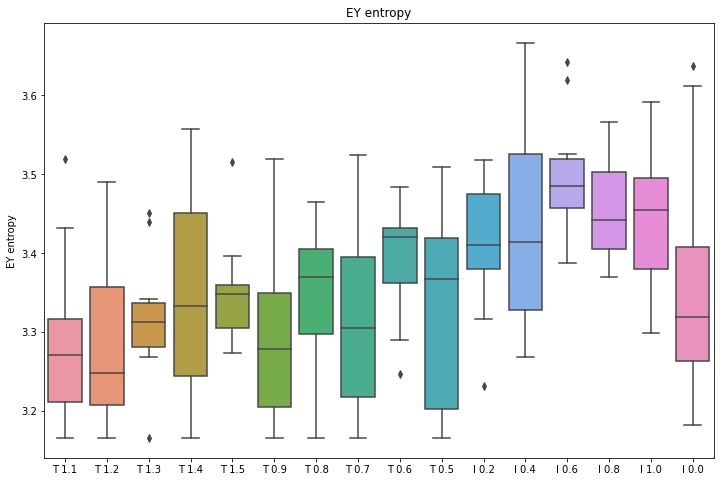

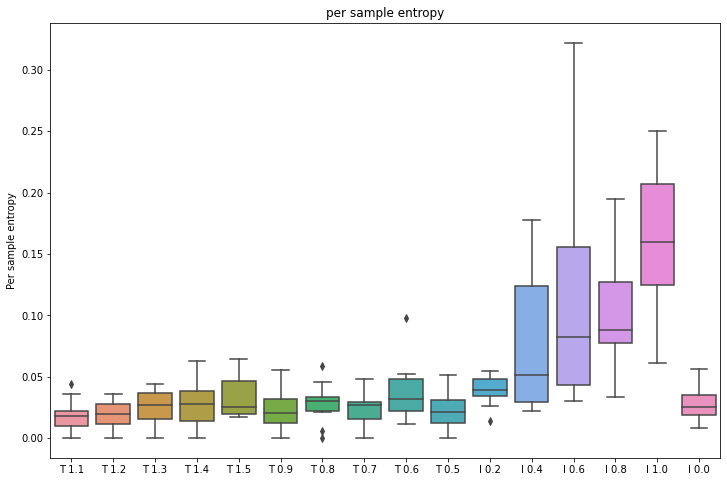

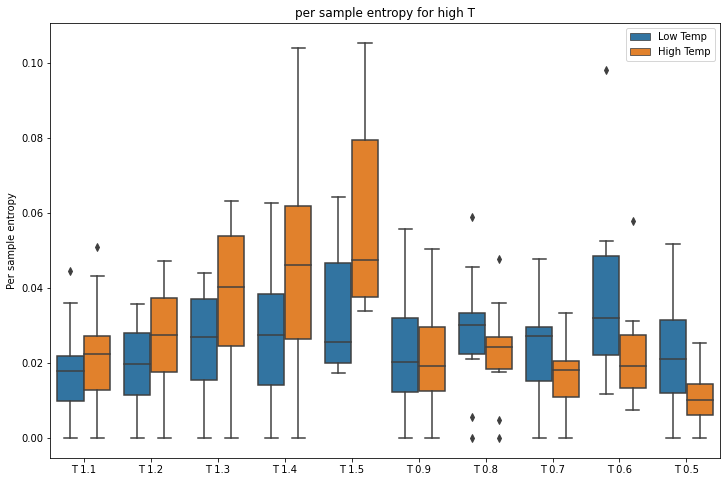

In [80]:
model_with_temp = 'mnist_imbalanced_dual_temp'
model_with_reg = 'mnist_imbalanced_with_regularization'
model_without_reg = 'mnist_imbalanced_without_regularization'
total_experts = 5
num_classes = 10

temps = np.concatenate((np.arange(1.1,1.6,0.1), np.arange(0.9,0.4,-0.1)))
w_importance_range = [i * 0.2 for i in range(1, 6)]

boxplot(model_with_temp, model_with_reg, model_without_reg, temps,w_importance_range,
             total_experts, num_classes, range(num_classes), testloader)

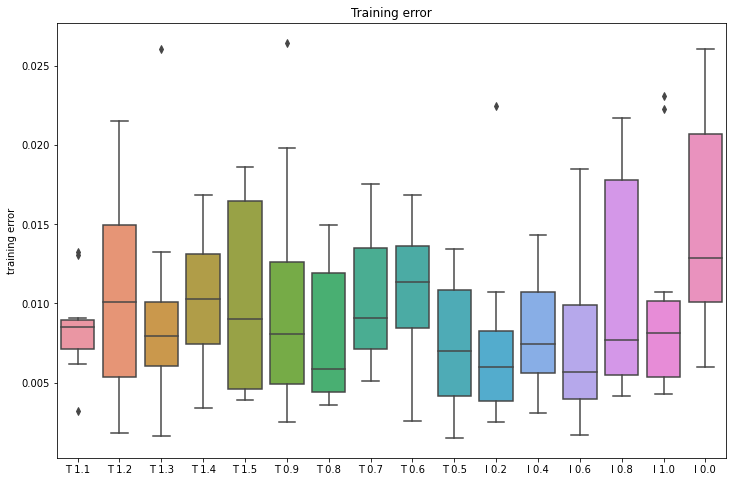

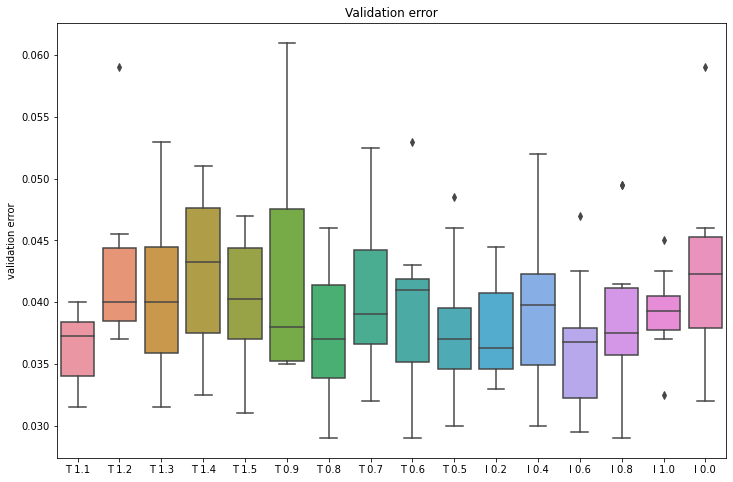

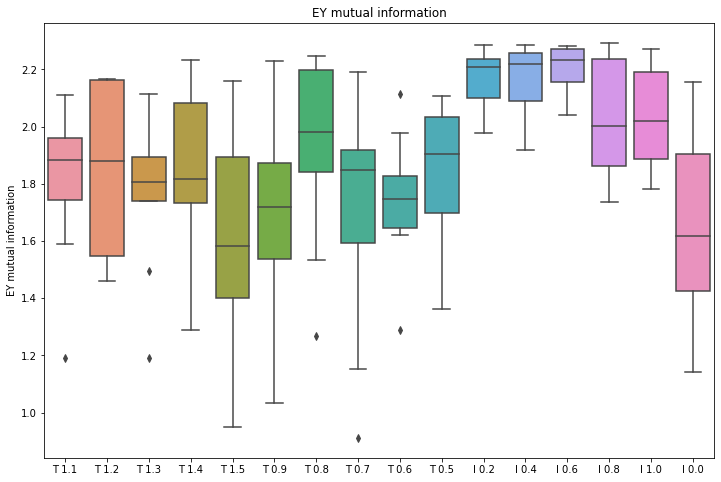

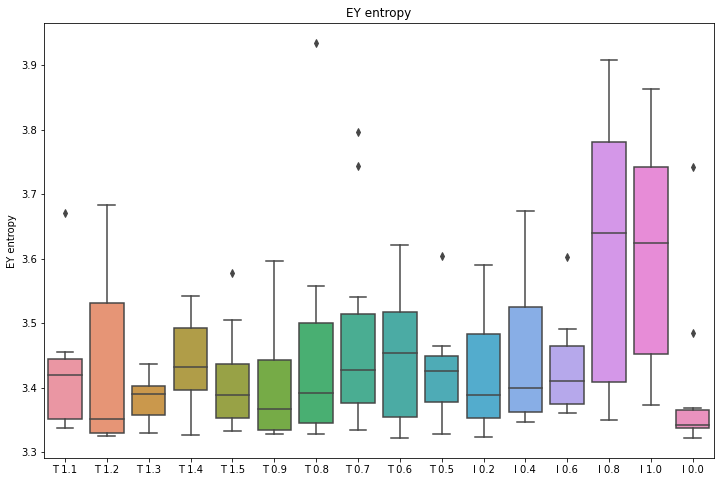

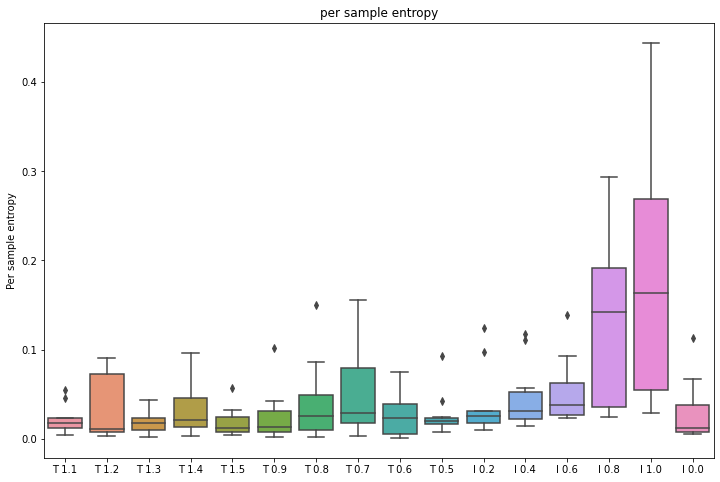

In [67]:
model_with_temp = 'rot_mnist_dual_temp'
model_with_reg = 'rot_mnist_with_regularization'
model_without_reg = 'rot_mnist_without_regularization'

total_experts = 5
num_classes = 10

temps = np.concatenate((np.arange(1.1,1.6,0.1), np.arange(0.9,0.4,-0.1)))
w_importance_range = [i * 0.2 for i in range(1, 6)]

rot_unrot_mnist_classes = ['0','1','2','3','4','rotated 0', 'rotated 1', 'rotated 2', 'rotated 3', 'rotated 4']
boxplot(model_with_temp, model_with_reg, model_without_reg, temps,w_importance_range,
             total_experts, num_classes,rot_unrot_mnist_classes , rot_unrot_testloader)

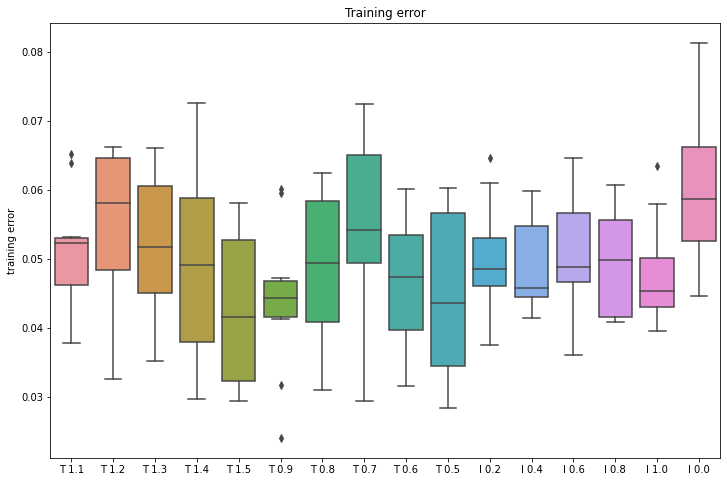

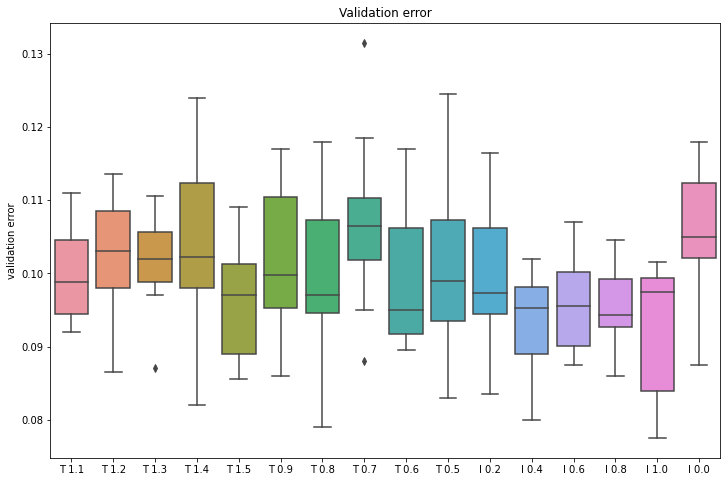

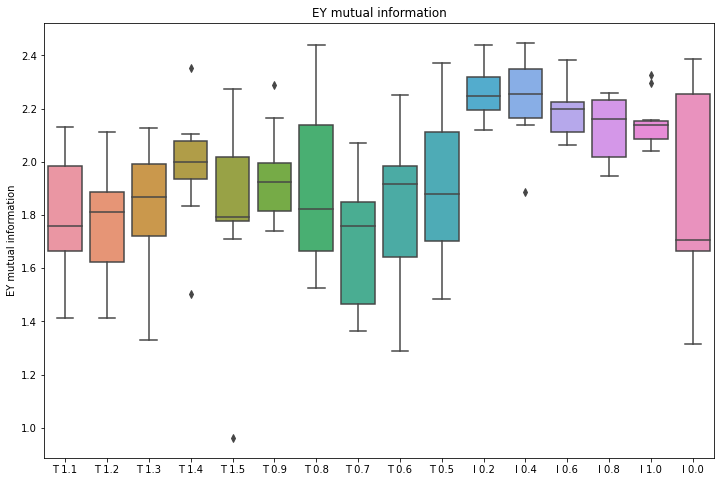

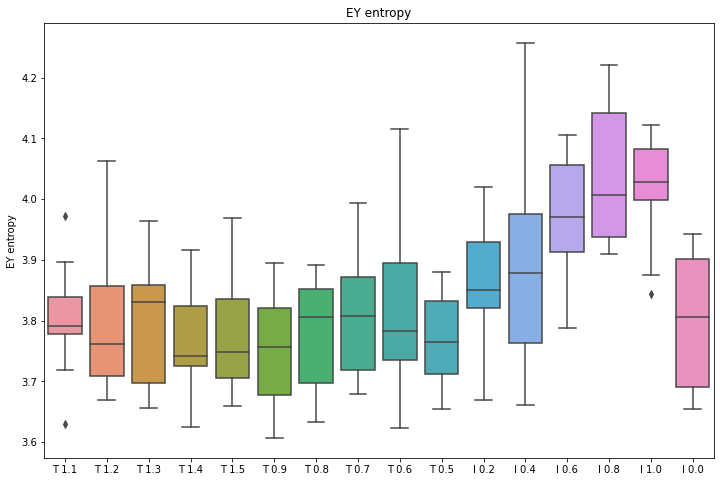

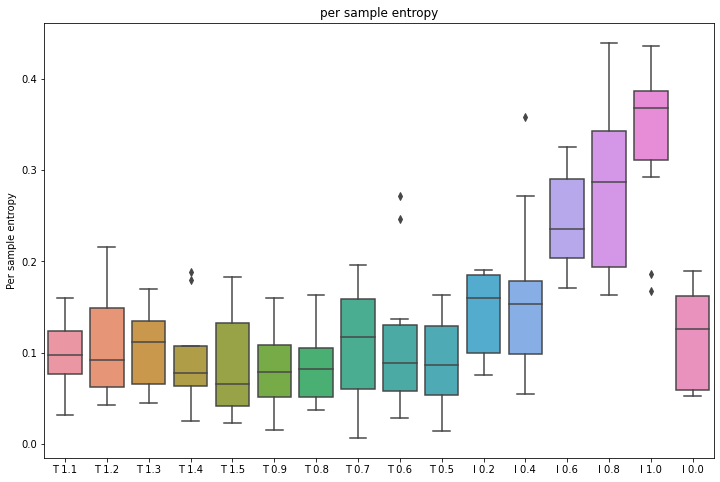

In [69]:
model_with_temp = 'fmnist_mnist_dual_temp'
model_with_reg = 'fmnist_mnist_with_regularization'
model_without_reg = 'fmnist_mnist_without_regularization'
total_experts = 6
temps = np.concatenate((np.arange(1.1,1.6,0.1), np.arange(0.9,0.4,-0.1)))
w_importance_range = [i * 0.2 for i in range(1, 6)]
boxplot(model_with_temp, model_with_reg, model_without_reg, temps,w_importance_range,
             total_experts, num_classes_fmnist_mnist, classes_fmnist_mnist, fmnist_mnist_testloader)

In [110]:
from sklearn.metrics import confusion_matrix

def plot_results(model_with_temp, model_with_reg, model_without_reg, temps, w_importance_range,
                 total_experts, num_classes, classes, testloader):
    
    num_epochs = 20

    min_values = []
    max_values = []
    mean_values = []
    std_values = []
    mutual_info = []
    models = []

    w_importance = 0.0

    for T in temps:    

        m = model_with_temp

        plot_file = generate_plot_file(m, w_importance,'temp_'+"{:.1f}".format(T)+'_'+str(num_classes)+'_'+str(total_experts)+'_models.pt')


        # Note: Here we are loading the pre-trained model from 'pre_trained_model_path. Change this to 'model_path' to load the 
        # model you build above
        model_1 = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)

        print('Model:', plot_file)

        error_values = []
        for model in model_1:
            for e_key, e_val in model.items():
                history = model[e_key]['experts'][total_experts]['history']
                error = 1-np.asarray(history['accuracy'])
                error_values.append(error[-1])

        models.append(model_1[np.argmin(error_values)])

        min_values.append("{:.3f}".format(min(error_values)))
        max_values.append("{:.3f}".format(max(error_values)))
        mean_values.append("{:.3f}".format(mean(error_values)))
        std_values.append("{:.3f}".format(np.std(error_values)))
        mutual_info.append("{:.3f}".format(history['mutual_EY'][-1]))

    T = [ 'T '+"{:.1f}".format(t) for t in temps]
    N_T = len(T)

    

    for w_importance in w_importance_range:

        m = model_with_reg

        plot_file = generate_plot_file(m, w_importance, str(num_classes)+'_'+str(total_experts)+'_models.pt')


        # Note: Here we are loading the pre-trained model from 'pre_trained_model_path. Change this to 'model_path' to load the 
        # model you build above
        model_2 = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)
        print('Model:', plot_file)

        error_values = []
        for model in model_2:
            for e_key, e_val in model.items():
                history = model[e_key]['experts'][total_experts]['history']
                error = 1-np.asarray(history['accuracy'])
                error_values.append(error[-1])

        models.append(model_2[np.argmin(error_values)])
#         models.append(model_2[-1])

        min_values.append("{:.3f}".format(min(error_values)))
        max_values.append("{:.3f}".format(max(error_values)))
        mean_values.append("{:.3f}".format(mean(error_values)))
        std_values.append("{:.3f}".format(np.std(error_values)))
        mutual_info.append("{:.3f}".format(history['mutual_EY'][-1]))

    N_I = len(w_importance_range)
    I = [ 'I '+"{:.1f}".format(i) for i in w_importance_range]

    m = model_without_reg

    plot_file = generate_plot_file(m, 0.0, str(num_classes)+'_'+str(total_experts)+'_models.pt')


    # Note: Here we are loading the pre-trained model from 'pre_trained_model_path. Change this to 'model_path' to load the 
    # model you build above
    model_3 = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)
    print('Model:', plot_file)

    error_values = []
    for model in model_3:
        history = model[e_key]['experts'][total_experts]['history']
        for e_key, e_val in model.items():
            error = 1-np.asarray(history['accuracy'])
            error_values.append(error[-1])

    models.append(model_3[np.argmin(error_values)])
#     models.append(model_3[-1])
    
    min_values.append("{:.3f}".format(min(error_values)))
    max_values.append("{:.3f}".format(max(error_values)))
    mean_values.append("{:.3f}".format(mean(error_values)))
    std_values.append("{:.3f}".format(np.std(error_values)))
    mutual_info.append("{:.3f}".format(history['mutual_EY'][-1]))

    method = T + I + ['I 0.0']
    N = N_T + N_I + 1

    print('N',N)
    data = np.hstack((np.asarray(method).reshape(N,1), np.asarray(min_values).reshape(N,1), np.asarray(max_values).reshape(N,1), 
                      np.asarray(mean_values).reshape(N,1), np.asarray(std_values).reshape(N,1), 
                      np.asarray(mutual_info).reshape(N,1)))

    print(data.shape)

    columns = ['Method', 'Min', 'Max', 'Mean', 'Std', 'Mutual Info']
    colors = np.array([['w']*len(columns)]*N)
    colors[np.argmin(data[:,1]), 1] = 'y'
    colors[np.argmax(data[:,2]), 2] = 'y'
    colors[np.argmin(data[:,3]), 3] = 'y'
    colors[np.argmin(data[:,4]), 4] = 'y'
    colors[np.argmax(data[:,5]), 5] = 'y'

    fig, ax = plt.subplots()
    # hide axes
    fig.patch.set_visible(False)
    ax.axis('off')
    ax.axis('tight')

    ax.table(cellText=data, colLabels=columns, cellColours=colors, loc='center')

    fig.tight_layout()

    plt.show()


    model = models[np.argmin(data[0:N_T,1])]

    fig1,ax1 = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(12, 4))
    ax1.flatten()

    # Plotting for the model with reg
    for e_key, e_val in model.items():


        cmap = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)
        with torch.no_grad():
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                moe_model = e_val['experts'][total_experts]['model']

                # predict the classes for test data
                pred = moe_model(images)
                pred_labels = torch.argmax(pred, dim=1)

                expert_outputs = moe_model.expert_outputs
                gate_outputs = moe_model.gate_outputs

                # get the experts selected by the gate for each sample
                pred_gate_labels = torch.argmax(gate_outputs, dim=1)

                # plot the expert selection table
                print('\nExperts used by the gate for classification of each digit')
                class_expert_table = np.asarray([[0] * num_classes]*total_experts)
                for label, expert in zip(labels, pred_gate_labels):
                    class_expert_table[expert,label] += 1
                sns.heatmap(class_expert_table, yticklabels=['E'+str(i) for i in range(1,total_experts+1)], 
                            xticklabels=[classes[i] for i in range(0, num_classes)],
                            annot=True, cmap=cmap, fmt='d', ax=ax1[0])

                sns.heatmap(confusion_matrix(labels.cpu(), pred_labels.cpu()), annot=True, ax=ax1[1], cmap=cmap, fmt='d')

                plt.show()


    model = models[N_T+np.argmin(data[N_T:N-1,1])]
    
    fig1,ax1 = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(12, 4))
    ax1.flatten()

    # Plotting for the model without reg
    for e_key, e_val in model.items():
        cmap = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)

        with torch.no_grad():
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                moe_model = e_val['experts'][total_experts]['model']

                # predict the classes for test data
                pred = moe_model(images)
                pred_labels = torch.argmax(pred, dim=1)

                expert_outputs = moe_model.expert_outputs
                gate_outputs = moe_model.gate_outputs

                # get the experts selected by the gate for each sample
                pred_gate_labels = torch.argmax(gate_outputs, dim=1)

                # plot the expert selection table
                print('\nExperts used by the gate for classification of each digit')
                class_expert_table = np.asarray([[0] * num_classes]*total_experts)
                for label, expert in zip(labels, pred_gate_labels):
                    class_expert_table[expert,label] += 1
                sns.heatmap(class_expert_table, yticklabels=['E'+str(i) for i in range(1,total_experts+1)], 
                            xticklabels=[classes[i] for i in range(0, num_classes)],
                            annot=True, cmap=cmap, fmt='d', ax=ax1[0])

                sns.heatmap(confusion_matrix(labels.cpu(), pred_labels.cpu()), annot=True, ax=ax1[1], cmap=cmap, fmt='d')

                plt.show()

    model = models[-1]

    fig1,ax1 = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(12, 4))
    ax1.flatten()

    # Plotting for the model without reg
    for e_key, e_val in model.items():
        cmap = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)

        with torch.no_grad():
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                moe_model = e_val['experts'][total_experts]['model']

                # predict the classes for test data
                pred = moe_model(images)
                pred_labels = torch.argmax(pred, dim=1)

                expert_outputs = moe_model.expert_outputs
                gate_outputs = moe_model.gate_outputs

                # get the experts selected by the gate for each sample
                pred_gate_labels = torch.argmax(gate_outputs, dim=1)

                # plot the expert selection table
                print('\nExperts used by the gate for classification of each digit')
                class_expert_table = np.asarray([[0] * num_classes]*total_experts)
                for label, expert in zip(labels, pred_gate_labels):
                    class_expert_table[expert,label] += 1
                sns.heatmap(class_expert_table, yticklabels=['E'+str(i) for i in range(1,total_experts+1)], 
                            xticklabels=[classes[i] for i in range(0, num_classes)],
                            annot=True, cmap=cmap, fmt='d', ax=ax1[0])

                sns.heatmap(confusion_matrix(labels.cpu(), pred_labels.cpu()), annot=True, ax=ax1[1], cmap=cmap, fmt='d')

                plt.show()

    # plot error rates
    fig2,ax2 = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(16,4))
    ax2 = ax2.flatten()

    fig3,ax3 = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(8,4))

    fig4,ax4 = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(8,4))
    
    fig5,ax5 = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(8,4))

    for i, model in enumerate(models):
        for e_key, e_val in model.items():

            # plot training and validation error rates
            sns.lineplot(x=range(num_epochs), y=1-np.asarray(model[e_key]['experts'][total_experts]['history']['accuracy']), ax=ax2[0])
            sns.lineplot(x=range(num_epochs), y=1-np.asarray(model[e_key]['experts'][total_experts]['history']['val_accuracy']), ax=ax2[1])

            # plot training loss
            sns.lineplot(x=range(num_epochs), y=np.asarray(model[e_key]['experts'][total_experts]['history']['loss']), ax=ax3)

            # plot mutual information
            sns.lineplot(x=range(num_epochs), y=np.asarray(model[e_key]['experts'][total_experts]['history']['mutual_EY']), ax=ax4)

            # plot mutual information
            sns.lineplot(x=range(num_epochs), y=np.asarray(model[e_key]['experts'][total_experts]['history']['H_EY']), ax=ax5)

    legend = data[:,0]

    ax2[0].legend(legend)

    ax2[0].set_xlabel('epochs')
    ax2[0].set_xticks(range(num_epochs+1))
    ax2[0].set_ylabel('train error rate')
    ax2[0].set_ylim(ymin=0)


    ax2[1].legend(legend)

    ax2[1].set_xlabel('epochs')
    ax2[1].set_xticks(range(num_epochs+1))
    ax2[1].set_ylabel('validation error rate')
    ax2[1].set_ylim(ymin=0)


    ax3.legend(legend)

    ax3.set_xlabel('epochs')
    ax3.set_xticks(range(num_epochs+1))
    ax3.set_ylabel('training loss')
    ax3.set_ylim(ymin=0)

    ax4.legend(legend)

    ax4.set_xlabel('epochs')
    ax4.set_xticks(range(num_epochs+1))
    ax4.set_ylabel('mutual information')
    ax4.set_ylim(ymin=0)
    
    ax5.legend(legend)

    ax5.set_xlabel('epochs')
    ax5.set_xticks(range(num_epochs+1))
    ax5.set_ylabel('Entropy EY')
    ax5.set_ylim(ymin=0)

    plt.show()


### Results for MNIST data

Model: mnist_dual_temp_temp_1.1_10_5_models.pt
Model: mnist_dual_temp_temp_1.2_10_5_models.pt
Model: mnist_dual_temp_temp_1.3_10_5_models.pt
Model: mnist_dual_temp_temp_1.4_10_5_models.pt
Model: mnist_dual_temp_temp_1.5_10_5_models.pt
Model: mnist_dual_temp_temp_0.9_10_5_models.pt
Model: mnist_dual_temp_temp_0.8_10_5_models.pt
Model: mnist_dual_temp_temp_0.7_10_5_models.pt
Model: mnist_dual_temp_temp_0.6_10_5_models.pt
Model: mnist_dual_temp_temp_0.5_10_5_models.pt
Model: mnist_with_regularization_importance_0.2_10_5_models.pt
Model: mnist_with_regularization_importance_0.4_10_5_models.pt
Model: mnist_with_regularization_importance_0.6_10_5_models.pt
Model: mnist_with_regularization_importance_0.8_10_5_models.pt
Model: mnist_with_regularization_importance_1.0_10_5_models.pt
Model: mnist_without_regularization_10_5_models.pt
N 16
(16, 6)


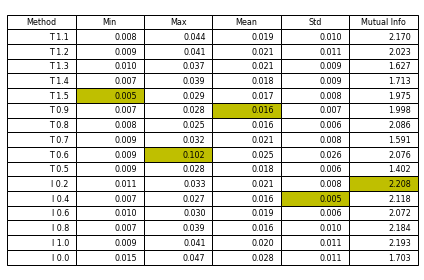


Experts used by the gate for classification of each digit


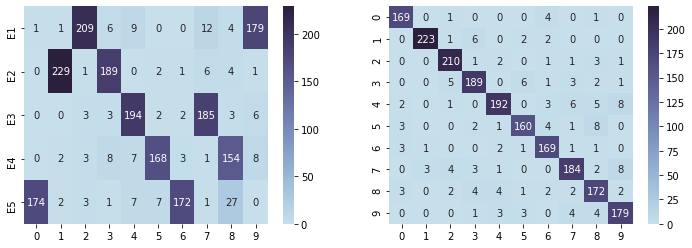


Experts used by the gate for classification of each digit


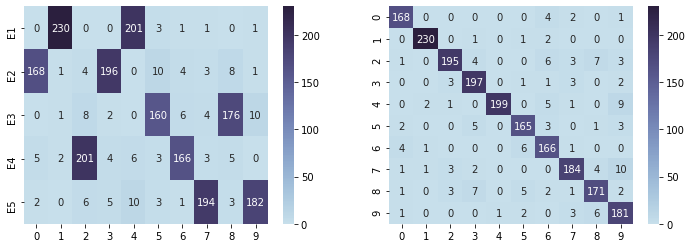


Experts used by the gate for classification of each digit


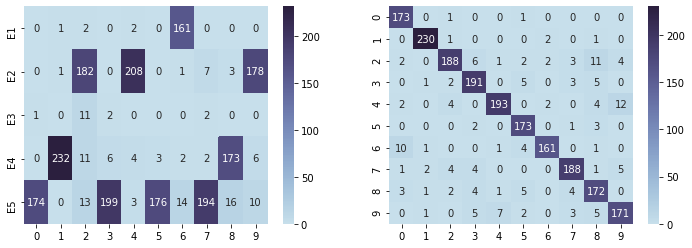

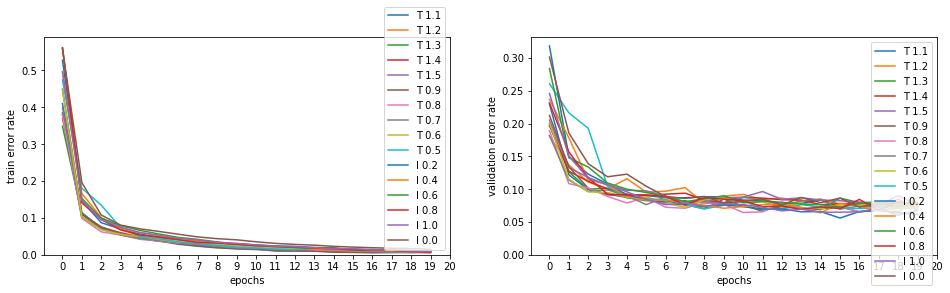

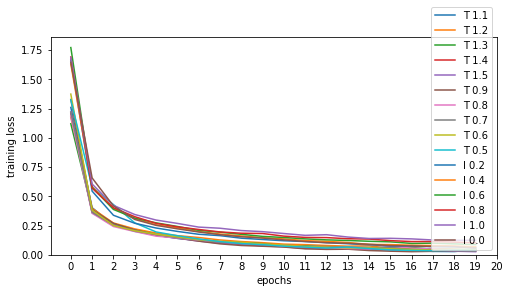

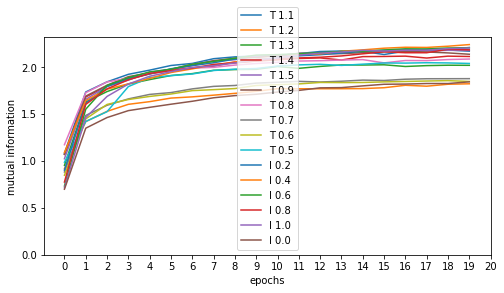

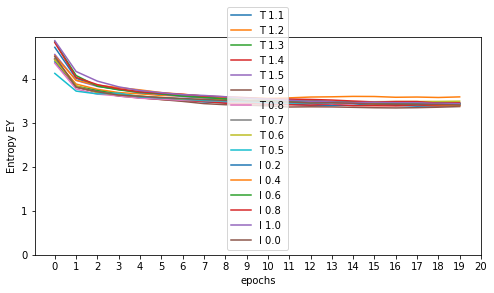

In [111]:
model_with_temp = 'mnist_dual_temp'
model_with_reg = 'mnist_with_regularization'
model_without_reg = 'mnist_without_regularization'
total_experts = 5
num_classes = 10
temps = np.concatenate((np.arange(1.1,1.6,0.1), np.arange(0.9,0.4,-0.1)))
w_importance_range = [i * 0.2 for i in range(1, 6)]

plot_results(model_with_temp, model_with_reg, model_without_reg, temps,w_importance_range,
             total_experts, num_classes, range(num_classes), testloader)

Model: mnist_imbalanced_dual_temp_temp_1.1_10_5_models.pt
Model: mnist_imbalanced_dual_temp_temp_1.2_10_5_models.pt
Model: mnist_imbalanced_dual_temp_temp_1.3_10_5_models.pt
Model: mnist_imbalanced_dual_temp_temp_1.4_10_5_models.pt
Model: mnist_imbalanced_dual_temp_temp_1.5_10_5_models.pt
Model: mnist_imbalanced_dual_temp_temp_0.9_10_5_models.pt
Model: mnist_imbalanced_dual_temp_temp_0.8_10_5_models.pt
Model: mnist_imbalanced_dual_temp_temp_0.7_10_5_models.pt
Model: mnist_imbalanced_dual_temp_temp_0.6_10_5_models.pt
Model: mnist_imbalanced_dual_temp_temp_0.5_10_5_models.pt
Model: mnist_imbalanced_with_regularization_importance_0.2_10_5_models.pt
Model: mnist_imbalanced_with_regularization_importance_0.4_10_5_models.pt
Model: mnist_imbalanced_with_regularization_importance_0.6_10_5_models.pt
Model: mnist_imbalanced_with_regularization_importance_0.8_10_5_models.pt
Model: mnist_imbalanced_with_regularization_importance_1.0_10_5_models.pt
Model: mnist_imbalanced_without_regularization_10_

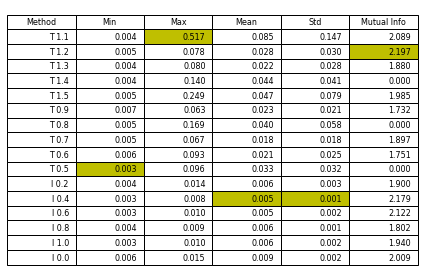


Experts used by the gate for classification of each digit


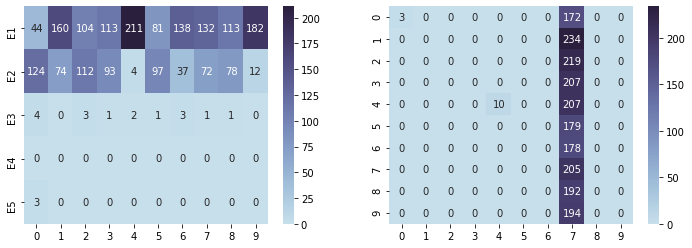


Experts used by the gate for classification of each digit


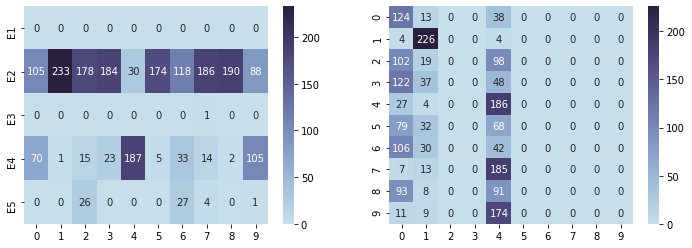


Experts used by the gate for classification of each digit


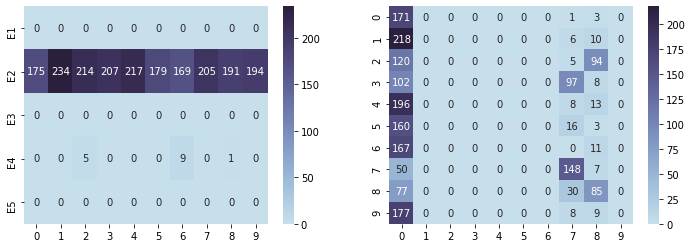

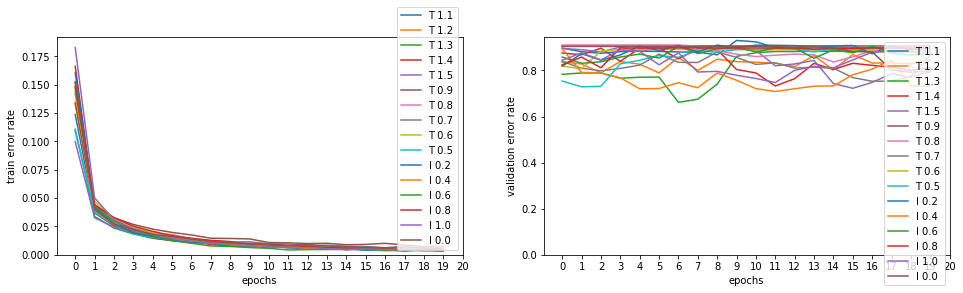

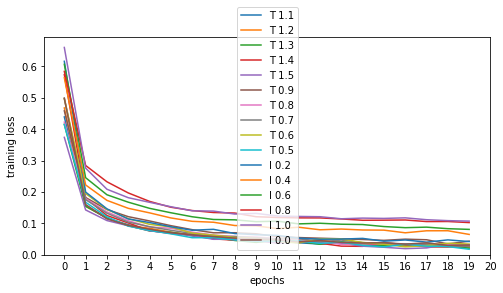

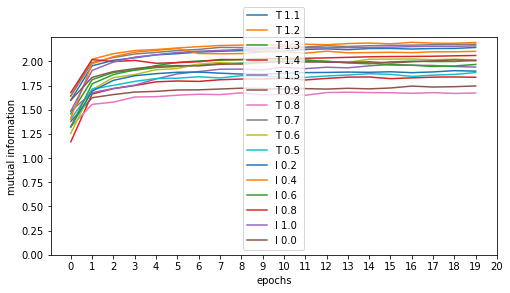

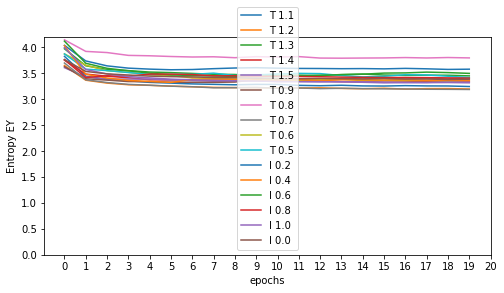

In [112]:
model_with_temp = 'mnist_imbalanced_dual_temp'
model_with_reg = 'mnist_imbalanced_with_regularization'
model_without_reg = 'mnist_imbalanced_without_regularization'
total_experts = 5
num_classes = 10

temps = np.concatenate((np.arange(1.1,1.6,0.1), np.arange(0.9,0.4,-0.1)))
w_importance_range = [i * 0.2 for i in range(1, 6)]

plot_results(model_with_temp, model_with_reg, model_without_reg, temps,w_importance_range,
             total_experts, num_classes, range(num_classes), testloader)

Model: rot_mnist_dual_temp_temp_1.1_10_5_models.pt
Model: rot_mnist_dual_temp_temp_1.2_10_5_models.pt
Model: rot_mnist_dual_temp_temp_1.3_10_5_models.pt
Model: rot_mnist_dual_temp_temp_1.4_10_5_models.pt
Model: rot_mnist_dual_temp_temp_1.5_10_5_models.pt
Model: rot_mnist_dual_temp_temp_0.9_10_5_models.pt
Model: rot_mnist_dual_temp_temp_0.8_10_5_models.pt
Model: rot_mnist_dual_temp_temp_0.7_10_5_models.pt
Model: rot_mnist_dual_temp_temp_0.6_10_5_models.pt
Model: rot_mnist_dual_temp_temp_0.5_10_5_models.pt
Model: rot_mnist_with_regularization_importance_0.2_10_5_models.pt
Model: rot_mnist_with_regularization_importance_0.4_10_5_models.pt
Model: rot_mnist_with_regularization_importance_0.6_10_5_models.pt
Model: rot_mnist_with_regularization_importance_0.8_10_5_models.pt
Model: rot_mnist_with_regularization_importance_1.0_10_5_models.pt
Model: rot_mnist_without_regularization_10_5_models.pt
N 16
(16, 6)


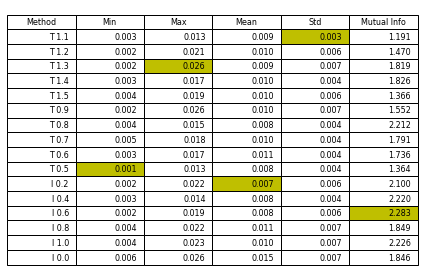


Experts used by the gate for classification of each digit


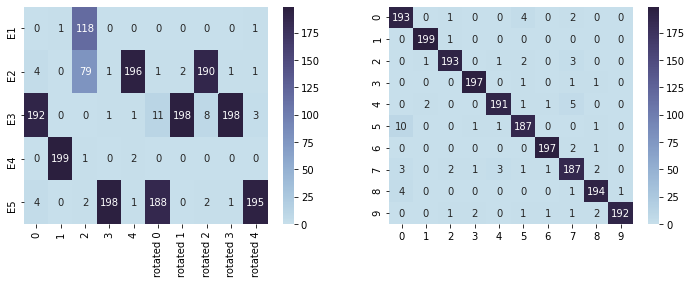


Experts used by the gate for classification of each digit


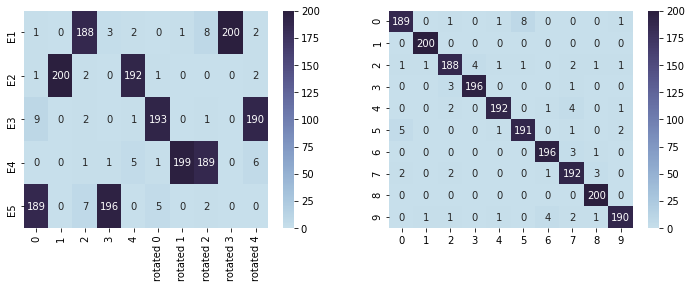


Experts used by the gate for classification of each digit


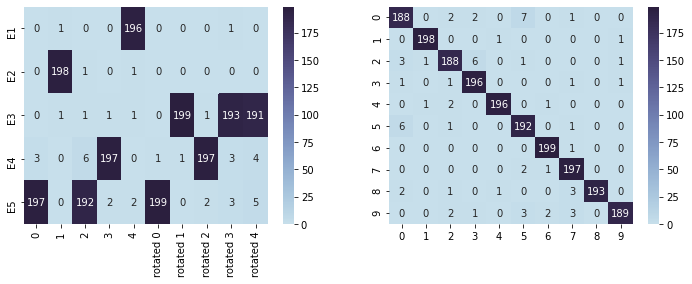

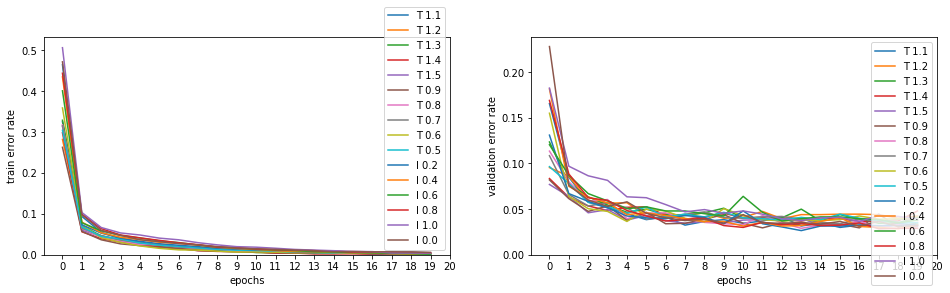

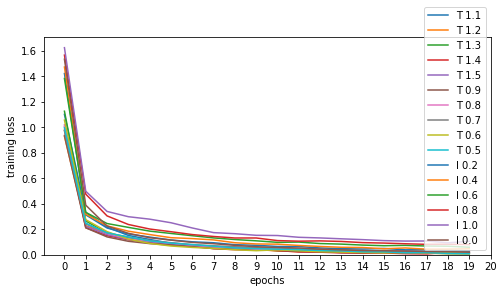

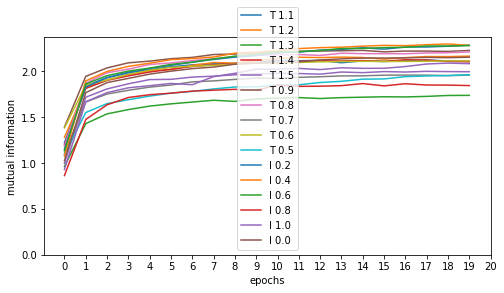

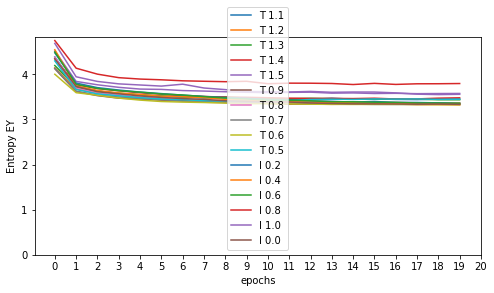

In [113]:
model_with_temp = 'rot_mnist_dual_temp'
model_with_reg = 'rot_mnist_with_regularization'
model_without_reg = 'rot_mnist_without_regularization'
total_experts = 5
num_classes = 10

temps = np.concatenate((np.arange(1.1,1.6,0.1), np.arange(0.9,0.4,-0.1)))
w_importance_range = [i * 0.2 for i in range(1, 6)]

rot_unrot_mnist_classes = ['0','1','2','3','4','rotated 0', 'rotated 1', 'rotated 2', 'rotated 3', 'rotated 4']
plot_results(model_with_temp, model_with_reg, model_without_reg, temps, w_importance_range,
             total_experts, num_classes,rot_unrot_mnist_classes , rot_unrot_testloader)

### Results for combined FMNIST and MNIST data

Model: fmnist_mnist_dual_temp_temp_1.1_12_6_models.pt
Model: fmnist_mnist_dual_temp_temp_1.2_12_6_models.pt
Model: fmnist_mnist_dual_temp_temp_1.3_12_6_models.pt
Model: fmnist_mnist_dual_temp_temp_1.4_12_6_models.pt
Model: fmnist_mnist_dual_temp_temp_1.5_12_6_models.pt
Model: fmnist_mnist_dual_temp_temp_0.9_12_6_models.pt
Model: fmnist_mnist_dual_temp_temp_0.8_12_6_models.pt
Model: fmnist_mnist_dual_temp_temp_0.7_12_6_models.pt
Model: fmnist_mnist_dual_temp_temp_0.6_12_6_models.pt
Model: fmnist_mnist_dual_temp_temp_0.5_12_6_models.pt
Model: fmnist_mnist_with_regularization_importance_0.2_12_6_models.pt
Model: fmnist_mnist_with_regularization_importance_0.4_12_6_models.pt
Model: fmnist_mnist_with_regularization_importance_0.6_12_6_models.pt
Model: fmnist_mnist_with_regularization_importance_0.8_12_6_models.pt
Model: fmnist_mnist_with_regularization_importance_1.0_12_6_models.pt
Model: fmnist_mnist_without_regularization_12_6_models.pt
N 16
(16, 6)


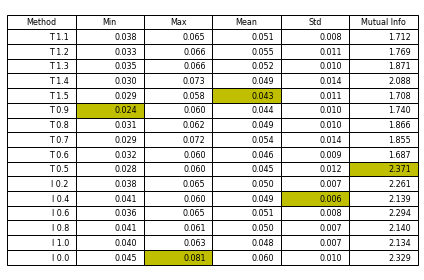


Experts used by the gate for classification of each digit


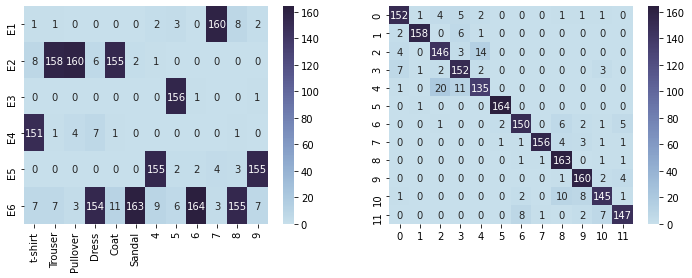


Experts used by the gate for classification of each digit


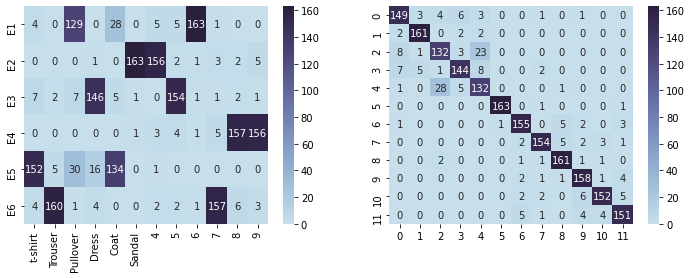


Experts used by the gate for classification of each digit


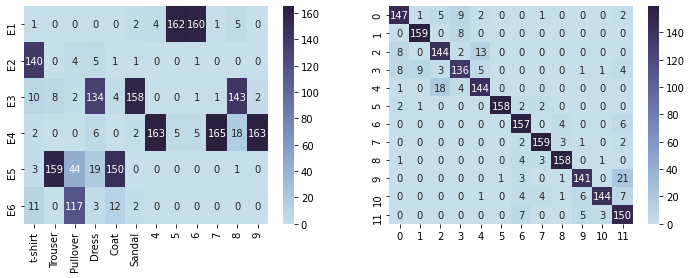

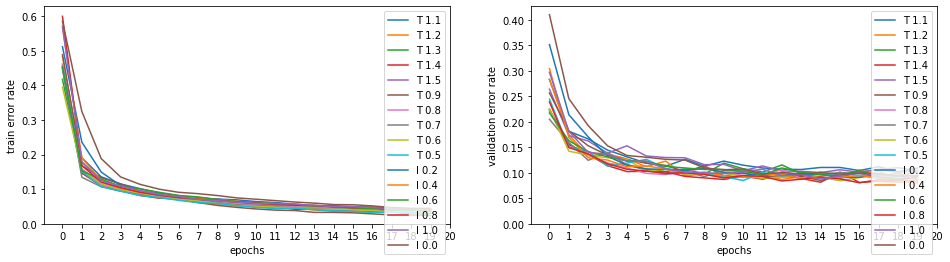

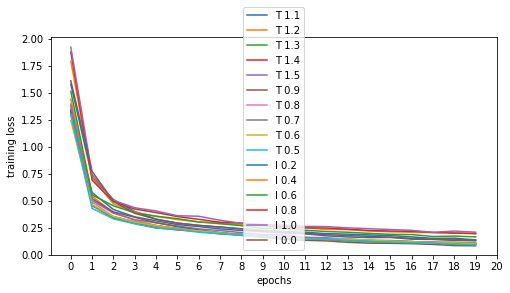

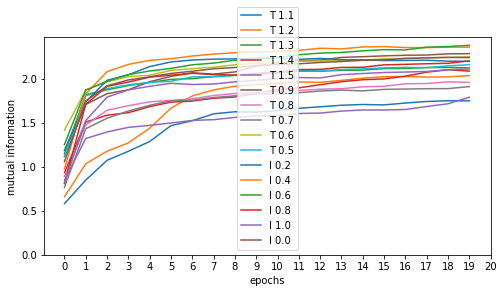

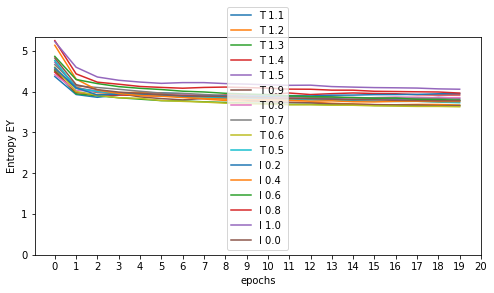

In [114]:
model_with_temp = 'fmnist_mnist_dual_temp'
model_with_reg = 'fmnist_mnist_with_regularization'
model_without_reg = 'fmnist_mnist_without_regularization'
total_experts = 6

temps = np.concatenate((np.arange(1.1,1.6,0.1), np.arange(0.9,0.4,-0.1)))
w_importance_range = [i * 0.2 for i in range(1, 6)]

plot_results(model_with_temp, model_with_reg, model_without_reg, temps, w_importance_range,
             total_experts, num_classes_fmnist_mnist, classes_fmnist_mnist, fmnist_mnist_testloader)

In [76]:
def plot_gate_prob(model_with_temp, model_with_reg, model_without_reg, temps, w_importance_range,
                 total_experts, num_classes, classes, testloader):
    
    w_importance = 0.0
    
    for T in temps:    

        m = model_with_temp

        plot_file = generate_plot_file(m, w_importance,'temp_'+"{:.1f}".format(T)+'_'+str(num_classes)+'_'+str(total_experts)+'_models.pt')


        # Note: Here we are loading the pre-trained model from 'pre_trained_model_path. Change this to 'model_path' to load the 
        # model you build above
        model = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)[5]
        
        for e_key, e_val in model.items():
            history = model[e_key]['experts'][total_experts]['history']
            mean_gate_probability = np.asarray(history['mean_gate_probability'])
            var_gate_probability = np.asarray(history['var_gate_probability'])
            print('Temperature ', "{:.1f}".format(T))
            print(mean_gate_probability.shape)
            plt.imshow(np.transpose(mean_gate_probability))
            plt.show()
            plt.imshow(np.transpose(var_gate_probability))
            plt.show()
        
    

#     for w_importance in w_importance_range:

#         m = model_with_reg

#         plot_file = generate_plot_file(m, w_importance, str(num_classes)+'_'+str(total_experts)+'_models.pt')


#         # Note: Here we are loading the pre-trained model from 'pre_trained_model_path. Change this to 'model_path' to load the 
#         # model you build above
#         model_2 = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)
# #         print('Model:', plot_file)

#         error_values = []
#         for model in model_2:
#             for e_key, e_val in model.items():
#                 history = model[e_key]['experts'][total_experts]['history']
#                 error = 1-np.asarray(history['accuracy'])
#                 val_error = 1-np.asarray(history['val_accuracy'])
#                 y_error.append(error[-1])
#                 y_val_error.append(val_error[-1])
#                 y_mi.append(history['mutual_EY'][-1])
#                 y_H_EY.append(history['H_EY'][-1])
#                 y_sample_H.append(history['sample_entropy'][-1])
#                 x.append('I '+"{:.1f}".format(w_importance))


Temperature  1.1
(20, 6)


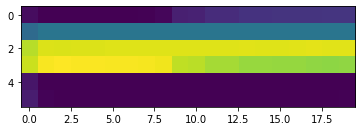

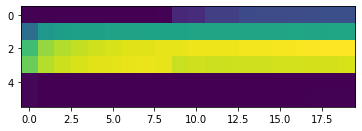

Temperature  1.2
(20, 6)


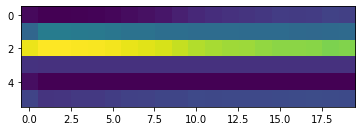

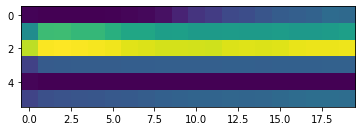

Temperature  1.3
(20, 6)


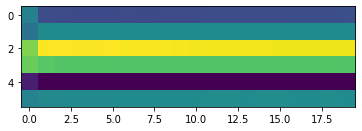

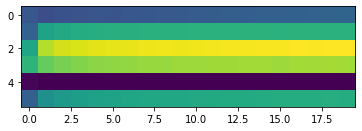

Temperature  1.4
(20, 6)


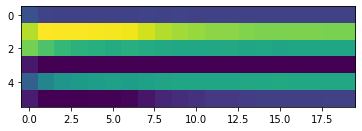

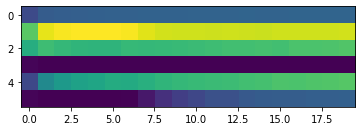

Temperature  1.5
(20, 6)


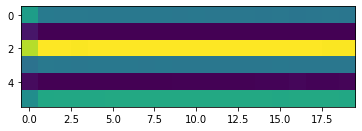

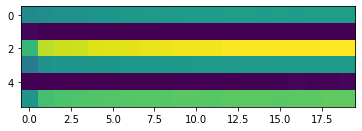

Temperature  0.9
(20, 6)


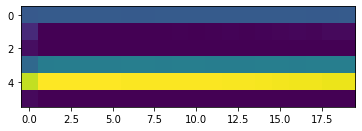

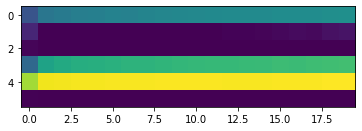

Temperature  0.8
(20, 6)


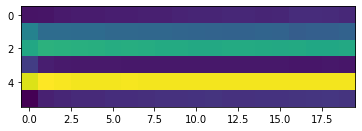

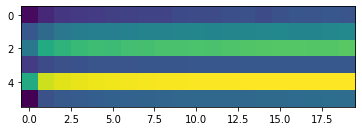

Temperature  0.7
(20, 6)


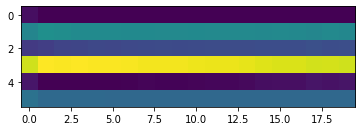

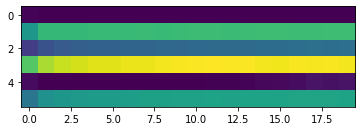

Temperature  0.6
(20, 6)


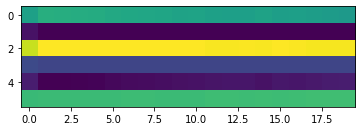

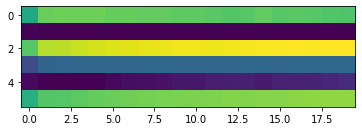

Temperature  0.5
(20, 6)


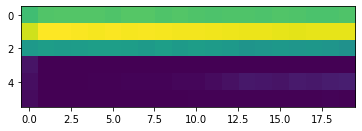

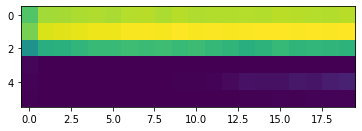

In [77]:
model_with_temp = 'fmnist_mnist_dual_temp'
model_with_reg = 'fmnist_mnist_with_regularization'
model_without_reg = 'fmnist_mnist_without_regularization'
total_experts = 6
temps = np.concatenate((np.arange(1.1,1.6,0.1), np.arange(0.9,0.4,-0.1)))
w_importance_range = [i * 0.2 for i in range(1, 6)]
plot_gate_prob(model_with_temp, model_with_reg, model_without_reg, temps,w_importance_range,
             total_experts, num_classes_fmnist_mnist, classes_fmnist_mnist, fmnist_mnist_testloader)

## Experiment 1: Train MoE expectation model with importance

In [ ]:
# Model with gate and expert parameters initialized to default values
model_1 = 'mnist_on_validation'

In [ ]:
num_epochs = 20

In [ ]:
# Set train and test size
trainsize = 2048
testsize = 2000
valsize = 10048

In [ ]:
# Load and split data as train and test
trainset = torchvision.datasets.MNIST('./data',
    download=True,
    train=True,
    transform=transform)
testset = torchvision.datasets.MNIST('./data',
    download=True,
    train=False,
    transform=transform)

batch_size = 64
# dataloaders
trainloaders = []
for i in range(total_experts):
    dataset = torch.utils.data.DataLoader(torch.utils.data.Subset(trainset, range(i*trainsize,(i*trainsize)+trainsize)), 
                                          batch_size=batch_size,
                                          shuffle=True)
    trainloaders.append(dataset)
    all_labels = []
    for inputs, labels in dataset:
        all_labels.append(labels)
    all_labels = torch.stack(all_labels)
i+=1
valloader = torch.utils.data.DataLoader(torch.utils.data.Subset(trainset, range(i*trainsize,(i*trainsize)+valsize)), 
                                          batch_size=batch_size,
                                          shuffle=True)
trainloader = torch.utils.data.DataLoader(torch.utils.data.Subset(trainset, range(0, valsize)), 
                                          batch_size=batch_size,
                                          shuffle=True)

testloader = torch.utils.data.DataLoader(torch.utils.data.Subset(testset, range(0,testsize)),
                                         batch_size=testsize,
                                         shuffle=False)
num_classes = 10

image, label = trainset.__getitem__(0)
print('Image shape', image.shape)
print('Train samples ', len(trainset))
print('Test samples ', len(testset))
print(len(trainloaders))

In [ ]:
def train_experts(expert_models, trainloaders, accuracy, num_epochs):
    for i, expert in enumerate(expert_models):
        print('Training Expert ', i)
        optimizer_expert = optim.RMSprop(expert.parameters(),
                                      lr=0.001, momentum=0.9)

        loss_criterion = cross_entropy_loss()
        for epoch in range(num_epochs):
            running_loss = 0.0
            train_running_accuracy = 0.0
            num_batches = 0
            for inputs, labels in trainloaders[i]:
                inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                outputs = expert(inputs)

                optimizer_expert.zero_grad()
                loss = loss_criterion(outputs, labels)

                loss.backward()

                optimizer_expert.step()

                running_loss += loss.item()

                outputs = expert(inputs)

                acc = accuracy(outputs, labels)
                train_running_accuracy += acc

                num_batches += 1

            print('epoch %d' % epoch,
                  'training loss %.2f' % (running_loss/num_batches),
                   ', training accuracy %.2f' % (train_running_accuracy/num_batches),
                   )

In [ ]:
# Train models model_1

n_run_models = []
cv = []
accuracies = []
for e_epoch in range(1,6):
    for g_epoch in range(1,2):
        models = {
            'moe_expectation_model':{'model':moe_expectation_model,'loss':cross_entropy_loss,'experts':{}},
            }

        # Build model with un-trained experts
        for key, val in models.items():
            print('Model:', key, total_experts, 'Experts')
            print('Building model with un-trained experts')
            # copy and save the expert models to save the parameters

            expert_models = experts(total_experts, [None]*total_experts, num_classes, 
                                             [num_classes]*total_experts).to(device)

            gate_model = gate_layers(total_experts, num_classes).to(device)

            optimizer_gate = optim.RMSprop(gate_model.parameters(),
                                          lr=0.001, momentum=0.9)
            for epoch in range(1):
                print('\nTraining Experts')
                train_experts(expert_models, trainloaders, accuracy, e_epoch)


                moe_model = val['model'](total_experts, num_classes, augment=0, attention_flag=0,
                                         experts=expert_models, gate=gate_model)


                print('\nTraining Gate')
                hist = moe_model.train_on_validation(valloader, testloader,  val['loss'], 
                                                     optimizer_gate=optimizer_gate, 
                                                     accuracy=accuracy, epochs=g_epoch)
            moe_model = val['model'](total_experts, num_classes, augment=0, attention_flag=0,
                                         experts=expert_models, gate=gate_model)
            
            optimizer_moe = optim.RMSprop(moe_model.parameters(),
                                      lr=0.001, momentum=0.9)
            print('\nTraining MoE Model')
            hist = moe_model.train(trainloader, testloader,  val['loss'], 
                                                 optimizer_moe=optimizer_moe, 
                                                 accuracy=accuracy, epochs=num_epochs)
                
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                outputs = moe_model(inputs)
                gate_outputs = moe_model.gate_outputs
                gd = torch.sum(gate_outputs, dim=0)
                cv.append((torch.std(gd)/torch.mean(gd)).item())
                accuracies.append(accuracy(outputs, labels).item())
            print(cv[-1], accuracies[-1])
            
            val['experts'][total_experts] = {'model':moe_model, 'history':hist}
        n_run_models.append(models)
        

# Save all the trained models
plot_file = generate_plot_file(model_1, str(num_classes)+'_'+str(total_experts)+'_models.pt')
print(plot_file)
torch.save(n_run_models, open(os.path.join(model_path, plot_file),'wb'))

In [ ]:
torch.save([cv,accuracies], open('results_cv_accuracies.pt','wb'))

In [ ]:
cv, accuracies = torch.load(open('results_cv_accuracies.pt','rb'))

In [ ]:
cv = np.transpose(np.around(cv, decimals=3))
accuracies = np.transpose(np.around(accuracies, decimals=2))
cv

In [ ]:
epochs = []
for i in range(1,6):
    for j in range(1,2):
        epochs.append([[i],[j]])
epochs = np.transpose(np.hstack(epochs))
values = np.transpose(np.vstack((cv,accuracies)))
from numpy.lib import recfunctions as rfn
data = np.hstack((epochs,values))

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

m = model_1
total_experts = 5
plot_file = generate_plot_file(m, str(num_classes)+'_'+str(total_experts)+'_models.pt')
models_list = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)
print(plot_file)

# columns = ('Expert Epoch', 'Expert Gate', 'CV', 'Accuracy')
# # Add a table at the bottom of the axes
# plt.box(on=None)
# ax = plt.gca()
# ax.get_xaxis().set_visible(False)
# ax.get_yaxis().set_visible(False)
# the_table = plt.table(cellText=data,
#                       colLabels=columns,
#                      loc='center')
# image_file = generate_plot_file(m, 'cv_accuracy_table_'+str(num_classes)+'_'+str(total_experts)+'_experts.png')
# print(image_file)
# plt.savefig(os.path.join(fig_path, image_file))
# plt.show()

# fig,ax = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(6,4))
# sns.lineplot(x=cv,y=accuracies, ax=ax)
# plt.show()
                      
for i, models in enumerate(models_list):
    # Plotting for the model of the first run
    print('\nE epoch:', data[i,0], 'G epoch:',data[i,1])
    for e_key, e_val in models.items():
        cmap = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)

        for images, labels in testloader:
            fig1,ax1 = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(6,4))
            images, labels = images.to(device), labels.to(device)
            moe_model = e_val['experts'][total_experts]['model']

            # predict the classes for test data
            pred = moe_model(images)
            pred_labels = torch.argmax(pred, dim=1)

            expert_outputs = moe_model.expert_outputs
            gate_outputs = moe_model.gate_outputs

            # plot the confusion matrix
            print('\nConfusion matrix of predictions of the MNIST test data by MoE expectation model')
            sns.heatmap(confusion_matrix(labels.cpu(), pred_labels.cpu()), annot=True, ax=ax1, cmap=cmap, fmt='d')
            image_file = generate_plot_file(m, 'conf_mat_run_'+str(num_classes)+'_'+str(total_experts)+'_experts.png')
            fig1.savefig(os.path.join(fig_path, image_file))
            plt.show()

            fig2,ax2 = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(8,4))

            # get the experts selected by the gate for each sample
            pred_gate_labels = torch.argmax(gate_outputs, dim=1)

            # plot the expert selection table
            print('\nExperts used by the gate for classification of each digit')
            class_expert_table = np.asarray([[0] * num_classes]*total_experts)
            for label, expert in zip(labels, pred_gate_labels):
                class_expert_table[expert,label] += 1
            sns.heatmap(class_expert_table, yticklabels=['E'+str(i) for i in range(1,total_experts+1)], annot=True, cmap=cmap, fmt='d', ax=ax2)

            image_file = generate_plot_file(m, 'class_expert_table_run_'+str(num_classes)+'_'+str(total_experts)+'_experts.png')
            fig2.savefig(os.path.join(fig_path, image_file))
            plt.show()

### Experiment 2 - Training with single model

In [ ]:
num_epochs = 20

In [ ]:
model_2 = 'single_model'

In [ ]:
num_classes = 10

In [ ]:
sm = single_model().to(device)
optimizer = optim.RMSprop(sm.parameters(),
                              lr=0.001, momentum=0.9)

loss_criterion = cross_entropy_loss()
for epoch in range(num_epochs):
    running_loss = 0.0
    train_running_accuracy = 0.0
    num_batches = 0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        outputs = sm(inputs)

        optimizer.zero_grad()
        loss = loss_criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        running_loss += loss.item()

        outputs = sm(inputs)

        acc = accuracy(outputs, labels)
        train_running_accuracy += acc

        num_batches += 1

    print('epoch %d' % epoch,
          'training loss %.2f' % (running_loss/num_batches),
           ', training accuracy %.2f' % (train_running_accuracy/num_batches),
           )

In [ ]:
plot_file = generate_plot_file(model_2, str(num_classes)+'_models.pt')
print(plot_file)
torch.save(sm, open(os.path.join(model_path, plot_file),'wb'))

In [ ]:
plot_file = generate_plot_file(model_2, str(num_classes)+'_models.pt')
sm = torch.load(open(os.path.join(model_path, plot_file),'rb'))

In [ ]:
new_trainloader = torch.utils.data.DataLoader(torch.utils.data.Subset(trainset, range(valsize, 3*valsize)), 
                                          batch_size=2*valsize,
                                          shuffle=True)

In [ ]:
image, label = trainset.__getitem__(0)
print('Image shape', image.shape)
print('Train samples ', len(trainset))
print('Test samples ', len(testset))
print(len(new_trainloader.dataset))

In [ ]:
indices = None
for inputs, labels in new_trainloader:
    inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
    outputs = sm(inputs)
    indices = torch.where((torch.argmax(outputs, dim=1)==labels)==True)[0]

In [ ]:
new_trainloader_1 = torch.utils.data.DataLoader(torch.utils.data.Subset(trainset, (indices+valsize)[0:valsize]), 
                                          batch_size=batch_size,
                                          shuffle=True)
print(len(new_trainloader.dataset))

In [ ]:
model_3 = 'selected_data'

In [ ]:
# Train models model_1, model_2 and model_3 for 10 runs
models = {
    'moe_expectation_model':{'model':moe_expectation_model,'loss':cross_entropy_loss,'experts':{}},
    }

# Build model with un-trained experts
for key, val in models.items():
    print('Model:', key, total_experts, 'Experts')
    # copy and save the expert models to save the parameters
    expert_models = experts(total_experts, [None]*total_experts, num_classes, 
                                 [num_classes]*total_experts).to(device)

    gate_model = gate_layers(total_experts, num_classes).to(device)

    moe_model = val['model'](total_experts, num_classes, augment=0, attention_flag=0,
                             experts=expert_models, gate=gate_model)


    optimizer_moe = optim.RMSprop(moe_model.parameters(),
                              lr=0.001, momentum=0.9)
    hist = moe_model.train(new_trainloader_1, testloader,  val['loss'], optimizer_moe, 
                           w_importance=1.0,
                           accuracy=accuracy, epochs=num_epochs)
    val['experts'][total_experts] = {'model':moe_model, 'history':hist}

# Save all the trained models
plot_file = generate_plot_file(model_3, 'importance_'+str(num_classes)+'_'+str(total_experts)+'_models.pt')
print(plot_file)
torch.save(models,open(os.path.join(model_path, plot_file),'wb'))

In [ ]:
# helper function to show an image
# (used in the `plot_classes_preds` function below)
def imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.cpu().numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

m = model_3
total_experts = 5
plot_file = generate_plot_file(model_3, 'importance_'+str(num_classes)+'_'+str(total_experts)+'_models.pt')
models = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)
                      
# Plotting for the model of the first run
for e_key, e_val in models.items():
    cmap = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)

    for images, labels in testloader:
        fig1,ax1 = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(6,4))
        images, labels = images.to(device), labels.to(device)
        moe_model = e_val['experts'][total_experts]['model']

        # predict the classes for test data
        pred = moe_model(images)
        pred_labels = torch.argmax(pred, dim=1)
        expert_outputs = moe_model.expert_outputs
        gate_outputs = moe_model.gate_outputs

        # plot the confusion matrix
        print('\nConfusion matrix of predictions of the MNIST test data by MoE expectation model')
        sns.heatmap(confusion_matrix(labels.cpu(), pred_labels.cpu()), annot=True, ax=ax1, cmap=cmap, fmt='d')
        image_file = generate_plot_file(m, 'conf_mat_run_'+str(num_classes)+'_'+str(total_experts)+'_experts.png')
        fig1.savefig(os.path.join(fig_path, image_file))
        plt.show()

        fig2,ax2 = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(8,4))

        # get the experts selected by the gate for each sample
        pred_gate_labels = torch.argmax(gate_outputs, dim=1)

        # plot the expert selection table
        print('\nExperts used by the gate for classification of each digit')
        class_expert_table = np.asarray([[0] * num_classes]*total_experts)
        for label, expert in zip(labels, pred_gate_labels):
            class_expert_table[expert,label] += 1
        sns.heatmap(class_expert_table, yticklabels=['E'+str(i) for i in range(1,total_experts+1)], annot=True, cmap=cmap, fmt='d', ax=ax2)

        image_file = generate_plot_file(m, 'class_expert_table_run_'+str(num_classes)+'_'+str(total_experts)+'_experts.png')
        fig2.savefig(os.path.join(fig_path, image_file))
        plt.show()
        
        misclassified = torch.where((pred_labels == labels)==False)[0]
        for i in range(num_classes):
            indices = labels[misclassified]==i
            print(i,' is misclassified as ', pred_labels[misclassified][indices])
            images_orig = images[misclassified][indices]
            img_grid = torchvision.utils.make_grid(images_orig)
            # show images
            imshow(img_grid, one_channel=True)
